<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Forex/GBPCHF/GBPCHF_1H_High.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "GBPCHF"
data_resample = '1H'
data_label = 'High'
data_label_name = 'y'
start_date = '1 Jan 2018'
finish_date = '1 Jan 2019'
is_duka = True
is_yahoo = False
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [4]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

2019-08-24 15:09:49,713 - findatapy.market.datavendorweb - INFO - Request Dukascopy data
2019-08-24 15:09:49,716 - findatapy.market.datavendorweb - INFO - About to download from Dukascopy... for GBPCHF
2019-08-24 15:14:01,051 - findatapy.market.datavendorweb - INFO - Downloading... 2018-01-30 00:00:00
2019-08-24 15:23:22,927 - findatapy.market.datavendorweb - INFO - Downloading... 2018-03-30 00:00:00
2019-08-24 15:27:58,787 - findatapy.market.datavendorweb - INFO - Downloading... 2018-04-30 00:00:00
2019-08-24 15:32:35,802 - findatapy.market.datavendorweb - INFO - Downloading... 2018-05-30 00:00:00
2019-08-24 15:37:15,018 - findatapy.market.datavendorweb - INFO - Downloading... 2018-06-30 00:00:00
2019-08-24 15:41:59,090 - findatapy.market.datavendorweb - INFO - Downloading... 2018-07-30 00:00:00
2019-08-24 15:46:47,292 - findatapy.market.datavendorweb - INFO - Downloading... 2018-08-30 00:00:00
2019-08-24 15:51:28,242 - findatapy.market.datavendorweb - INFO - Downloading... 2018-09-30

/usr/local/lib/python3.6/dist-packages/findatapy/market/ioengine.py:264: FutureWarning: to_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  r.set(fname, data_frame.to_msgpack(compress='blosc'))


2019-08-24 16:05:43,060 - findatapy.market.ioengine - WARNING - Couldn't push MarketDataRequest_436__abstract_curve_key-None__category-None__category_key-backtest_default-cat_dukascopy_tick_NYC_GBPCHF__cut-NYC__data_source-dukascopy__environment-backtest__expiry_date-NaT__fields-temp_ask_bid_askv_bidv__finish_date-2019-01-01 00:00:00__freq-tick__freq_mult-1__gran_freq-None__resample-None__resample_how-last__start_date-2018-01-01 00:00:00__tickers-GBPCHF__trade_side-trade__vendor_fields-temp_ask_bid_askv_bidv__vendor_tickers-GBPCHF to Redis: Error 111 connecting to 127.0.0.1:6379. Connection refused.


Open     High      Low    Close        Volume
Date                                                                 
2018-01-01 22:00:00  1.31359  1.31565  1.31359  1.31446    111.250000
2018-01-01 23:00:00  1.31439  1.31729  1.31425  1.31689   5647.540039
2018-01-02 01:00:00  1.31620  1.31698  1.31610  1.31645   3469.209961
2018-01-02 02:00:00  1.31646  1.31676  1.31591  1.31595   2466.209961
2018-01-02 03:00:00  1.31595  1.31641  1.31560  1.31581   3095.550049
...                      ...      ...      ...      ...           ...
2018-12-31 17:00:00  1.25438  1.25465  1.25207  1.25265  11819.540039
2018-12-31 18:00:00  1.25259  1.25399  1.25233  1.25352   7315.290039
2018-12-31 19:00:00  1.25351  1.25413  1.25111  1.25350   4241.390137
2018-12-31 20:00:00  1.25349  1.25352  1.25239  1.25267   3995.689941
2018-12-31 21:00:00  1.25269  1.25336  1.25025  1.25169   4419.660156

[6213 rows x 5 columns]

Open         High          Low        Close        Volume
count  6213.000000  6213.000000  6213.000000  6213.000000   6213.000000
mean      1.305757     1.306652     1.304844     1.305752   6361.236328
std       0.032405     0.032400     0.032426     0.032408   3227.080322
min       1.239930     1.240750     1.237920     1.239920    111.250000
25%       1.278120     1.279000     1.277160     1.278110   3762.780029
50%       1.306990     1.308030     1.305970     1.306960   6105.950195
75%       1.323860     1.324710     1.322900     1.323870   8538.309570
max       1.384060     1.385540     1.383110     1.384070  24784.500000

25

In [5]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [6]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open     High      Low    Close        Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
2018-01-04 01:00:00  1.32035  1.32152  1.32023  1.32124   3498.060059    4          3          4             31     1             0               1               0                 1      1        1     1        3             3           1  1.321014  1.311253 -1.322904  1.320392  1.320587  1.321010    1.320570    1.320535  1.321640  1.320281  1.320593  1.320175  1.320396  1.320281  1.320560  1.321176                1.321077                 1.320281                1.319485                1.321475                 1.320281                1.319087                1.321873                 1.320281                1.318689                1.322271                 1.320281                1.318291  1.320587  1.320730  1.321086                1.321383                 1.320587                1.319791                1.321781                 1.320587                1.319393                1.322179                 1.320587                1.318995                1.322577                 1.320587   
2018-01-04 02:00:00  1.32126  1.32176  1.32101  1.32150   3113.550049    4          3          4             31     2             0               1               0                 1      1        1     1        3             3           1  1.321257  1.313754 -1.322761  1.320796  1.320790  1.321090    1.320700    1.320690  1.319330  1.320461  1.321109  1.320310  1.320667  1.320461  1.321370  1.321089                1.321567                 1.320461                1.319356                1.322119                 1.320461                1.318803                1.322672                 1.320461                1.318250                1.323225                 1.320461                1.317698  1.320790  1.321304  1.320998                1.321895                 1.320790                1.319684                1.322448                 1.320790                1.319131                1.323001                 1.320790                1.318579                1.323553                 1.320790   
2018-01-04 03:00:00  1.32151  1.32189  1

Open         High          Low        Close        Volume          day    dayofweek    dayofyear  days_in_month         hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  6163.000000  6163.000000  6163.000000  6163.000000   6163.000000  6163.000000  6163.000000  6163.000000    6163.000000  6163.000000   6163.000000     6163.000000     6163.000000       6163.000000  6163.000000  6163.000000  6163.000000  6163.000000   6163.000000  6163.000000  6163.000000  6163.000000  6163.000000  6163.000000  6163.000000  6163.000000  6163.000000  6163.000000  6163.000000  6163.000000  6163.000000  6163.000000  6163.000000  6163.000000  6163.000000  6163.000000             6163.000000              6163.000000             6163.000000             6163.000000              6163.000000             6163.000000             6163.000000              6163.000000             6163.000000             6163.000000              6163.000000             6163.000000  6163.000000  6163.000000  6163.000000             6163.000000              6163.000000             6163.000000             6163.000000              6163.000000             6163.000000             6163.000000   
mean      1.305644     1.306540     1.304729     1.305638   6371.846191    15.903943     2.052572   183.894045      30.440045    11.493266      0.034237        0.972416        0.004056          0.995132     6.549732     2.520363    26.648872     2.052572      2.030180    26.648872     1.305730     1.305827    -0.034278     1.305637     1.305675     1.305770     1.305666     1.305607     1.305659     1.305675     1.305637     1.305675     1.305662     1.305675     1.305641     1.305750                1.307924                 1.305675                1.303426                1.309049                 1.305675                1.302301                1.310174                 1.305675                1.301176                1.311298                 1.305675                1.300052     1.305675     1.305643     1.305739                1.307924                 1.305675                1.303425                1.309049                 1.305675                1.302301                1.310173   
std       0.032511     0.032507     0.032532     0.032514   3231.535645     8.724080     1.509731   103.999234       0.844306     6.919654      0.181851        0.163791        0.063566          0.069605     3.409361     1.112774    14.856591     1.509731      1.457523    14.856591     0.032449     0.032314     1.305851     0.032523     0.032447     0.032308     0.032431     0.032435     0.032434     0.032461     0.032519     0.032467     0.032473     0.032461     0.032494     0.032368                0.032459                 0.032461                0.032552                0.032492                 0.032461                0.032631                0.032548                 0.032461                0.032732                0.032625                 0.032461                0.032855     0.032447     0.032494     0.032382                0.032442                 0.032447                0.032542                0.032474                 0.032447                0.032623                0.032527   
min       1.239930     1.240750     1.

36

In [7]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [8]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close    Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
2018-01-04 01:00:00  0.557969  0.557842  0.566912  0.564134  0.132915    4          3          4             31     1             0               1               0                 1      1        1     1        3             3           1  0.564337  0.498190  0.022634  0.558207  0.559437  0.562815    0.559683    0.559024  0.567131  0.558469  0.560778  0.557838  0.558452  0.558469  0.560296  0.566838                0.539221                 0.558469                0.567364                0.526331                 0.558469                0.583130                0.513345                 0.558469                0.599002                0.496632                 0.558469                0.613722  0.559437  0.560072  0.565789                0.544936                 0.559437                0.573491                0.531843                 0.559437                0.590209                0.518439                 0.559437                0.605679                0.503058                 0.559437   
2018-01-04 02:00:00  0.564282  0.559500  0.572284  0.565938  0.117253    4          3          4             31     2             0               1               0                 1      1        1     1        3             3           1  0.566056  0.516301  0.022686  0.561023  0.560871  0.563381    0.560595    0.560109  0.551483  0.559734  0.564362  0.558786  0.560354  0.559734  0.565947  0.566211                0.542552                 0.559734                0.566471                0.530617                 0.559734                0.581242                0.518538                 0.559734                0.596196                0.502638                 0.559734                0.610065  0.560871  0.564080  0.565160                0.548475                 0.560871                0.572761                0.536345                 0.560871                0.588489                0.523852                 0.560871                0.603042                0.509305                 0.560871   
2018-01-04 03:00:00  0.566016  0.560398  

139989

In [9]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.4" 2019-07-16; OpenJDK Runtime Environment (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3); OpenJDK 64-Bit Server VM (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpih4l3473
  JVM stdout: /tmp/tmpih4l3473/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpih4l3473/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         02 secs
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 5 days
H2O cluster name:           H2O_from_python_unknownUser_7qsare
H2O cluster total nodes:    1
H2O cluster free memory:    9 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper right')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190824_162013_mod...  0.734338  0.634233              0.305298  0.461838  0.213295
1  DeepLearning_grid_1_AutoML_20190824_162013_mod...  0.731795  0.632911              0.383514  0.470723  0.221580
2  DeepLearning_grid_1_AutoML_20190824_162013_mod...  0.731417  0.654771              0.358505  0.480760  0.231130
3  DeepLearning_grid_1_AutoML_20190824_162013_mod...  0.730949  0.617104              0.362141  0.460599  0.212151
4  DeepLearning_grid_1_AutoML_20190824_162013_mod...  0.730545  0.641995              0.336974  0.475467  0.226069
5  DeepLearning_grid_1_AutoML_20190824_162013_mod...  0.730235  0.620914              0.362088  0.465151  0.216366
6  DeepLearning_grid_1_AutoML_20190824_162013_mod...  0.718823  0.634292              0.342034  0.469863  0.220771
7              DeepLearning_1_AutoML_20190824_162013  0.697760  0.654596              0.329808  0.475486  0.226087
8  DeepLearning_grid_1_AutoML_20190824_162013_mod...  0.691697  1.151218              0.374819  0.526723  0.277437
9  DeepLearning_grid_1_AutoML_20190824_162013_mod...  0.684530  0.684730              0.496732  0.496324  0.246337

variable  relative_importance  scaled_importance  percentage
0                          BOP             1.000000           1.000000    0.006986
1               CDLMORNINGSTAR             0.506127           0.506127    0.003536
2                    CORREL_30             0.505273           0.505273    0.003530
3                 CDLSHORTLINE             0.480776           0.480776    0.003359
4                          DIV             0.473889           0.473889    0.003311
...                        ...                  ...                ...         ...
1032  BBANDS_middleband_30_7_2             0.097499           0.097499    0.000681
1033  BBANDS_middleband_14_2_3             0.097202           0.097202    0.000679
1034  BBANDS_middleband_20_5_4             0.096295           0.096295    0.000673
1035   BBANDS_lowerband_12_5_2             0.096153           0.096153    0.000672
1036  BBANDS_middleband_30_6_2             0.094851           0.094851    0.000663

[1037 rows x 4 columns]

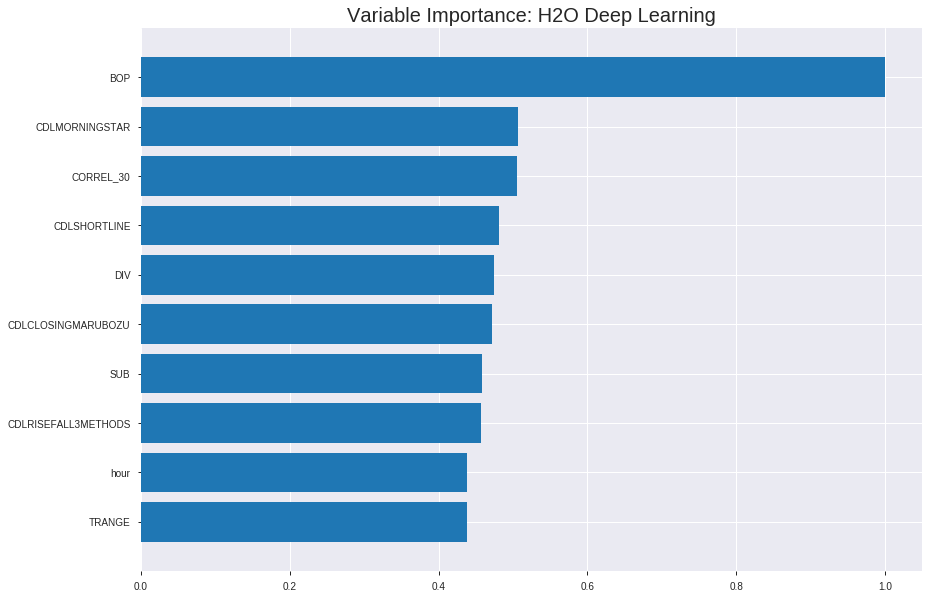

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190824_162013_model_2


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.19498263039274186
RMSE: 0.44156837567101864
LogLoss: 0.5830653808792647
Mean Per-Class Error: 0.28433385947331524
AUC: 0.7783718834807815
pr_auc: 0.7651217162006152
Gini: 0.5567437669615629
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3533857176991469: 


0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      1189  984   0.4528   (984.0/2173.0)
1      352   1788  0.1645   (352.0/2140.0)
Total  1541  2772  0.3098   (1336.0/4313.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.353386     0.728013  259
max f2                       0.0909342    0.839437  360
max f0point5                 0.497994     0.716253  195
max accuracy                 0.482197     0.715743  202
max precision                0.997339     0.974359  1
max recall                   0.00319132   1         397
max specificity              0.999282     0.99954   0
max absolute_mcc             0.482197     0.431486  202
max min_per_class_accuracy   0.468452     0.7133    208
max mean_per_class_accuracy  0.477933     0.715666  204

Gains/Lift Table: Avg response rate: 49.62 %, avg score: 48.84 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102017                   0.995956           1.96962   1.96962            0.977273         0.998348   0.977273                    0.998348            0.0200935       0.0200935                  96.9616   96.9616
    2        0.0201716                   0.991533           1.92168   1.94592            0.953488         0.993684   0.965517                    0.996043            0.0191589       0.0392523                  92.168    94.5923
    3        0.0301414                   0.984267           1.87481   1.9224             0.930233         0.987482   0.953846                    0.993211            0.0186916       0.0579439                  87.481    92.2401
    4        0.0401113                   0.973778           1.78107   1.88727            0.883721         0.978814   0.936416                    0.989633            0.017757        0.0757009                  78.1069   88.7272
    5        0.0500812                   0.965379           1.92168   1.89412            0.953488         0.969915   0.939815                    0.985707            0.0191589       0.0948598                  92.168    89.4122
    6        0.100162                    0.916923           1.75416   1.82414            0.87037          0.942879   0.905093                    0.964293            0.0878505       0.18271                    75.4162   82.4142
    7        0.150012                    0.857641           1.63108   1.75999            0.809302         0.886478   0.873261                    0.938435            0.0813084       0.264019                   63.1085   75.9989
    8        0.200093                    0.799734           1.56755   1.71182            0.777778         0.827978   0.849363                    0.910789            0.0785047       0.342523                   56.7549   71.1823
    9        0.300023                    0.683574           1.30465   1.5762             0.647332         0.744202   0.782071                    0.855303            0.130374        0.472897                   30.4646   57.6202
    10       0.399954                    0.564044           1.27191   1.50017            0.63109          0.619328   0.744348                    0.796343            0.127103        0.6                        27.1913   50.0174
    11       0.500116                    0.466129           1.13367   1.42677            0.5625           0.512128   0.707928                    0.739421            0.113551        0.713551                   13.3674   42.6772
    12       0.600046                    0.38846            0.865088  1.33323            0.429234         0.426243   0.661515                    0.687265            0.0864486       0.8                        -13.4912  33.323
    13       0.699977                    0.292096           0.743508  1.24904            0.36891          0.342441   0.619742                    0.638037            0.0742991       0.874299                   -25.6492  24.904
    14       0.799907                    0.189404           0.5097    1.15668            0.2529           0.242239   0.573913                    0.588591            0.0509346       0.925234                   -49.03    15.6676
    15       0.899838                    0.0860641          0.505024  1.08431            0.25058          0.138961   0.538006                    0.538658            0.0504673       0.975701                   -49.4976  8.43077
    16       1                           2.22678e-07        0.242597  1                  0.12037          0.0372854  0.496174                    0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.22042349126985425
RMSE: 0.4694928021491429
LogLoss: 0.6517864625405062
Mean Per-Class Error: 0.33864642631246045
AUC: 0.7165032679738562
pr_auc: 0.699247883565498
Gini: 0.43300653594771243
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.30899734942720175: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      258  362  0.5839   (362.0/620.0)
1      91   521  0.1487   (91.0/612.0)
Total  349  883  0.3677   (453.0/1232.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.308997     0.69699   280
max f2                       0.0227042    0.835162  390
max f0point5                 0.495669     0.660237  189
max accuracy                 0.387924     0.660714  242
max precision                0.9909       0.916667  4
max recall                   0.00161253   1         398
max specificity              0.999218     0.998387  0
max absolute_mcc             0.387924     0.329003  242
max min_per_class_accuracy   0.442455     0.647059  213
max mean_per_class_accuracy  0.387924     0.661354  242

Gains/Lift Table: Avg response rate: 49.68 %, avg score: 45.89 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105519                   0.986931           1.70337   1.70337            0.846154         0.99432    0.846154                    0.99432             0.0179739       0.0179739                  70.3369   70.3369
    2        0.0202922                   0.970211           1.67756   1.69098            0.833333         0.977298   0.84                        0.98615             0.0163399       0.0343137                  67.756    69.098
    3        0.0300325                   0.954004           1.84532   1.74104            0.916667         0.962531   0.864865                    0.978489            0.0179739       0.0522876                  84.5316   74.1035
    4        0.0405844                   0.938893           1.54852   1.69098            0.769231         0.946437   0.84                        0.970156            0.0163399       0.0686275                  54.8517   69.098
    5        0.0503247                   0.919305           2.01307   1.75332            1                0.929194   0.870968                    0.962228            0.0196078       0.0882353                  101.307   75.3321
    6        0.100649                    0.82634            1.42863   1.59098            0.709677         0.870178   0.790323                    0.916203            0.0718954       0.160131                   42.8632   59.0976
    7        0.150162                    0.761046           1.51805   1.56693            0.754098         0.794237   0.778378                    0.875987            0.0751634       0.235294                   51.8054   56.6932
    8        0.200487                    0.692857           1.42863   1.53222            0.709677         0.728538   0.761134                    0.838976            0.0718954       0.30719                    42.8632   53.2217
    9        0.300325                    0.580225           1.32568   1.46356            0.658537         0.632141   0.727027                    0.770217            0.132353        0.439542                   32.5681   46.3558
    10       0.400162                    0.508204           1.14565   1.38424            0.569106         0.542403   0.687627                    0.713379            0.114379        0.553922                   14.5651   38.4242
    11       0.5                         0.440895           0.949253  1.29739            0.471545         0.472148   0.644481                    0.665211            0.0947712       0.648693                   -5.07466  29.7386
    12       0.599838                    0.385669           1.12928   1.26941            0.560976         0.414837   0.630582                    0.623539            0.112745        0.761438                   12.9284   26.9407
    13       0.699675                    0.317601           0.73649   1.19336            0.365854         0.352598   0.592807                    0.584878            0.0735294       0.834967                   -26.351   19.3364
    14       0.799513                    0.22996            0.703757  1.13223            0.349593         0.273712   0.562437                    0.546022            0.0702614       0.905229                   -29.6243  13.2225
    15       0.899351                    0.108508           0.605558  1.07376            0.300813         0.173301   0.533394                    0.504646            0.0604575       0.965686                   -39.4442  7.37595
    16       1                           8.96748e-06        0.340923  1                  0.169355         0.0499719  0.496753                    0


Scoring History: 


timestamp            duration           training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  -----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 16:24:28  0.000 sec                            0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-24 16:24:30  4 min 11.058 sec   367 obs/sec       0.211917  1             914        0.596406         3.15886             -0.422886      0.641173        0.458297           1.32835          0.420357                         0.611714           4.99917               -0.496839        0.634322          0.312624             1.15752            0.443994
    2019-08-24 16:25:04  4 min 44.535 sec   425 obs/sec       3.24739   15            14006      0.515211         0.792323            -0.061831      0.675587        0.650826           1.64898          0.405982                         0.511157           0.754155              -0.0451692       0.645933          0.627186             1.39367            0.431006
    2019-08-24 16:25:34  5 min 15.037 sec   445 obs/sec       6.24507   29            26935      0.502718         0.743251            -0.010961      0.67017         0.663641           1.60318          0.447252                         0.490877           0.697655              0.0361173        0.680842          0.673618             1.70337            0.426948
    2019-08-24 16:26:05  5 min 46.006 sec   460 obs/sec       9.4134    44            40600      0.512464         0.80452             -0.0505401     0.711103        0.68599            1.87801          0.360538                         0.546701           0.874577              -0.195577        0.615175          0.622845             1.70337            0.478896
    2019-08-24 16:26:38  6 min 18.515 sec   478 obs/sec       13.0427   61            56253      0.470699         0.658867            0.113719       0.744347        0.722598           1.8322           0.368653                         0.489794           0.703765              0.0403655        0.684063          0.66937              1.70337            0.392045
    2019-08-24 16:27:08  6 min 49.111 sec   495 obs/sec       16.6673   78            71886      0.494458         0.737078            0.0219878      0.695993        0.699723           1.7864           0.424762                         0.474565           0.660307              0.0991148        0.719385          0.711599             1.70337            0.375812
    2019-08-24 16:27:39  7 min 19.971 sec   511 obs/sec       20.5061   96            88443      0.497982         0.764008            0.00799584     0.692607        0.659716           1.69479          0.396244                         0.527992           0.839014              -0.115151        0.63711           0.618759             1.70337            0.433442
    2019-08-24 16:28:11  7 min 51.231 sec   525 obs/sec       24.5054   115           105692     0.456636         0.622496            0.165885       0.761945        0.756943           1.92381          0.345003                         0.49583            0.74075               0.0165687        0.705843          0.690946             1.85822            0.373377
    2019-08-

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
BOP                       1.0                    1.0                  0.006986397504537038
CDLMORNINGSTAR            0.5061274766921997     0.5061274766921997   0.003536007740140012
CORREL_30                 0.5052734017372131     0.5052734017372131   0.003530040833005806
CDLSHORTLINE              0.4807756841182709     0.4807756841182709   0.003358890039765975
DIV                       0.4738892912864685     0.4738892912864685   0.0033107789620706093
---                       ---                    ---                  ---
BBANDS_middleband_30_7_2  0.09749911725521088    0.09749911725521088  0.0006811675894863693
BBANDS_middleband_14_2_3  0.09720180928707123    0.09720180928707123  0.0006790904778396795
BBANDS_middleband_20_5_4  0.09629509598016739    0.09629509598016739  0.000672755818254996
BBANDS_lowerband_12_5_2   0.09615310281515121    0.09615310281515121  0.0006717637975612658
BBANDS_middleband_30_6_2  0.09485071897506714    0.09485071897506714  0.0006626648263509529


See the whole table with table.as_data_frame()


('accuracy', 0.6952998379254457)

('F1', 0.7177177177177176)

('auc', 0.7343378937855957)

('logloss', 0.6342332387046692)

('mean_per_class_error', 0.30529811066977697)

('rmse', 0.46183820974434053)

('mse', 0.21329453197985748)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


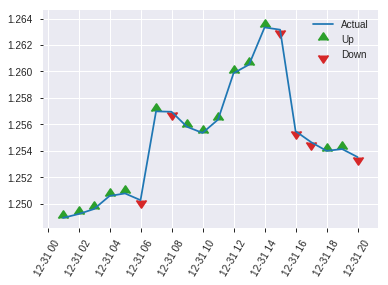


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.21329453197985748
RMSE: 0.46183820974434053
LogLoss: 0.6342332387046692
Mean Per-Class Error: 0.30529811066977697
AUC: 0.7343378937855957
pr_auc: 0.7126713703769594
Gini: 0.4686757875711913
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4547906964893846: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      190  116  0.3791   (116.0/306.0)
1      72   239  0.2315   (72.0/311.0)
Total  262  355  0.3047   (188.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.454791     0.717718  224
max f2                       0.172369     0.849269  337
max f0point5                 0.454791     0.690352  224
max accuracy                 0.454791     0.6953    224
max precision                0.950227     0.903226  22
max recall                   0.00746039   1         396
max specificity              0.999589     0.996732  0
max absolute_mcc             0.454791     0.393891  224
max min_per_class_accuracy   0.525282     0.679739  195
max mean_per_class_accuracy  0.454791     0.694702  224

Gains/Lift Table: Avg response rate: 50.41 %, avg score: 51.94 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.990142           1.41709   1.41709            0.714286         0.993982   0.714286                    0.993982            0.0160772       0.0160772                  41.7088   41.7088
    2        0.0210697                   0.978045           1.98392   1.6787             1                0.982997   0.846154                    0.988912            0.0192926       0.0353698                  98.3923   67.8704
    3        0.0307942                   0.964357           1.65327   1.67067            0.833333         0.96967    0.842105                    0.982835            0.0160772       0.0514469                  65.3269   67.0672
    4        0.0405186                   0.95458            1.98392   1.74585            1                0.960576   0.88                        0.977493            0.0192926       0.0707395                  98.3923   74.5852
    5        0.0502431                   0.949657           1.98392   1.79193            1                0.951911   0.903226                    0.972542            0.0192926       0.0900322                  98.3923   79.193
    6        0.100486                    0.894003           1.53594   1.66394            0.774194         0.922658   0.83871                     0.9476              0.0771704       0.167203                   53.594    66.3935
    7        0.150729                    0.841003           1.34395   1.55727            0.677419         0.871394   0.784946                    0.922198            0.0675241       0.234727                   34.3948   55.7273
    8        0.200972                    0.795666           1.21595   1.47194            0.612903         0.817648   0.741935                    0.89606             0.0610932       0.29582                    21.5953   47.1943
    9        0.299838                    0.697768           1.3985    1.44773            0.704918         0.751402   0.72973                     0.848362            0.138264        0.434084                   39.8503   44.7727
    10       0.400324                    0.618799           1.21595   1.38955            0.612903         0.659244   0.700405                    0.800891            0.122186        0.55627                    21.5953   38.9549
    11       0.50081                     0.525009           1.24795   1.36114            0.629032         0.573767   0.686084                    0.75532             0.125402        0.681672                   24.7951   36.1138
    12       0.599676                    0.422486           0.943176  1.29223            0.47541          0.476888   0.651351                    0.709416            0.0932476       0.77492                    -5.68236  29.2231
    13       0.700162                    0.346206           0.575978  1.18944            0.290323         0.382422   0.599537                    0.662486            0.0578778       0.832797                   -42.4022  18.9435
    14       0.799028                    0.258981           0.87813   1.15092            0.442623         0.298077   0.580122                    0.617397            0.0868167       0.919614                   -12.187   15.0917
    15       0.899514                    0.130841           0.575978  1.08669            0.290323         0.198078   0.547748                    0.570554            0.0578778       0.977492                   -42.4022  8.66893
    16       1                           1.43599e-05        0.223991  1                  0.112903         0.0611113  0.504052                    

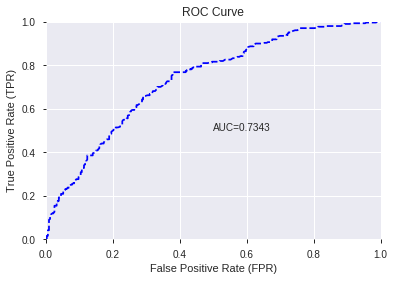

This function is available for GLM models only


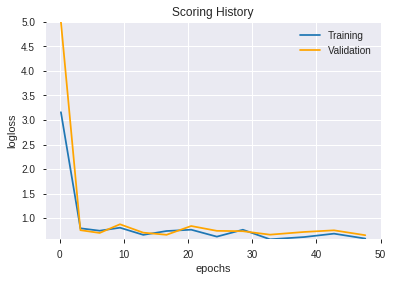

--2019-08-24 17:20:27--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.36.52
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.36.52|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190824_162013_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190824_162013_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_9a5d',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [11]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190824_172124_model_9  0.742003  0.600418              0.348990  0.455462  0.207445
1  DeepLearning_grid_1_AutoML_20190824_172124_model_6  0.740580  0.611306              0.312018  0.459120  0.210791
2  DeepLearning_grid_1_AutoML_20190824_172124_model_3  0.739403  0.697098              0.320608  0.472751  0.223494
3  DeepLearning_grid_1_AutoML_20190824_172124_model_8  0.737548  0.620155              0.333628  0.459833  0.211447
4  DeepLearning_grid_1_AutoML_20190824_172124_model_5  0.727965  0.618157              0.340321  0.463236  0.214588
5  DeepLearning_grid_1_AutoML_20190824_172124_model_4  0.722926  0.643302              0.325169  0.470584  0.221450
6  DeepLearning_grid_1_AutoML_20190824_172124_model_7  0.721213  0.716526              0.353551  0.480582  0.230959
7               DeepLearning_1_AutoML_20190824_172124  0.708157  0.676779              0.361484  0.483472  0.233745
8  DeepLearning_grid_1_AutoML_20190824_172124_model_1  0.707464  1.013574              0.369654  0.501327  0.251328
9  DeepLearning_grid_1_AutoML_20190824_172124_model_2  0.693740  0.750146              0.431136  0.485551  0.235760

variable  relative_importance  scaled_importance  percentage
0    CDLCLOSINGMARUBOZU             1.000000           1.000000    0.057533
1                   BOP             0.746363           0.746363    0.042941
2          CDLSHORTLINE             0.496321           0.496321    0.028555
3                  hour             0.431327           0.431327    0.024816
4     CDLINVERTEDHAMMER             0.410344           0.410344    0.023608
5             CDLHAMMER             0.397342           0.397342    0.022860
6     CDLSTALLEDPATTERN             0.386742           0.386742    0.022251
7             CDLTAKURI             0.373731           0.373731    0.021502
8       CDLHOMINGPIGEON             0.372629           0.372629    0.021439
9    CDLEVENINGDOJISTAR             0.371314           0.371314    0.021363
10     is_quarter_start             0.366853           0.366853    0.021106
11    CDLGRAVESTONEDOJI             0.366368           0.366368    0.021078
12            CDLONNECK             0.364529           0.364529    0.020973
13       CDLMORNINGSTAR             0.363993           0.363993    0.020942
14          CDLPIERCING             0.363975           0.363975    0.020941
15                  SUB             0.363091           0.363091    0.020890
16  CDLRISEFALL3METHODS             0.362955           0.362955    0.020882
17         CDLTHRUSTING             0.360587           0.360587    0.020746
18   CDLMORNINGDOJISTAR             0.360250           0.360250    0.020726
19   CDLIDENTICAL3CROWS             0.357124           0.357124    0.020547
20                  DIV             0.356297           0.356297    0.020499
21            CDLINNECK             0.355192           0.355192    0.020435
22  CDLGAPSIDESIDEWHITE             0.352407           0.352407    0.020275
23    CDLDARKCLOUDCOVER             0.348480           0.348480    0.020049
24               TRANGE             0.340182           0.340182    0.019572
25         is_month_end             0.334078           0.334078    0.019221
26            CORREL_30             0.317764           0.317764    0.018282
27        CDLHIKKAKEMOD             0.310042           0.310042    0.017838
28      CDLUNIQUE3RIVER             0.309857           0.309857    0.017827
29         HT_TRENDMODE             0.301607           0.301607    0.017352
30              quarter             0.300362           0.300362    0.017281
31               Volume             0.300011           0.300011    0.017261
32            CORREL_24             0.299549           0.299549    0.017234
33      CDLADVANCEBLOCK             0.297759           0.297759    0.017131
34         STOCHF_fastk             0.297424           0.297424    0.017112
35         aroondown_12             0.294205           0.294205    0.016927
36               ULTOSC             0.289480           0.289480    0.016655
37           aroonup_20             0.288126           0.288126    0.016577
38                CCI_8             0.286304           0.286304    0.016472
39          HT_DCPERIOD             0.277467           0.277467    0.015964
40               SAREXT             0.272898           0.272898    0.015701
41                  day             0.264131           0.264131    0.015196
42       STOCHRSI_fastk             0.260683           0.260683    0.014998
43           aroonup_12             0.258900           0.258900    0.014895
44            aroonup_8             0.252600           0.252600    0.014533
45         aroondown_30             0.247506           0.247506    0.014240
46         aroondown_24             0.243456           0.243456    0.014007
47                   AD             0.242331           0.242331    0.013942
48          aroondown_8             0.236530           0.236530    0.013608
49           aroonup_14             0.229739           0.229739    0.013218

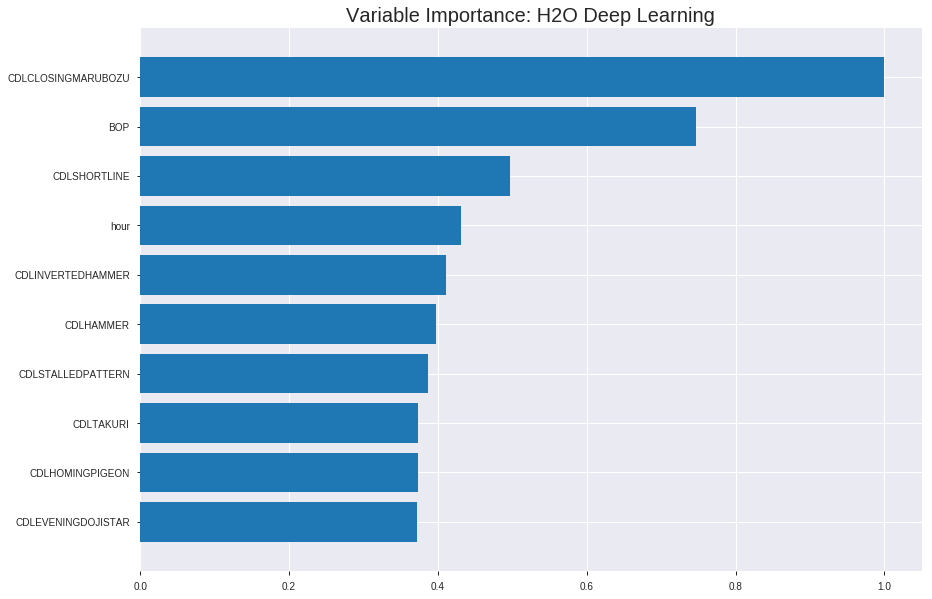

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190824_172124_model_9


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.1934324300643793
RMSE: 0.4398095383963146
LogLoss: 0.568831516848028
Mean Per-Class Error: 0.291920489783279
AUC: 0.7796941865116059
pr_auc: 0.7779690690190623
Gini: 0.5593883730232119
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3905017063615259: 


0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      1015  1158  0.5329   (1158.0/2173.0)
1      251   1889  0.1173   (251.0/2140.0)
Total  1266  3047  0.3267   (1409.0/4313.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.390502     0.728359  270
max f2                       0.200614     0.83572   355
max f0point5                 0.642471     0.718643  144
max accuracy                 0.564302     0.708324  182
max precision                0.995151     1         0
max recall                   0.0835223    1         393
max specificity              0.995151     1         0
max absolute_mcc             0.600772     0.418548  164
max min_per_class_accuracy   0.54183      0.704096  194
max mean_per_class_accuracy  0.564302     0.70808   182

Gains/Lift Table: Avg response rate: 49.62 %, avg score: 53.87 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102017                   0.961673           2.01542   2.01542            1                0.970277  1                           0.970277            0.0205607       0.0205607                  101.542   101.542
    2        0.0201716                   0.9562             1.96855   1.99225            0.976744         0.958904  0.988506                    0.964656            0.0196262       0.0401869                  96.855    99.2255
    3        0.0301414                   0.948715           1.87481   1.95341            0.930233         0.95285   0.969231                    0.960751            0.0186916       0.0588785                  87.481    95.3408
    4        0.0401113                   0.940301           1.87481   1.93387            0.930233         0.944609  0.959538                    0.956738            0.0186916       0.0775701                  87.481    93.3872
    5        0.0500812                   0.926108           1.82794   1.91278            0.906977         0.933595  0.949074                    0.952131            0.0182243       0.0957944                  82.794    91.2783
    6        0.100162                    0.828018           1.70751   1.81015            0.847222         0.868199  0.898148                    0.910165            0.085514        0.181308                   70.7509   81.0146
    7        0.150012                    0.794543           1.63108   1.75064            0.809302         0.811476  0.868624                    0.87737             0.0813084       0.262617                   63.1085   75.0644
    8        0.200093                    0.762959           1.55822   1.70248            0.773148         0.779065  0.844728                    0.852766            0.0780374       0.340654                   55.8219   70.2482
    9        0.300023                    0.688796           1.4122    1.60579            0.700696         0.73107   0.796754                    0.812232            0.141121        0.481776                   41.2197   60.5795
    10       0.399954                    0.606618           1.22983   1.51186            0.610209         0.644768  0.750145                    0.77039             0.122897        0.604673                   22.9827   51.1858
    11       0.500116                    0.540372           1.01238   1.41182            0.502315         0.572685  0.70051                     0.730794            0.101402        0.706075                   1.23756   41.1822
    12       0.600046                    0.467734           0.902497  1.327              0.447796         0.504777  0.658423                    0.693154            0.0901869       0.796262                   -9.75031  32.7
    13       0.699977                    0.394783           0.799622  1.25171            0.396752         0.432039  0.621067                    0.655876            0.0799065       0.876168                   -20.0378  25.171
    14       0.799907                    0.313805           0.579843  1.16778            0.287703         0.355582  0.57942                     0.618361            0.0579439       0.934112                   -42.0157  16.7776
    15       0.899838                    0.229726           0.355387  1.07756            0.176334         0.271448  0.534656                    0.579835            0.035514        0.969626                   -64.4613  7.75567
    16       1                           0.0389485          0.303246  1                  0.150463         0.16887   0.496174                    0.538672            0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2071579789375167
RMSE: 0.45514610724196763
LogLoss: 0.5988001335252594
Mean Per-Class Error: 0.32388256377819946
AUC: 0.7375816993464052
pr_auc: 0.7331559951879844
Gini: 0.4751633986928103
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.38084454342495244: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      331  289  0.4661   (289.0/620.0)
1      119  493  0.1944   (119.0/612.0)
Total  450  782  0.3312   (408.0/1232.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.380845     0.707317  253
max f2                       0.134036     0.837675  378
max f0point5                 0.555512     0.681077  161
max accuracy                 0.513825     0.676136  183
max precision                0.965704     1         0
max recall                   0.103552     1         387
max specificity              0.965704     1         0
max absolute_mcc             0.513825     0.354778  183
max min_per_class_accuracy   0.468414     0.673203  206
max mean_per_class_accuracy  0.468414     0.676117  206

Gains/Lift Table: Avg response rate: 49.68 %, avg score: 48.31 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105519                   0.949457           1.85822   1.85822            0.923077         0.956205  0.923077                    0.956205            0.0196078       0.0196078                  85.822    85.822
    2        0.0202922                   0.941417           2.01307   1.93255            1                0.945403  0.96                        0.95102             0.0196078       0.0392157                  101.307   93.2549
    3        0.0300325                   0.930675           2.01307   1.95866            1                0.936561  0.972973                    0.946331            0.0196078       0.0588235                  101.307   95.8665
    4        0.0405844                   0.917843           1.85822   1.93255            0.923077         0.923829  0.96                        0.94048             0.0196078       0.0784314                  85.822    93.2549
    5        0.0503247                   0.903601           2.01307   1.94813            1                0.910615  0.967742                    0.9347              0.0196078       0.0980392                  101.307   94.8134
    6        0.100649                    0.769654           1.42863   1.68838            0.709677         0.819191  0.83871                     0.876946            0.0718954       0.169935                   42.8632   68.8383
    7        0.150162                    0.730191           1.38605   1.58869            0.688525         0.750455  0.789189                    0.835238            0.0686275       0.238562                   38.605    58.8695
    8        0.200487                    0.687072           1.59098   1.58927            0.790323         0.707541  0.789474                    0.803184            0.0800654       0.318627                   59.0976   58.9267
    9        0.300325                    0.593796           1.32568   1.50164            0.658537         0.639193  0.745946                    0.748668            0.132353        0.45098                    32.5681   50.1643
    10       0.400162                    0.534598           1.16202   1.41691            0.577236         0.566604  0.703854                    0.703245            0.116013        0.566993                   16.2017   41.6909
    11       0.5                         0.465369           1.08018   1.34967            0.536585         0.498893  0.670455                    0.662441            0.107843        0.674837                   8.01849   34.9673
    12       0.599838                    0.402795           0.916521  1.27758            0.455285         0.433578  0.634641                    0.624348            0.0915033       0.76634                    -8.34795  27.7579
    13       0.699675                    0.343804           0.801955  1.20971            0.398374         0.372235  0.600928                    0.588374            0.0800654       0.846405                   -19.8045  20.9711
    14       0.799513                    0.283063           0.589192  1.13223            0.292683         0.315014  0.562437                    0.554239            0.0588235       0.905229                   -41.0808  13.2225
    15       0.899351                    0.204455           0.654658  1.07921            0.325203         0.245679  0.536101                    0.519985            0.0653595       0.970588                   -34.5342  7.921
    16       1                           0.0331215          0.29222   1                  0.145161         0.153998  0.496753                    0.483149            


Scoring History: 


timestamp            duration           training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  -----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 17:35:23  0.000 sec                            0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-24 17:35:26  6 min 35.256 sec   507 obs/sec       0.275214  1             1187       0.550726         0.997593            -0.213267      0.731576        0.711703           1.8322           0.352191                         0.558441           1.02153               -0.247479        0.722853          0.714076             1.85822            0.364448
    2019-08-24 17:36:09  7 min 18.985 sec   671 obs/sec       6.46      23            27862      0.453072         0.598123            0.178856       0.764048        0.758061           1.92381          0.335265                         0.459838           0.612142              0.154159         0.739342          0.725149             1.70337            0.32711
    2019-08-24 17:36:55  8 min  5.322 sec   797 obs/sec       15.4368   55            66579      0.442882         0.575993            0.215375       0.768299        0.765271           1.92381          0.338511                         0.457797           0.605959              0.161652         0.737725          0.725239             1.70337            0.353896
    2019-08-24 17:37:39  8 min 49.309 sec   868 obs/sec       24.795    88            106941     0.442406         0.574938            0.217063       0.772829        0.769885           1.96962          0.319499                         0.459049           0.607281              0.157062         0.736086          0.728023             1.70337            0.338474
    2019-08-24 17:38:24  9 min 34.054 sec   929 obs/sec       35.207    125           151848     0.43981          0.568832            0.226225       0.779694        0.777969           2.01542          0.326687                         0.455146           0.5988                0.171333         0.737582          0.733156             1.85822            0.331169
    2019-08-24 17:39:10  10 min 19.622 sec  970 obs/sec       45.9764   163           198296     0.435845         0.561189            0.240111       0.784077        0.781531           1.96962          0.299559                         0.458689           0.605938              0.158381         0.733996          0.727154             1.70337            0.344156
    2019-08-24 17:39:54  11 min  4.411 sec  994 obs/sec       56.4435   200           243441     0.433188         0.556304            0.24935        0.789686        0.787274           2.01542          0.309066                         0.460564           0.609306              0.151486         0.734403          0.727331             1.85822            0.368506
    2019-08-24 17:39:59  11 min  8.964 sec  994 obs/sec       56.4435   200           243441     0.43981          0.568832            0.226225       0.779694        0.777969           2.01542          0.326687                         0.455146           0.5988                0.171333         0.737582          0.733156             1.85822            0.331169

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
CDLCLOSINGMARUBOZU  1.0                    1.0                  0.057533412368256605
BOP                 0.7463633418083191     0.7463633418083191   0.04294082992080808
CDLSHORTLINE        0.4963209331035614     0.4963209331035614   0.0285550369112451
hour                0.4313267767429352     0.4313267767429352   0.024815701311822244
CDLINVERTEDHAMMER   0.41034412384033203    0.41034412384033203  0.02360849768979678
---                 ---                    ---                  ---
aroondown_30        0.24750562012195587    0.24750562012195587  0.014239842905937557
aroondown_24        0.2434556633234024     0.2434556633234024   0.014006835071372757
AD                  0.24233141541481018    0.24233141541481018  0.01394215325284357
aroondown_8         0.23653002083301544    0.23653002083301544  0.013608379226058204
aroonup_14          0.22973884642124176    0.22973884642124176  0.013217659788160876


See the whole table with table.as_data_frame()


('accuracy', 0.6839546191247974)

('F1', 0.7270408163265307)

('auc', 0.7420034466090831)

('logloss', 0.6004182750937017)

('mean_per_class_error', 0.31576403337326364)

('rmse', 0.4554616273323907)

('mse', 0.20744529397226957)

deeplearning prediction progress: |███████████████████████████████████████| 100%


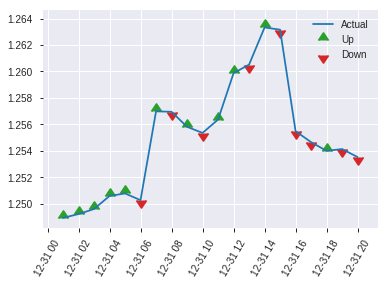


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.20744529397226957
RMSE: 0.4554616273323907
LogLoss: 0.6004182750937017
Mean Per-Class Error: 0.31576403337326364
AUC: 0.7420034466090831
pr_auc: 0.7354737726861711
Gini: 0.48400689321816626
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.277670099249165: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      118  188  0.6144   (188.0/306.0)
1      26   285  0.0836   (26.0/311.0)
Total  144  473  0.3468   (214.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.27767      0.727041  301
max f2                       0.213061     0.847363  337
max f0point5                 0.520602     0.691295  172
max accuracy                 0.469531     0.683955  191
max precision                0.976135     1         0
max recall                   0.0641415    1         397
max specificity              0.976135     1         0
max absolute_mcc             0.469531     0.369276  191
max min_per_class_accuracy   0.442451     0.673203  206
max mean_per_class_accuracy  0.469531     0.684236  191

Gains/Lift Table: Avg response rate: 50.41 %, avg score: 47.51 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.956528           1.98392   1.98392            1                0.963611  1                           0.963611            0.022508        0.022508                   98.3923   98.3923
    2        0.0210697                   0.945259           1.98392   1.98392            1                0.950176  1                           0.95741             0.0192926       0.0418006                  98.3923   98.3923
    3        0.0307942                   0.934671           1.65327   1.87951            0.833333         0.941092  0.947368                    0.952257            0.0160772       0.0578778                  65.3269   87.9506
    4        0.0405186                   0.924773           1.65327   1.82521            0.833333         0.930358  0.92                        0.947001            0.0160772       0.073955                   65.3269   82.5209
    5        0.0502431                   0.917842           1.98392   1.85593            1                0.922316  0.935484                    0.942224            0.0192926       0.0932476                  98.3923   85.5928
    6        0.100486                    0.782503           1.47194   1.66394            0.741935         0.841528  0.83871                     0.891876            0.073955        0.167203                   47.1943   66.3935
    7        0.150729                    0.733953           1.40795   1.57861            0.709677         0.756465  0.795699                    0.846739            0.0707395       0.237942                   40.7945   57.8605
    8        0.200972                    0.689662           1.40795   1.53594            0.709677         0.713301  0.774194                    0.813379            0.0707395       0.308682                   40.7945   53.594
    9        0.299838                    0.611115           1.3985    1.49062            0.704918         0.652488  0.751351                    0.760329            0.138264        0.446945                   39.8503   49.0623
    10       0.400324                    0.544985           1.21595   1.42168            0.612903         0.576985  0.716599                    0.714307            0.122186        0.569132                   21.5953   42.1677
    11       0.50081                     0.443401           1.02396   1.34188            0.516129         0.490557  0.676375                    0.669412            0.102894        0.672026                   2.39602   34.1877
    12       0.599676                    0.379732           0.943176  1.27614            0.47541          0.410108  0.643243                    0.626662            0.0932476       0.765273                   -5.68236  27.6145
    13       0.700162                    0.314607           0.863966  1.21699            0.435484         0.346043  0.613426                    0.586388            0.0868167       0.85209                    -13.6034  21.699
    14       0.799028                    0.263784           0.715513  1.15494            0.360656         0.287133  0.58215                     0.549361            0.0707395       0.92283                    -28.4487  15.4941
    15       0.899514                    0.199803           0.51198   1.08311            0.258065         0.227558  0.545946                    0.513412            0.0514469       0.974277                   -48.802   8.31146
    16       1                           0.0172044          0.25599   1                  0.129032         0.132005  0.504052                    0.475085           

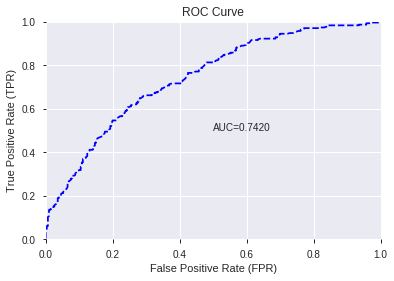

This function is available for GLM models only


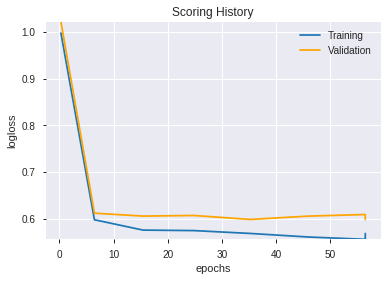

--2019-08-24 17:40:15--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.37.220
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.37.220|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190824_172124_model_9',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190824_172124_model_9',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_9a5d',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLCLOSINGMARUBOZU',
 'BOP',
 'CDLSHORTLINE',
 'hour',
 'CDLINVERTEDHAMMER',
 'CDLHAMMER',
 'CDLSTALLEDPATTERN',
 'CDLTAKURI',
 'CDLHOMINGPIGEON',
 'CDLEVENINGDOJISTAR',
 'is_quarter_start',
 'CDLGRAVESTONEDOJI',
 'CDLONNECK',
 'CDLMORNINGSTAR',
 'CDLPIERCING',
 'SUB',
 'CDLRISEFALL3METHODS',
 'CDLTHRUSTING',
 'CDLMORNINGDOJISTAR',
 'CDLIDENTICAL3CROWS',
 'DIV',
 'CDLINNECK',
 'CDLGAPSIDESIDEWHITE',
 'CDLDARKCLOUDCOVER',
 'TRANGE',
 'is_month_end',
 'CORREL_30',
 'CDLHIKKAKEMOD',
 'CDLUNIQUE3RIVER',
 'HT_TRENDMODE',
 'quarter',
 'Volume',
 'CORREL_24',
 'CDLADVANCEBLOCK',
 'STOCHF_fastk',
 'aroondown_12',
 'ULTOSC',
 'aroonup_20',
 'CCI_8',
 'HT_DCPERIOD',
 'SAREXT',
 'day',
 'STOCHRSI_fastk',
 'aroonup_12',
 'aroonup_8',
 'aroondown_30',
 'aroondown_24',
 'AD',
 'aroondown_8',
 'aroonup_14']

In [12]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190824_174112_model_1  0.737469  0.615263              0.355421  0.461414  0.212903

variable  relative_importance  scaled_importance  percentage
0                   BOP             0.416078           1.000000    0.156055
1    CDLCLOSINGMARUBOZU             0.192194           0.461919    0.072085
2          STOCHF_fastk             0.135585           0.325864    0.050853
3             CDLHAMMER             0.112161           0.269568    0.042067
4        STOCHRSI_fastk             0.098492           0.236716    0.036941
5                   SUB             0.094365           0.226797    0.035393
6                   DIV             0.093072           0.223689    0.034908
7                TRANGE             0.091654           0.220281    0.034376
8             CDLTAKURI             0.091613           0.220181    0.034360
9          CDLSHORTLINE             0.089493           0.215087    0.033565
10                CCI_8             0.083611           0.200951    0.031359
11               ULTOSC             0.080394           0.193218    0.030153
12              quarter             0.070889           0.170373    0.026588
13    CDLGRAVESTONEDOJI             0.070087           0.168447    0.026287
14       CDLMORNINGSTAR             0.064222           0.154350    0.024087
15           aroonup_20             0.058143           0.139739    0.021807
16               Volume             0.048316           0.116121    0.018121
17                  day             0.046763           0.112390    0.017539
18            CDLONNECK             0.045795           0.110063    0.017176
19                 hour             0.044620           0.107240    0.016735
20               SAREXT             0.042998           0.103340    0.016127
21           aroonup_12             0.042448           0.102020    0.015921
22   CDLIDENTICAL3CROWS             0.042214           0.101456    0.015833
23    CDLSTALLEDPATTERN             0.040114           0.096409    0.015045
24         aroondown_24             0.038312           0.092078    0.014369
25            aroonup_8             0.032508           0.078129    0.012192
26    CDLINVERTEDHAMMER             0.031278           0.075175    0.011731
27    CDLDARKCLOUDCOVER             0.030954           0.074394    0.011609
28            CORREL_24             0.029394           0.070645    0.011024
29         aroondown_12             0.028566           0.068655    0.010714
30  CDLGAPSIDESIDEWHITE             0.021604           0.051924    0.008103
31          aroondown_8             0.021326           0.051254    0.007998
32        CDLHIKKAKEMOD             0.020081           0.048262    0.007532
33           aroonup_14             0.019428           0.046692    0.007287
34      CDLADVANCEBLOCK             0.019065           0.045822    0.007151
35            CORREL_30             0.017548           0.042175    0.006582
36      CDLHOMINGPIGEON             0.017100           0.041097    0.006413
37      CDLUNIQUE3RIVER             0.016709           0.040158    0.006267
38  CDLRISEFALL3METHODS             0.014929           0.035880    0.005599
39                   AD             0.014020           0.033695    0.005258
40         CDLTHRUSTING             0.013707           0.032943    0.005141
41   CDLEVENINGDOJISTAR             0.013052           0.031369    0.004895
42            CDLINNECK             0.011700           0.028120    0.004388
43         is_month_end             0.011691           0.028098    0.004385
44         HT_TRENDMODE             0.011330           0.027230    0.004249
45         aroondown_30             0.009808           0.023573    0.003679
46          HT_DCPERIOD             0.009377           0.022536    0.003517
47   CDLMORNINGDOJISTAR             0.009275           0.022291    0.003479
48          CDLPIERCING             0.006684           0.016064    0.002507
49     is_quarter_start             0.001468           0.003527    0.000550

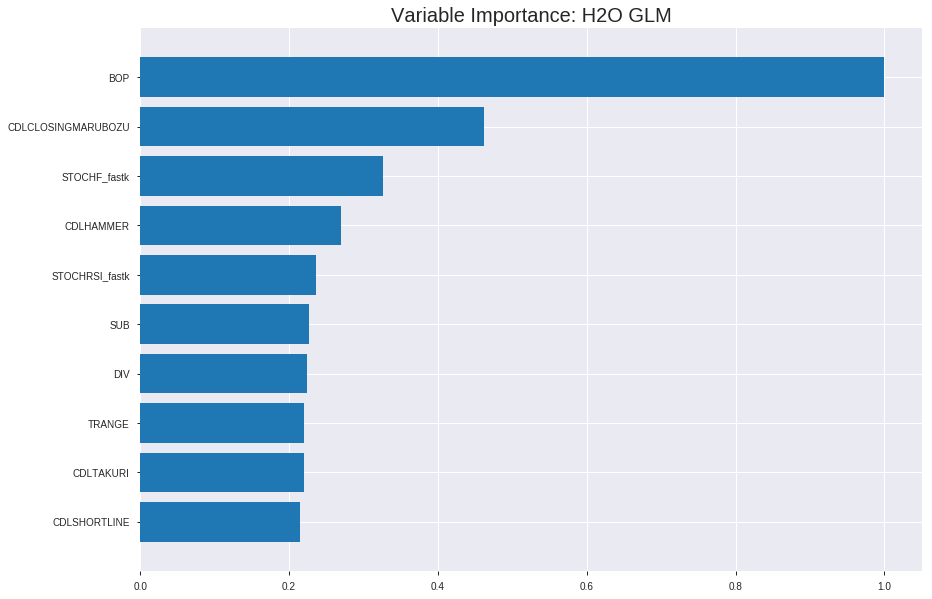

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190824_174112_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.20180171851644632
RMSE: 0.44922346167185695
LogLoss: 0.5900169914523389
Null degrees of freedom: 4312
Residual degrees of freedom: 4262
Null deviance: 5978.835084581811
Residual deviance: 5089.486568267876
AIC: 5191.486568267876
AUC: 0.7596868535252096
pr_auc: 0.7527962542692362
Gini: 0.5193737070504192
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3890811794549461: 


0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      1015  1158  0.5329   (1158.0/2173.0)
1      297   1843  0.1388   (297.0/2140.0)
Total  1312  3001  0.3374   (1455.0/4313.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.389081     0.716981  259
max f2                       0.244152     0.836269  337
max f0point5                 0.540531     0.700041  171
max accuracy                 0.510384     0.696963  189
max precision                0.908603     1         0
max recall                   0.088586     1         393
max specificity              0.908603     1         0
max absolute_mcc             0.510384     0.393863  189
max min_per_class_accuracy   0.506604     0.69486   191
max mean_per_class_accuracy  0.510384     0.696897  189

Gains/Lift Table: Avg response rate: 49.62 %, avg score: 49.62 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102017                   0.832983           1.87801   1.87801            0.931818         0.856517  0.931818                    0.856517            0.0191589       0.0191589                  87.8006   87.8006
    2        0.0201716                   0.81302            1.87481   1.87643            0.930233         0.823464  0.931034                    0.84018             0.0186916       0.0378505                  87.481    87.6426
    3        0.0301414                   0.7966             1.92168   1.89139            0.953488         0.80409   0.938462                    0.828243            0.0191589       0.0570093                  92.168    89.1395
    4        0.0401113                   0.785648           1.7342    1.85232            0.860465         0.791013  0.919075                    0.818989            0.0172897       0.0742991                  73.4199   85.2323
    5        0.0500812                   0.771701           1.78107   1.83814            0.883721         0.778379  0.912037                    0.810905            0.017757        0.0920561                  78.1069   83.8138
    6        0.100162                    0.726469           1.70751   1.77282            0.847222         0.746738  0.87963                     0.778821            0.085514        0.17757                    70.7509   77.2824
    7        0.150012                    0.691215           1.61234   1.71949            0.8              0.707928  0.853168                    0.755263            0.0803738       0.257944                   61.2336   71.9493
    8        0.200093                    0.663017           1.45558   1.65344            0.722222         0.677792  0.820394                    0.735873            0.0728972       0.330841                   45.5582   65.3439
    9        0.300023                    0.610833           1.32335   1.54349            0.656613         0.637101  0.765842                    0.702974            0.132243        0.463084                   32.335    54.3494
    10       0.399954                    0.561751           1.2345    1.46629            0.612529         0.587112  0.727536                    0.674025            0.123364        0.586449                   23.4504   46.6291
    11       0.500116                    0.504401           1.11501   1.39594            0.553241         0.533654  0.692629                    0.645912            0.111682        0.698131                   11.5013   39.5938
    12       0.600046                    0.44445            0.837031  1.30286            0.415313         0.474373  0.646445                    0.617344            0.0836449       0.781776                   -16.2969  30.2859
    13       0.699977                    0.38581            0.804298  1.23168            0.399072         0.415783  0.61113                     0.588569            0.0803738       0.86215                    -19.5702  23.1683
    14       0.799907                    0.331092           0.621928  1.15551            0.308585         0.358535  0.573333                    0.559831            0.0621495       0.924299                   -37.8072  15.5508
    15       0.899838                    0.255583           0.462939  1.0786             0.229698         0.295746  0.535171                    0.530504            0.0462617       0.970561                   -53.7061  7.85953
    16       1                           0.0444519          0.293915  1                  0.145833         0.187768  0.496174                    0.496174         



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.21152646582321497
RMSE: 0.4599200646016816
LogLoss: 0.6108289605505255
Null degrees of freedom: 1231
Residual degrees of freedom: 1181
Null deviance: 1707.8643560108549
Residual deviance: 1505.0825587964948
AIC: 1607.0825587964948
AUC: 0.7359701138519924
pr_auc: 0.7218297132108871
Gini: 0.4719402277039848
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3447926738740435: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      301  319  0.5145   (319.0/620.0)
1      100  512  0.1634   (100.0/612.0)
Total  401  831  0.3401   (419.0/1232.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.344793     0.709633  265
max f2                       0.181179     0.837029  360
max f0point5                 0.51005      0.68127   163
max accuracy                 0.453416     0.678571  194
max precision                0.80119      0.952381  13
max recall                   0.123549     1         382
max specificity              0.867758     0.998387  0
max absolute_mcc             0.453416     0.357431  194
max min_per_class_accuracy   0.440124     0.674194  203
max mean_per_class_accuracy  0.453416     0.678379  194

Gains/Lift Table: Avg response rate: 49.68 %, avg score: 44.55 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105519                   0.806466           1.85822   1.85822            0.923077         0.828613  0.923077                    0.828613            0.0196078       0.0196078                  85.822    85.822
    2        0.0202922                   0.790956           1.84532   1.85203            0.916667         0.801266  0.92                        0.815487            0.0179739       0.0375817                  84.5316   85.2026
    3        0.0300325                   0.773956           1.84532   1.84985            0.916667         0.781676  0.918919                    0.804521            0.0179739       0.0555556                  84.5316   84.985
    4        0.0405844                   0.756993           1.70337   1.81176            0.846154         0.765934  0.9                         0.794488            0.0179739       0.0735294                  70.3369   81.1765
    5        0.0503247                   0.741641           1.67756   1.78579            0.833333         0.747581  0.887097                    0.78541             0.0163399       0.0898693                  67.756    78.579
    6        0.100649                    0.677374           1.52604   1.65591            0.758065         0.703035  0.822581                    0.744222            0.0767974       0.166667                   52.6038   65.5914
    7        0.150162                    0.644216           1.65006   1.65398            0.819672         0.660181  0.821622                    0.716512            0.0816993       0.248366                   65.0059   65.3983
    8        0.200487                    0.61147            1.26629   1.55667            0.629032         0.625853  0.773279                    0.693755            0.0637255       0.312092                   26.6287   55.6667
    9        0.300325                    0.549562           1.40751   1.50708            0.699187         0.579388  0.748649                    0.655736            0.140523        0.452614                   40.7514   50.7084
    10       0.400162                    0.49661            1.21112   1.43324            0.601626         0.523111  0.711968                    0.622647            0.120915        0.573529                   21.1116   43.3242
    11       0.5                         0.439011           1.03109   1.35294            0.512195         0.464616  0.672078                    0.591092            0.102941        0.676471                   3.10856   35.2941
    12       0.599838                    0.384211           0.916521  1.2803             0.455285         0.411919  0.635995                    0.56127             0.0915033       0.767974                   -8.34795  28.0303
    13       0.699675                    0.334611           0.785589  1.20971            0.390244         0.358879  0.600928                    0.532391            0.0784314       0.846405                   -21.4411  20.9711
    14       0.799513                    0.288381           0.605558  1.13427            0.300813         0.311508  0.563452                    0.504808            0.0604575       0.906863                   -39.4442  13.4269
    15       0.899351                    0.221876           0.605558  1.07558            0.300813         0.256135  0.534296                    0.477203            0.0604575       0.96732                    -39.4442  7.55763
    16       1                           0.0333974          0.324689  1                  0.16129          0.162277  0.496753                    0.445506            


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-24 17:41:13  0.000 sec   2            20        47            1.37432           1.37455
    2019-08-24 17:41:13  0.069 sec   4            12        48            1.36774           1.36812
    2019-08-24 17:41:13  0.118 sec   6            7.6       49            1.35808           1.35875
    2019-08-24 17:41:13  0.156 sec   8            4.7       50            1.3445            1.34568
    2019-08-24 17:41:13  0.189 sec   10           2.9       51            1.32659           1.3287
    2019-08-24 17:41:14  0.230 sec   12           1.8       51            1.3047            1.3084
    2019-08-24 17:41:14  0.269 sec   14           1.1       51            1.28018           1.28646
    2019-08-24 17:41:14  0.304 sec   16           0.7       51            1.25509           1.26527
    2019-08-24 17:41:14  0.337 sec   18           0.44      51            1.2314            1.24711
    2019-08-24 17:41:14  0.364 sec   20           0.27      51            1.21062           1.23358
    2019-08-24 17:41:14  0.396 sec   22           0.17      51            1.19345           1.22522
    2019-08-24 17:41:14  0.419 sec   24           0.1       51            1.18003           1.22166
    2019-08-24 17:41:14  0.450 sec   26           0.065     51            1.17011           1.22191
    2019-08-24 17:41:14  0.482 sec   28           0.04      51            1.16323           1.22479
    2019-08-24 17:41:14  0.512 sec   30           0.025     51            1.15881           1.22914
    2019-08-24 17:41:14  0.543 sec   32           0.016     51            1.15617           1.23399
    2019-08-24 17:41:14  0.578 sec   34           0.0096    51            1.15472           1.23867

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6823338735818476)

('F1', 0.7205128205128205)

('auc', 0.7374692642330244)

('logloss', 0.6152627363845873)

('mean_per_class_error', 0.3170039720068092)

('rmse', 0.46141424759489863)

('mse', 0.21290310788356642)

glm prediction progress: |████████████████████████████████████████████████| 100%


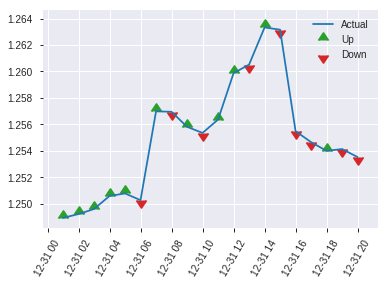


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.21290310788356642
RMSE: 0.46141424759489863
LogLoss: 0.6152627363845873
Null degrees of freedom: 616
Residual degrees of freedom: 566
Null deviance: 855.4562567606156
Residual deviance: 759.2342166985807
AIC: 861.2342166985807
AUC: 0.7374692642330244
pr_auc: 0.7166108500694065
Gini: 0.4749385284660488
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2994060863946193: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      118  188  0.6144   (188.0/306.0)
1      30   281  0.0965   (30.0/311.0)
Total  148  469  0.3533   (218.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.299406     0.720513  296
max f2                       0.207725     0.842603  349
max f0point5                 0.483092     0.694135  169
max accuracy                 0.483092     0.682334  169
max precision                0.726539     0.888889  29
max recall                   0.0793344    1         397
max specificity              0.907835     0.996732  0
max absolute_mcc             0.483092     0.370784  169
max min_per_class_accuracy   0.434834     0.66881   200
max mean_per_class_accuracy  0.483092     0.682996  169

Gains/Lift Table: Avg response rate: 50.41 %, avg score: 44.18 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0113452                   0.814403           1.41709   1.41709            0.714286         0.843229  0.714286                    0.843229            0.0160772       0.0160772                  41.7088    41.7088
    2        0.0210697                   0.776393           1.65327   1.52609            0.833333         0.795419  0.769231                    0.821163            0.0160772       0.0321543                  65.3269    52.6094
    3        0.0307942                   0.76787            1.98392   1.67067            1                0.771074  0.842105                    0.805345            0.0192926       0.0514469                  98.3923    67.0672
    4        0.0405186                   0.754194           1.98392   1.74585            1                0.762929  0.88                        0.795165            0.0192926       0.0707395                  98.3923    74.5852
    5        0.0502431                   0.738649           1.65327   1.72793            0.833333         0.74808   0.870968                    0.786052            0.0160772       0.0868167                  65.3269    72.7933
    6        0.100486                    0.691005           1.59994   1.66394            0.806452         0.711834  0.83871                     0.748943            0.0803859       0.167203                   59.9938    66.3935
    7        0.150729                    0.639661           1.27995   1.53594            0.645161         0.658591  0.774194                    0.718826            0.0643087       0.231511                   27.995     53.594
    8        0.200972                    0.609833           1.47194   1.51994            0.741935         0.623741  0.766129                    0.695054            0.073955        0.305466                   47.1943    51.9941
    9        0.299838                    0.547298           1.49607   1.51207            0.754098         0.579473  0.762162                    0.656944            0.14791         0.453376                   49.6073    51.2071
    10       0.400324                    0.498539           1.15196   1.42168            0.580645         0.524769  0.716599                    0.623766            0.115756        0.569132                   15.1955    42.1677
    11       0.50081                     0.434258           0.991961  1.33546            0.5              0.465657  0.673139                    0.592042            0.0996785       0.66881                    -0.803859  33.5456
    12       0.599676                    0.38205            0.9757    1.27614            0.491803         0.407329  0.643243                    0.56159             0.096463        0.765273                   -2.43002   27.6145
    13       0.700162                    0.324819           0.863966  1.21699            0.435484         0.351504  0.613426                    0.531438            0.0868167       0.85209                    -13.6034   21.699
    14       0.799028                    0.283521           0.715513  1.15494            0.360656         0.304121  0.58215                     0.503312            0.0707395       0.92283                    -28.4487   15.4941
    15       0.899514                    0.206209           0.51198   1.08311            0.258065         0.251492  0.545946                    0.475181            0.0514469       0.974277                   -48.802    8.31146
    16       1                           0.0269691          0.25599   1                  0.129032         0.143081  0.504052                    0.

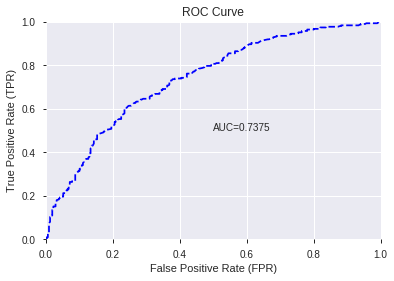

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


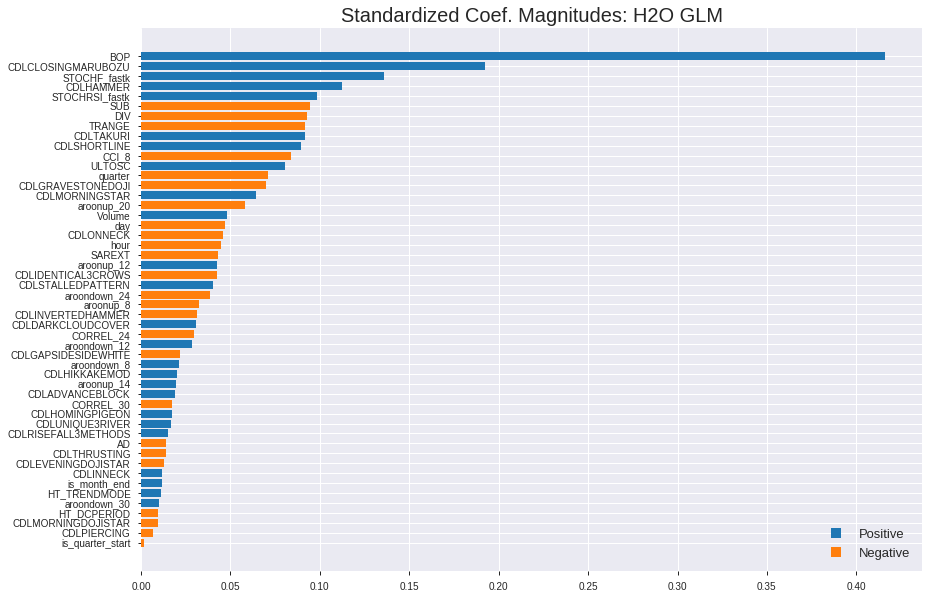

'log_likelihood'
--2019-08-24 17:41:23--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.161.131
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.161.131|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190824_174112_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190824_174112_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_9a5d',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['BOP',
 'CDLCLOSINGMARUBOZU',
 'STOCHF_fastk',
 'CDLHAMMER',
 'STOCHRSI_fastk',
 'SUB',
 'DIV',
 'TRANGE',
 'CDLTAKURI',
 'CDLSHORTLINE',
 'CCI_8',
 'ULTOSC',
 'quarter',
 'CDLGRAVESTONEDOJI',
 'CDLMORNINGSTAR',
 'aroonup_20',
 'Volume',
 'day',
 'CDLONNECK',
 'hour',
 'SAREXT',
 'aroonup_12',
 'CDLIDENTICAL3CROWS',
 'CDLSTALLEDPATTERN',
 'aroondown_24',
 'aroonup_8',
 'CDLINVERTEDHAMMER',
 'CDLDARKCLOUDCOVER',
 'CORREL_24',
 'aroondown_12',
 'CDLGAPSIDESIDEWHITE',
 'aroondown_8',
 'CDLHIKKAKEMOD',
 'aroonup_14',
 'CDLADVANCEBLOCK',
 'CORREL_30',
 'CDLHOMINGPIGEON',
 'CDLUNIQUE3RIVER',
 'CDLRISEFALL3METHODS',
 'AD',
 'CDLTHRUSTING',
 'CDLEVENINGDOJISTAR',
 'CDLINNECK',
 'is_month_end',
 'HT_TRENDMODE',
 'aroondown_30',
 'HT_DCPERIOD',
 'CDLMORNINGDOJISTAR',
 'CDLPIERCING',
 'is_quarter_start']

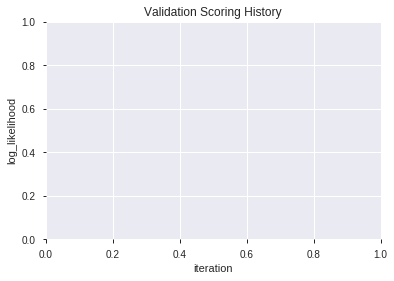

In [13]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_3_AutoML_20190824_174221  0.756541  0.588393              0.308986  0.449387  0.201948
1  XGBoost_grid_1_AutoML_20190824_174221_model_3  0.756131  0.586491              0.309013  0.449146  0.201732
2  XGBoost_grid_1_AutoML_20190824_174221_model_6  0.754876  0.589182              0.317524  0.450355  0.202819
3  XGBoost_grid_1_AutoML_20190824_174221_model_1  0.752716  0.591171              0.305876  0.450986  0.203388
4  XGBoost_grid_1_AutoML_20190824_174221_model_2  0.751650  0.591521              0.339002  0.451301  0.203673
5  XGBoost_grid_1_AutoML_20190824_174221_model_7  0.750814  0.600186              0.301079  0.455112  0.207127
6               XGBoost_1_AutoML_20190824_174221  0.749238  0.600557              0.307405  0.455128  0.207141
7  XGBoost_grid_1_AutoML_20190824_174221_model_5  0.746417  0.609779              0.332046  0.458371  0.210104
8               XGBoost_2_AutoML_20190824_174221  0.745876  0.600309              0.320740  0.455349  0.207343
9  XGBoost_grid_1_AutoML_20190824_174221_model_4  0.745413  0.599279              0.338976  0.454870  0.206907

variable  relative_importance  scaled_importance  percentage
0                  BOP          4753.770508           1.000000    0.316334
1         STOCHF_fastk          1057.338135           0.222421    0.070359
2       STOCHRSI_fastk          1030.604370           0.216797    0.068580
3                  DIV           731.251465           0.153826    0.048660
4                CCI_8           722.412415           0.151966    0.048072
5                 hour           677.335571           0.142484    0.045073
6   CDLCLOSINGMARUBOZU           664.803223           0.139848    0.044239
7               ULTOSC           482.714630           0.101544    0.032122
8                  SUB           461.089294           0.096994    0.030683
9               Volume           441.211060           0.092813    0.029360
10              TRANGE           409.913788           0.086229    0.027277
11                  AD           320.314667           0.067381    0.021315
12              SAREXT           280.920959           0.059094    0.018694
13           CDLHAMMER           280.601013           0.059027    0.018672
14                 day           273.945862           0.057627    0.018229
15          aroonup_20           261.523956           0.055014    0.017403
16           CORREL_30           233.085571           0.049032    0.015510
17           CORREL_24           197.509918           0.041548    0.013143
18        CDLSHORTLINE           194.161438           0.040844    0.012920
19        aroondown_24           192.921204           0.040583    0.012838
20        aroondown_30           190.487091           0.040071    0.012676
21         HT_DCPERIOD           187.133698           0.039365    0.012453
22           aroonup_8           161.441696           0.033961    0.010743
23           CDLTAKURI           145.473007           0.030602    0.009680
24        aroondown_12           138.176270           0.029067    0.009195
25          aroonup_14           131.404373           0.027642    0.008744
26             quarter           110.392342           0.023222    0.007346
27   CDLGRAVESTONEDOJI            90.799919           0.019101    0.006042
28         aroondown_8            89.594902           0.018847    0.005962
29          aroonup_12            69.838791           0.014691    0.004647
30        HT_TRENDMODE            41.463818           0.008722    0.002759
31        is_month_end             4.042474           0.000850    0.000269

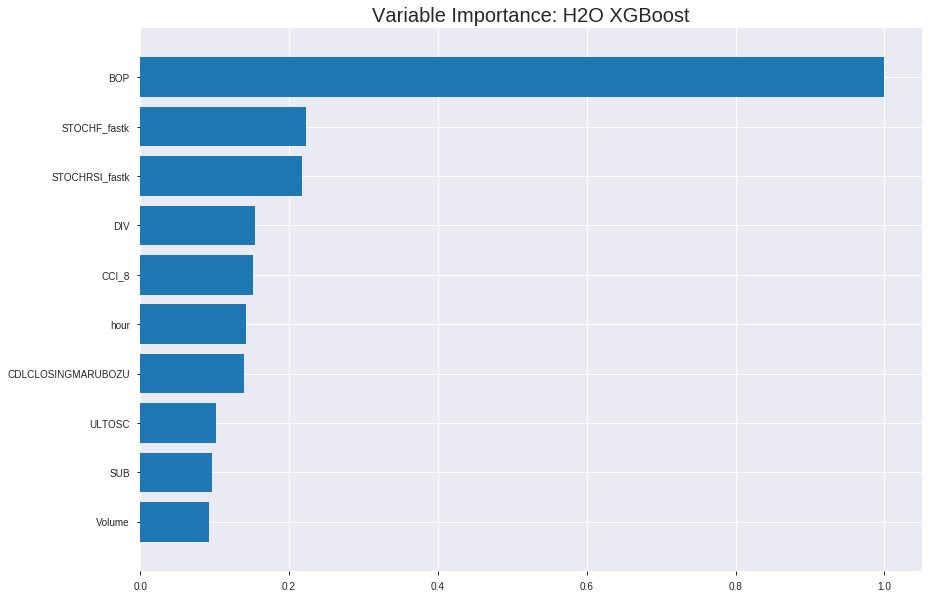

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_3_AutoML_20190824_174221


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.16600551787984483
RMSE: 0.40743774724471077
LogLoss: 0.5054584056499394
Mean Per-Class Error: 0.2350145799553569
AUC: 0.8511694070388067
pr_auc: 0.853353794055249
Gini: 0.7023388140776134
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4216267168521881: 


0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      1374  799   0.3677   (799.0/2173.0)
1      284   1856  0.1327   (284.0/2140.0)
Total  1658  2655  0.2511   (1083.0/4313.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.421627     0.77414   242
max f2                       0.276063     0.86469   313
max f0point5                 0.586856     0.778689  157
max accuracy                 0.518566     0.765129  195
max precision                0.965915     1         0
max recall                   0.138503     1         375
max specificity              0.965915     1         0
max absolute_mcc             0.518566     0.530412  195
max min_per_class_accuracy   0.505742     0.760239  201
max mean_per_class_accuracy  0.518566     0.764985  195

Gains/Lift Table: Avg response rate: 49.62 %, avg score: 49.63 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102017                   0.942937           2.01542    2.01542            1                0.953658  1                           0.953658            0.0205607       0.0205607                  101.542   101.542
    2        0.0201716                   0.914061           2.01542    2.01542            1                0.928069  1                           0.94101             0.0200935       0.0406542                  101.542   101.542
    3        0.0301414                   0.885795           2.01542    2.01542            1                0.900999  1                           0.927776            0.0200935       0.0607477                  101.542   101.542
    4        0.0401113                   0.863249           2.01542    2.01542            1                0.873939  1                           0.914395            0.0200935       0.0808411                  101.542   101.542
    5        0.0500812                   0.841733           2.01542    2.01542            1                0.852826  1                           0.902138            0.0200935       0.100935                   101.542   101.542
    6        0.100162                    0.771816           1.95944    1.98743            0.972222         0.801211  0.986111                    0.851674            0.0981308       0.199065                   95.9437   98.7429
    7        0.150012                    0.731126           1.79044    1.92197            0.888372         0.750428  0.953632                    0.81803             0.0892523       0.288318                   79.0443   92.197
    8        0.200093                    0.696867           1.7355     1.8753             0.861111         0.712919  0.930475                    0.791722            0.0869159       0.375234                   73.5501   87.5299
    9        0.300023                    0.637329           1.50572    1.7522             0.7471           0.669124  0.869397                    0.750888            0.150467        0.525701                   50.572    75.2201
    10       0.399954                    0.568695           1.29529    1.63804            0.642691         0.602616  0.812754                    0.713841            0.129439        0.65514                    29.5293   63.804
    11       0.500116                    0.503817           1.06836    1.52395            0.530093         0.536262  0.756143                    0.678276            0.107009        0.76215                    6.83595   52.3946
    12       0.600046                    0.432782           0.902497   1.42045            0.447796         0.466792  0.704791                    0.643056            0.0901869       0.852336                   -9.75031  42.0451
    13       0.699977                    0.364343           0.715451   1.3198             0.354988         0.397564  0.654853                    0.608009            0.0714953       0.923832                   -28.4549  31.9803
    14       0.799907                    0.281202           0.462939   1.21276            0.229698         0.325662  0.601739                    0.572736            0.0462617       0.970093                   -53.7061  21.2757
    15       0.899838                    0.191988           0.24316    1.10508            0.12065          0.235079  0.548312                    0.535238            0.0242991       0.994393                   -75.684   10.508
    16       1                           0.0602424          0.0559839  1                  0.0277778        0.146089  0.496174                    0.



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.19931156332697567
RMSE: 0.44644323639962974
LogLoss: 0.5807895835876068
Mean Per-Class Error: 0.29527725068522037
AUC: 0.7598619017499473
pr_auc: 0.7536536572918017
Gini: 0.5197238034998946
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.35203638672828674: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      311  309  0.4984   (309.0/620.0)
1      92   520  0.1503   (92.0/612.0)
Total  403  829  0.3255   (401.0/1232.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.352036     0.721721  262
max f2                       0.174913     0.843154  352
max f0point5                 0.480487     0.700132  196
max accuracy                 0.460097     0.704545  207
max precision                0.962099     1         0
max recall                   0.120919     1         380
max specificity              0.962099     1         0
max absolute_mcc             0.460097     0.40999   207
max min_per_class_accuracy   0.476743     0.697712  198
max mean_per_class_accuracy  0.460097     0.704723  207

Gains/Lift Table: Avg response rate: 49.68 %, avg score: 46.99 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105519                   0.935665           2.01307   2.01307            1                0.951348  1                           0.951348            0.0212418       0.0212418                  101.307   101.307
    2        0.0202922                   0.900938           1.84532   1.93255            0.916667         0.920048  0.96                        0.936324            0.0179739       0.0392157                  84.5316   93.2549
    3        0.0300325                   0.868656           1.84532   1.90426            0.916667         0.882676  0.945946                    0.918924            0.0179739       0.0571895                  84.5316   90.4257
    4        0.0405844                   0.842232           2.01307   1.93255            1                0.855822  0.96                        0.902518            0.0212418       0.0784314                  101.307   93.2549
    5        0.0503247                   0.82063            2.01307   1.94813            1                0.830922  0.967742                    0.888661            0.0196078       0.0980392                  101.307   94.8134
    6        0.100649                    0.73424            1.65591   1.80202            0.822581         0.765876  0.895161                    0.827268            0.0833333       0.181373                   65.5914   80.2024
    7        0.150162                    0.703875           1.61706   1.74104            0.803279         0.718512  0.864865                    0.791408            0.0800654       0.261438                   61.7058   74.1035
    8        0.200487                    0.663821           1.29876   1.63002            0.645161         0.683291  0.809717                    0.764269            0.0653595       0.326797                   29.8756   63.0018
    9        0.300325                    0.60146            1.22748   1.4962             0.609756         0.631961  0.743243                    0.720286            0.122549        0.449346                   22.7483   49.6202
    10       0.400162                    0.541808           1.26022   1.43733            0.626016         0.569713  0.713996                    0.682719            0.125817        0.575163                   26.0216   43.7325
    11       0.5                         0.474792           1.24385   1.39869            0.617886         0.50858   0.694805                    0.647948            0.124183        0.699346                   24.3849   39.8693
    12       0.599838                    0.408258           0.818322  1.3021             0.406504         0.442203  0.64682                     0.613703            0.0816993       0.781046                   -18.1678  30.2095
    13       0.699675                    0.334049           0.851055  1.23774            0.422764         0.370405  0.614849                    0.578987            0.0849673       0.866013                   -14.8945  23.7736
    14       0.799513                    0.256213           0.638291  1.16288            0.317073         0.294763  0.577665                    0.543495            0.0637255       0.929739                   -36.1709  16.2881
    15       0.899351                    0.181653           0.45826   1.08466            0.227642         0.218008  0.538809                    0.507362            0.0457516       0.97549                    -54.174   8.46606
    16       1                           0.0745197          0.243517  1                  0.120968         0.134896  0.496753                    0.469874         


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 17:42:28  0.003 sec   0                  0.5              0.693147            0.5             0                  1                0.503826                         0.5                0.693147              0.5               0                    1                  0.503247
    2019-08-24 17:42:28  0.079 sec   5                  0.479864         0.653463            0.782524        0.76               2.01542          0.309993                         0.482956           0.659447              0.743009          0.715749             1.85822            0.338474
    2019-08-24 17:42:28  0.147 sec   10                 0.465844         0.626051            0.790708        0.782586           2.01542          0.299096                         0.472221           0.63823               0.746032          0.724371             1.85822            0.362825
    2019-08-24 17:42:28  0.238 sec   15                 0.455544         0.605633            0.79779         0.791955           2.01542          0.300487                         0.465352           0.624249              0.746007          0.728226             1.85822            0.340909
    2019-08-24 17:42:29  0.533 sec   20                 0.447106         0.588542            0.801844        0.800834           2.01542          0.299791                         0.459992           0.613036              0.747238          0.735422             1.85822            0.342532
    2019-08-24 17:42:29  0.609 sec   25                 0.440466         0.574851            0.807206        0.80742            2.01542          0.294227                         0.456334           0.605018              0.748657          0.738529             1.85822            0.339286
    2019-08-24 17:42:29  0.680 sec   30                 0.435045         0.563449            0.812603        0.813742           2.01542          0.297473                         0.45346            0.598516              0.751361          0.742647             2.01307            0.343344
    2019-08-24 17:42:29  0.750 sec   35                 0.431046         0.554758            0.815328        0.816963           2.01542          0.290749                         0.451559           0.594061              0.752216          0.744969             1.85822            0.348214
    2019-08-24 17:42:29  0.826 sec   40                 0.427204         0.546446            0.820012        0.822846           2.01542          0.288662                         0.450191           0.590607              0.753674          0.747383             1.85822            0.349026
    2019-08-24 17:42:29  0.897 sec   45                 0.423906         0.539443            0.825119        0.828424           2.01542          0.277765                         0.448777           0.58742               0.75667           0.75145              2.01307            0.347403
    2019-08-24 17:42:29  0.972 sec   50                 0.420712         0.532705            0.829966        0.83316            2.01542          0.276374                         0.448331           0.586011              0.75679           0.752206             2.01307            0.342532
    2019-08-24 17:42:29  1.053 sec   55                 0.417503         0.526007            0.834828        0.838336           2.01542          0.268491                         0.447965           0.584879              0.756963          0

Variable Importances: 


variable           relative_importance    scaled_importance      percentage
-----------------  ---------------------  ---------------------  ---------------------
BOP                4753.7705078125        1.0                    0.31633434581719355
STOCHF_fastk       1057.338134765625      0.22242094628420983    0.07035938453885666
STOCHRSI_fastk     1030.6043701171875     0.21679724934627345    0.0685804160469204
DIV                731.25146484375        0.15382557143681794    0.04866031151042178
CCI_8              722.4124145507812      0.1519661947003006     0.04807212678684786
---                ---                    ---                    ---
CDLGRAVESTONEDOJI  90.79991912841797      0.019100610553074545   0.006042179144015819
aroondown_8        89.59490203857422      0.018847123960092534   0.005961992628451426
aroonup_12         69.83879089355469      0.014691241568935514   0.004647344290951576
HT_TRENDMODE       41.46381759643555      0.008722301072021162   0.00275916340363842
is_month_end       4.042473793029785      0.0008503720965045017  0.0002690019008489469


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.700162074554295)

('F1', 0.7285714285714286)

('auc', 0.7565412016896791)

('logloss', 0.588392565268724)

('mean_per_class_error', 0.30058003908959086)

('rmse', 0.4493865824525408)

('mse', 0.20194830048837425)

xgboost prediction progress: |████████████████████████████████████████████| 100%


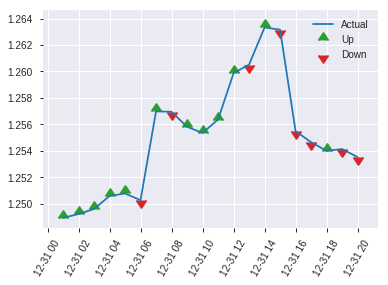


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.20194830048837425
RMSE: 0.4493865824525408
LogLoss: 0.588392565268724
Mean Per-Class Error: 0.30058003908959086
AUC: 0.7565412016896791
pr_auc: 0.7455686878788074
Gini: 0.5130824033793582
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3814869523048401: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      172  134  0.4379   (134.0/306.0)
1      56   255  0.1801   (56.0/311.0)
Total  228  389  0.3079   (190.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.381487     0.728571  252
max f2                       0.157102     0.850472  358
max f0point5                 0.492918     0.695682  192
max accuracy                 0.408897     0.700162  237
max precision                0.962295     1         0
max recall                   0.0932143    1         390
max specificity              0.962295     1         0
max absolute_mcc             0.408897     0.40594   237
max min_per_class_accuracy   0.473202     0.678457  201
max mean_per_class_accuracy  0.408897     0.69942   237

Gains/Lift Table: Avg response rate: 50.41 %, avg score: 46.79 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.930094           1.70051   1.70051            0.857143         0.945755  0.857143                    0.945755            0.0192926       0.0192926                  70.0505   70.0505
    2        0.0210697                   0.90584            1.65327   1.6787             0.833333         0.917321  0.846154                    0.932632            0.0160772       0.0353698                  65.3269   67.8704
    3        0.0307942                   0.887702           1.65327   1.67067            0.833333         0.896882  0.842105                    0.921342            0.0160772       0.0514469                  65.3269   67.0672
    4        0.0405186                   0.867085           1.98392   1.74585            1                0.87749   0.88                        0.910818            0.0192926       0.0707395                  98.3923   74.5852
    5        0.0502431                   0.841636           1.98392   1.79193            1                0.856448  0.903226                    0.900295            0.0192926       0.0900322                  98.3923   79.193
    6        0.100486                    0.752369           1.85593   1.82393            0.935484         0.783824  0.919355                    0.842059            0.0932476       0.18328                    85.5928   82.3929
    7        0.150729                    0.711604           1.34395   1.66394            0.677419         0.730425  0.83871                     0.804848            0.0675241       0.250804                   34.3948   66.3935
    8        0.200972                    0.679077           1.47194   1.61594            0.741935         0.695691  0.814516                    0.777559            0.073955        0.324759                   47.1943   61.5937
    9        0.299838                    0.606375           1.20336   1.4799             0.606557         0.642705  0.745946                    0.733093            0.118971        0.44373                    20.3363   47.9899
    10       0.400324                    0.542843           1.27995   1.42971            0.645161         0.572087  0.720648                    0.692679            0.128617        0.572347                   27.995    42.971
    11       0.50081                     0.466451           1.05596   1.35472            0.532258         0.503706  0.682848                    0.654762            0.106109        0.678457                   5.59589   35.4718
    12       0.599676                    0.404892           1.17084   1.3244             0.590164         0.434684  0.667568                    0.618479            0.115756        0.794212                   17.084    32.4403
    13       0.700162                    0.335478           0.639975  1.22617            0.322581         0.366398  0.618056                    0.5823              0.0643087       0.858521                   -36.0025  22.6175
    14       0.799028                    0.232984           0.650467  1.15494            0.327869         0.28962   0.58215                     0.546086            0.0643087       0.92283                    -34.9533  15.4941
    15       0.899514                    0.156642           0.607976  1.09384            0.306452         0.193993  0.551351                    0.506753            0.0610932       0.983923                   -39.2024  9.38385
    16       1                           0.0587807          0.159994  1                  0.0806452        0.120417  0.504052                    0.467932           

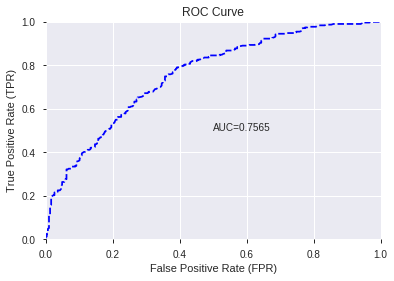

This function is available for GLM models only


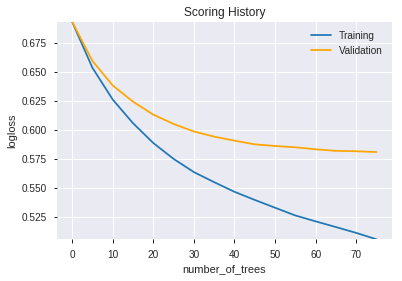

--2019-08-24 17:42:59--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.96.131
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.96.131|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_3_AutoML_20190824_174221',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_3_AutoML_20190824_174221',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_9a5d',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_26_sid_9a5d',
   'type

['BOP',
 'STOCHF_fastk',
 'STOCHRSI_fastk',
 'DIV',
 'CCI_8',
 'hour',
 'CDLCLOSINGMARUBOZU',
 'ULTOSC',
 'SUB',
 'Volume',
 'TRANGE',
 'AD',
 'SAREXT',
 'CDLHAMMER',
 'day',
 'aroonup_20',
 'CORREL_30',
 'CORREL_24',
 'CDLSHORTLINE',
 'aroondown_24',
 'aroondown_30',
 'HT_DCPERIOD',
 'aroonup_8',
 'CDLTAKURI',
 'aroondown_12',
 'aroonup_14',
 'quarter',
 'CDLGRAVESTONEDOJI',
 'aroondown_8',
 'aroonup_12',
 'HT_TRENDMODE',
 'is_month_end']

In [14]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190824_174356_model_1  0.737779  0.620914              0.381933  0.465187  0.216399

variable  relative_importance  scaled_importance    percentage
0                         BOP             0.259594           1.000000  4.386155e-02
1          CDLCLOSINGMARUBOZU             0.123017           0.473881  2.078516e-02
2                CDLSHORTLINE             0.094483           0.363963  1.596398e-02
3                STOCHF_fastk             0.094256           0.363091  1.592575e-02
4                   CDLHAMMER             0.087980           0.338915  1.486533e-02
...                       ...                  ...                ...           ...
1032  BBANDS_upperband_24_0_5             0.000008           0.000030  1.323871e-06
1033  BBANDS_lowerband_14_6_3             0.000007           0.000028  1.226544e-06
1034  BBANDS_lowerband_12_1_4             0.000007           0.000026  1.135437e-06
1035                   T3_8_5             0.000005           0.000020  8.961202e-07
1036  BBANDS_upperband_30_6_4             0.000004           0.000015  6.553153e-07

[1037 rows x 4 columns]

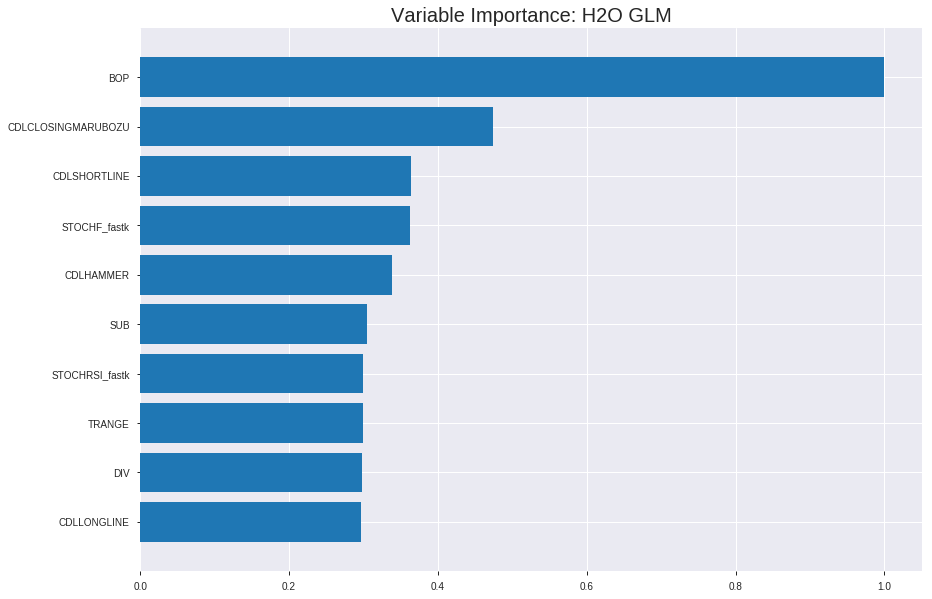

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190824_174356_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.198057591393649
RMSE: 0.44503661803681843
LogLoss: 0.5815234559846212
Null degrees of freedom: 4312
Residual degrees of freedom: 3275
Null deviance: 5978.835084581811
Residual deviance: 5016.2213313233415
AIC: 7092.2213313233415
AUC: 0.7714665112618327
pr_auc: 0.7637786053794045
Gini: 0.5429330225236655
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4058909871716706: 


0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      1087  1086  0.4998   (1086.0/2173.0)
1      304   1836  0.1421   (304.0/2140.0)
Total  1391  2922  0.3223   (1390.0/4313.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.405891     0.725405  251
max f2                       0.268367     0.838655  322
max f0point5                 0.551445     0.708851  162
max accuracy                 0.530074     0.702759  176
max precision                0.911575     1         0
max recall                   0.0666106    1         393
max specificity              0.911575     1         0
max absolute_mcc             0.530074     0.406391  176
max min_per_class_accuracy   0.504753     0.696272  191
max mean_per_class_accuracy  0.530074     0.70244   176

Gains/Lift Table: Avg response rate: 49.62 %, avg score: 49.62 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102017                   0.845533           1.96962   1.96962            0.977273         0.862577  0.977273                    0.862577            0.0200935       0.0200935                  96.9616   96.9616
    2        0.0201716                   0.821281           1.82794   1.89959            0.906977         0.833129  0.942529                    0.848022            0.0182243       0.0383178                  82.794    89.9592
    3        0.0301414                   0.803719           1.7342    1.84488            0.860465         0.813332  0.915385                    0.836548            0.0172897       0.0556075                  73.4199   84.4885
    4        0.0401113                   0.78775            1.78107   1.82902            0.883721         0.795133  0.907514                    0.826254            0.017757        0.0733645                  78.1069   82.9023
    5        0.0500812                   0.77426            1.7342    1.81015            0.860465         0.781237  0.898148                    0.817292            0.0172897       0.0906542                  73.4199   81.0146
    6        0.100162                    0.727312           1.7355    1.77282            0.861111         0.747383  0.87963                     0.782338            0.0869159       0.17757                    73.5501   77.2824
    7        0.150012                    0.6964             1.63108   1.72572            0.809302         0.712556  0.85626                     0.759149            0.0813084       0.258879                   63.1085   72.5723
    8        0.200093                    0.667954           1.53023   1.67679            0.759259         0.681813  0.831981                    0.739793            0.0766355       0.335514                   53.0227   67.6793
    9        0.300023                    0.613558           1.42155   1.59178            0.705336         0.640303  0.789799                    0.706655            0.142056        0.47757                    42.155    59.1777
    10       0.399954                    0.559178           1.20645   1.4955             0.598608         0.587474  0.742029                    0.676877            0.120561        0.598131                   20.6447   49.55
    11       0.500116                    0.504331           1.01238   1.39874            0.502315         0.532081  0.694019                    0.647878            0.101402        0.699533                   1.23756   39.8741
    12       0.600046                    0.442971           0.902497  1.3161             0.447796         0.473132  0.653014                    0.618776            0.0901869       0.78972                    -9.75031  31.6098
    13       0.699977                    0.392768           0.81365   1.24437            0.403712         0.418785  0.617423                    0.590225            0.0813084       0.871028                   -18.635   24.4367
    14       0.799907                    0.329226           0.589195  1.16252            0.292343         0.360906  0.576812                    0.561577            0.0588785       0.929907                   -41.0805  16.2518
    15       0.899838                    0.244615           0.444234  1.08275            0.220418         0.292927  0.537233                    0.531742            0.0443925       0.974299                   -55.5766  8.27498
    16       1                           0.0225072          0.256593  1                  0.127315         0.176642  0.496174                    0.496174           



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.21388684548108813
RMSE: 0.4624790216659434
LogLoss: 0.616246626106759
Null degrees of freedom: 1231
Residual degrees of freedom: 194
Null deviance: 1707.8643560108549
Residual deviance: 1518.431686727054
AIC: 3594.431686727054
AUC: 0.732326586548598
pr_auc: 0.7070835131921309
Gini: 0.4646531730971959
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3604198953346156: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      316  304  0.4903   (304.0/620.0)
1      108  504  0.1765   (108.0/612.0)
Total  424  808  0.3344   (412.0/1232.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.36042      0.709859  249
max f2                       0.131044     0.836544  373
max f0point5                 0.391075     0.671982  226
max accuracy                 0.391075     0.681006  226
max precision                0.799793     0.95      11
max recall                   0.0900459    1         387
max specificity              0.867827     0.998387  0
max absolute_mcc             0.391075     0.368992  226
max min_per_class_accuracy   0.441189     0.668301  196
max mean_per_class_accuracy  0.391075     0.681589  226

Gains/Lift Table: Avg response rate: 49.68 %, avg score: 43.84 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105519                   0.814885           1.85822   1.85822            0.923077         0.838834  0.923077                    0.838834            0.0196078       0.0196078                  85.822    85.822
    2        0.0202922                   0.792749           1.67756   1.7715             0.833333         0.80188   0.88                        0.821096            0.0163399       0.0359477                  67.756    77.1503
    3        0.0300325                   0.765903           1.5098    1.68663            0.75             0.778861  0.837838                    0.807398            0.0147059       0.0506536                  50.9804   68.6628
    4        0.0405844                   0.752487           1.39367   1.61046            0.692308         0.759275  0.8                         0.794886            0.0147059       0.0653595                  39.3665   61.0458
    5        0.0503247                   0.735727           1.67756   1.62345            0.833333         0.746062  0.806452                    0.785436            0.0163399       0.0816993                  67.756    62.3445
    6        0.100649                    0.676662           1.52604   1.57474            0.758065         0.703711  0.782258                    0.744574            0.0767974       0.158497                   52.6038   57.4742
    7        0.150162                    0.628694           1.68306   1.61046            0.836066         0.649707  0.8                         0.713293            0.0833333       0.24183                    68.306    61.0458
    8        0.200487                    0.594736           1.36369   1.54852            0.677419         0.611971  0.769231                    0.68786             0.0686275       0.310458                   36.3694   54.8517
    9        0.300325                    0.545734           1.34205   1.47988            0.666667         0.570867  0.735135                    0.648968            0.133987        0.444444                   34.2048   47.988
    10       0.400162                    0.488109           1.19475   1.40874            0.593496         0.516476  0.699797                    0.615912            0.119281        0.563725                   19.475    40.8742
    11       0.5                         0.438662           1.06382   1.33987            0.528455         0.463908  0.665584                    0.58556             0.106209        0.669935                   6.38185   33.9869
    12       0.599838                    0.386513           1.04745   1.2912             0.520325         0.410046  0.641407                    0.556348            0.104575        0.77451                    4.7452    29.1199
    13       0.699675                    0.332117           0.752856  1.21438            0.373984         0.361147  0.603248                    0.528494            0.0751634       0.849673                   -24.7144  21.4382
    14       0.799513                    0.277359           0.638291  1.14244            0.317073         0.305871  0.567513                    0.500694            0.0637255       0.913399                   -36.1709  14.2444
    15       0.899351                    0.193564           0.556459  1.07739            0.276423         0.238545  0.535199                    0.471593            0.0555556       0.968954                   -44.3541  7.73932
    16       1                           0.0321244          0.308455  1                  0.153226         0.142201  0.496753                    0.43844            


Scoring History: 


timestamp            duration          iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------------  -----------  --------  ------------  ------------------  ------------------
     2019-08-24 17:44:04  0.000 sec         2            .2E2      1030          1.3625209491686356  1.3619007543741937
     2019-08-24 17:44:09  4.542 sec         4            .14E2     1037          1.3560219002352072  1.3552080901910482
     2019-08-24 17:44:13  9.059 sec         6            .1E2      1037          1.3480643726783605  1.3472881090363316
     2019-08-24 17:44:18  13.791 sec        8            .76E1     1037          1.3384582738773732  1.3380568562320847
     2019-08-24 17:44:23  18.538 sec        10           .55E1     1038          1.3270678729061847  1.3274445580683252
---  ---                  ---               ---          ---       ---           ---                 ---
     2019-08-24 17:45:20  1 min 15.225 sec  34           .12E0     1038          1.1536253818799376  1.2339976117117648
     2019-08-24 17:45:24  1 min 19.808 sec  36           .89E-1    1038          1.145544073704801   1.2369223100557714
     2019-08-24 17:45:29  1 min 24.315 sec  38           .65E-1    1038          1.1386508973684055  1.2408656277897816
     2019-08-24 17:45:33  1 min 29.028 sec  40           .47E-1    1038          1.1328010428259583  1.2452465667681158
     2019-08-24 17:45:38  1 min 33.599 sec  42           .34E-1    1038          1.1278160008432963  1.2500394854997745


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6823338735818476)

('F1', 0.7160194174757282)

('auc', 0.7377792488914108)

('logloss', 0.6209141214750409)

('mean_per_class_error', 0.3178971481411428)

('rmse', 0.46518665108015433)

('mse', 0.21639862034316923)

glm prediction progress: |████████████████████████████████████████████████| 100%


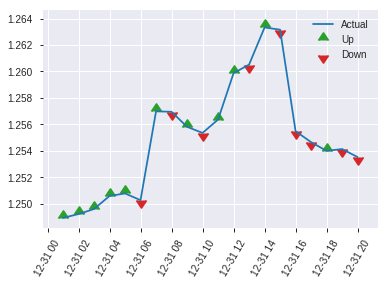


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.21639862034316923
RMSE: 0.46518665108015433
LogLoss: 0.6209141214750409
Null degrees of freedom: 616
Residual degrees of freedom: -421
Null deviance: 855.4562567606156
Residual deviance: 766.2080259002005
AIC: 2842.2080259002005
AUC: 0.7377792488914108
pr_auc: 0.7180260249919737
Gini: 0.47555849778282155
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.23448774265630862: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      88   218  0.7124   (218.0/306.0)
1      16   295  0.0514   (16.0/311.0)
Total  104  513  0.3793   (234.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.234488     0.716019  323
max f2                       0.204289     0.848791  338
max f0point5                 0.439875     0.685856  183
max accuracy                 0.38889      0.682334  216
max precision                0.864765     1         0
max recall                   0.0802711    1         389
max specificity              0.864765     1         0
max absolute_mcc             0.366291     0.367063  229
max min_per_class_accuracy   0.40864      0.675241  204
max mean_per_class_accuracy  0.38889      0.682103  216

Gains/Lift Table: Avg response rate: 50.41 %, avg score: 41.31 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.793113           1.70051   1.70051            0.857143         0.819454  0.857143                    0.819454            0.0192926       0.0192926                  70.0505   70.0505
    2        0.0210697                   0.745105           1.98392   1.83131            1                0.770354  0.923077                    0.796792            0.0192926       0.0385852                  98.3923   83.1313
    3        0.0307942                   0.737008           1.65327   1.77509            0.833333         0.74127   0.894737                    0.779259            0.0160772       0.0546624                  65.3269   77.5089
    4        0.0405186                   0.720792           1.32262   1.6665             0.666667         0.729127  0.84                        0.767227            0.0128617       0.0675241                  32.2615   66.6495
    5        0.0502431                   0.69594            1.98392   1.72793            1                0.710705  0.870968                    0.756288            0.0192926       0.0868167                  98.3923   72.7933
    6        0.100486                    0.653884           1.34395   1.53594            0.677419         0.677231  0.774194                    0.716759            0.0675241       0.154341                   34.3948   53.594
    7        0.150729                    0.619783           1.66394   1.57861            0.83871          0.634601  0.795699                    0.689373            0.0836013       0.237942                   66.3935   57.8605
    8        0.200972                    0.582896           1.47194   1.55194            0.741935         0.601079  0.782258                    0.6673              0.073955        0.311897                   47.1943   55.194
    9        0.299838                    0.520424           1.33346   1.4799             0.672131         0.548607  0.745946                    0.628163            0.131833        0.44373                    33.3456   47.9899
    10       0.400324                    0.465735           1.15196   1.39758            0.580645         0.491747  0.704453                    0.593921            0.115756        0.559486                   15.1955   39.7581
    11       0.50081                     0.40864            1.15196   1.3483             0.580645         0.437269  0.679612                    0.562489            0.115756        0.675241                   15.1955   34.8297
    12       0.599676                    0.352887           0.9757    1.28687            0.491803         0.377128  0.648649                    0.53193             0.096463        0.771704                   -2.43002  28.6869
    13       0.700162                    0.303949           0.703973  1.20321            0.354839         0.327201  0.606481                    0.502547            0.0707395       0.842444                   -29.6027  20.3212
    14       0.799028                    0.253502           0.78056   1.15092            0.393443         0.277834  0.580122                    0.474743            0.0771704       0.919614                   -21.944   15.0917
    15       0.899514                    0.178944           0.575978  1.08669            0.290323         0.217868  0.547748                    0.446047            0.0578778       0.977492                   -42.4022  8.66893
    16       1                           0.0110851          0.223991  1                  0.112903         0.117693  0.504052                    0.413052           

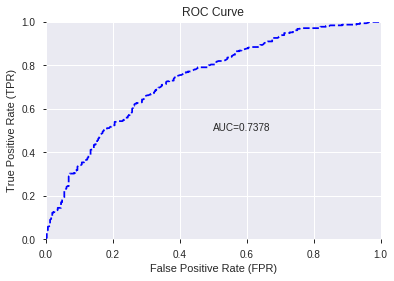

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


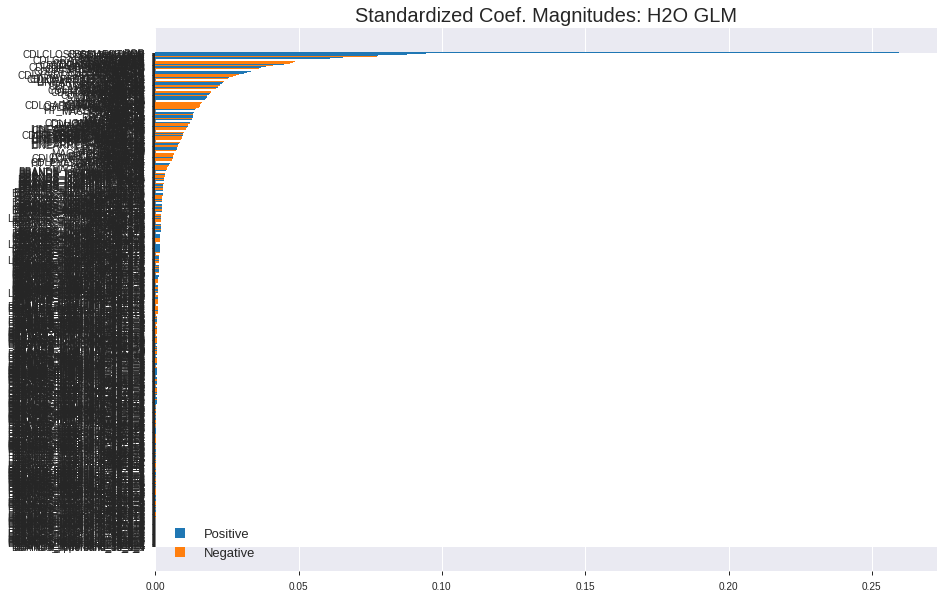

'log_likelihood'
--2019-08-24 17:46:02--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.109.131
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.109.131|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190824_174356_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190824_174356_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_9a5d',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

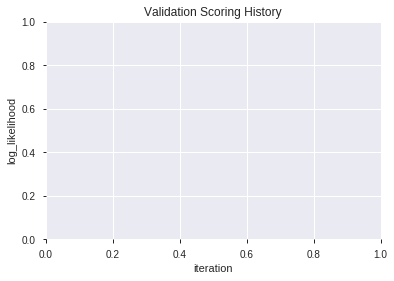

In [15]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [16]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [17]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [18]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190824_174700_model_2  0.748350  0.598663              0.332256  0.454098  0.206205
1  XGBoost_grid_1_AutoML_20190824_174700_model_6  0.747436  0.597441              0.302293  0.453495  0.205658
2  XGBoost_grid_1_AutoML_20190824_174700_model_1  0.738872  0.605455              0.363775  0.457188  0.209021
3               XGBoost_2_AutoML_20190824_174700  0.738662  0.606668              0.347199  0.457874  0.209649
4  XGBoost_grid_1_AutoML_20190824_174700_model_3  0.738620  0.606858              0.368493  0.457624  0.209420
5  XGBoost_grid_1_AutoML_20190824_174700_model_4  0.738058  0.608938              0.317051  0.458889  0.210579
6               XGBoost_3_AutoML_20190824_174700  0.737422  0.606929              0.323666  0.458015  0.209778
7               XGBoost_1_AutoML_20190824_174700  0.737317  0.609971              0.362062  0.459612  0.211243
8  XGBoost_grid_1_AutoML_20190824_174700_model_7  0.729483  0.616169              0.355316  0.461950  0.213398
9  XGBoost_grid_1_AutoML_20190824_174700_model_5  0.723362  0.624142              0.340164  0.464894  0.216127

variable  relative_importance  scaled_importance  percentage
0                        BOP          4996.117676           1.000000    0.281231
1             STOCHRSI_fastk           732.745300           0.146663    0.041246
2               STOCHF_fastk           594.587036           0.119010    0.033469
3                       hour           417.674164           0.083600    0.023511
4         CDLCLOSINGMARUBOZU           414.659424           0.082996    0.023341
..                       ...                  ...                ...         ...
299   BBANDS_lowerband_8_2_3             0.646093           0.000129    0.000036
300  BBANDS_lowerband_14_0_4             0.369892           0.000074    0.000021
301   BBANDS_lowerband_8_1_4             0.222442           0.000045    0.000013
302   BBANDS_upperband_8_0_4             0.172692           0.000035    0.000010
303            days_in_month             0.037307           0.000007    0.000002

[304 rows x 4 columns]

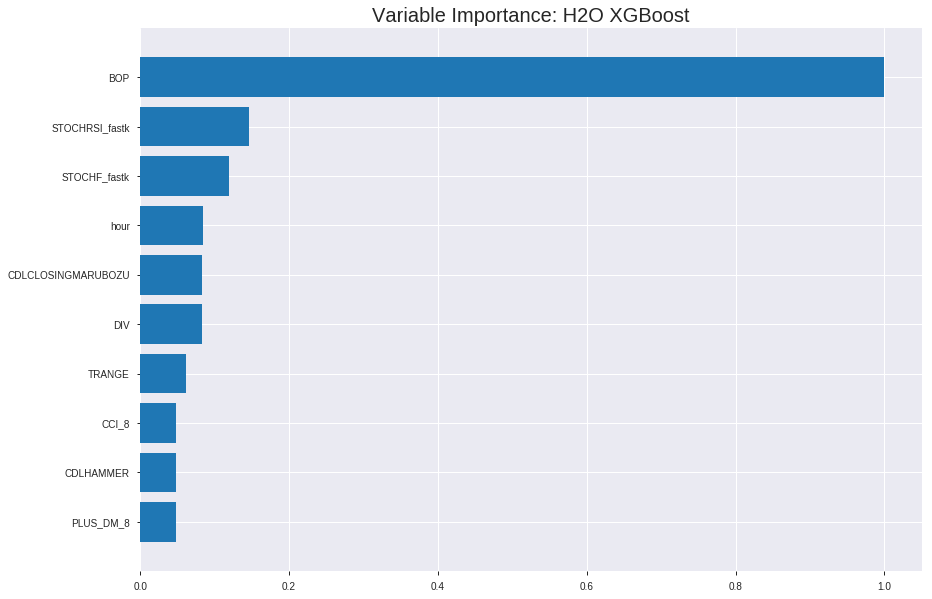

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190824_174700_model_2


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.16104929901302614
RMSE: 0.4013094803428224
LogLoss: 0.4961320176120431
Mean Per-Class Error: 0.22336781915694315
AUC: 0.8665928708749263
pr_auc: 0.8708887051464698
Gini: 0.7331857417498526
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40504773980692815: 


0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      1351  822   0.3783   (822.0/2173.0)
1      231   1909  0.1079   (231.0/2140.0)
Total  1582  2731  0.2441   (1053.0/4313.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.405048     0.783823  250
max f2                       0.292092     0.868857  306
max f0point5                 0.581632     0.79638   159
max accuracy                 0.508403     0.776722  196
max precision                0.937065     1         0
max recall                   0.158541     1         371
max specificity              0.937065     1         0
max absolute_mcc             0.554426     0.555098  172
max min_per_class_accuracy   0.501234     0.775426  200
max mean_per_class_accuracy  0.508403     0.776632  196

Gains/Lift Table: Avg response rate: 49.62 %, avg score: 49.52 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102017                   0.910248           2.01542    2.01542            1                0.922838  1                           0.922838            0.0205607       0.0205607                  101.542   101.542
    2        0.0201716                   0.891202           2.01542    2.01542            1                0.900913  1                           0.912001            0.0200935       0.0406542                  101.542   101.542
    3        0.0301414                   0.872256           2.01542    2.01542            1                0.882477  1                           0.902236            0.0200935       0.0607477                  101.542   101.542
    4        0.0401113                   0.850713           2.01542    2.01542            1                0.861083  1                           0.892007            0.0200935       0.0808411                  101.542   101.542
    5        0.0500812                   0.82744            2.01542    2.01542            1                0.839439  1                           0.881542            0.0200935       0.100935                   101.542   101.542
    6        0.100162                    0.768927           1.96877    1.99209            0.976852         0.794044  0.988426                    0.837793            0.0985981       0.199533                   96.8767   99.2094
    7        0.150012                    0.732665           1.88418    1.95624            0.934884         0.750354  0.970634                    0.808737            0.0939252       0.293458                   88.4184   95.6235
    8        0.200093                    0.701947           1.81948    1.92201            0.902778         0.717744  0.95365                     0.785962            0.0911215       0.384579                   81.9477   92.2006
    9        0.300023                    0.63441            1.55248    1.79893            0.770302         0.669944  0.892581                    0.747319            0.15514         0.53972                    55.2482   79.8926
    10       0.399954                    0.570197           1.29062    1.67192            0.640371         0.603187  0.829565                    0.711307            0.128972        0.668692                   29.0617   67.1923
    11       0.500116                    0.499824           1.09635    1.55665            0.543981         0.534499  0.772369                    0.675896            0.109813        0.778505                   9.63515   55.6648
    12       0.600046                    0.428225           0.865088   1.44148            0.429234         0.464666  0.715224                    0.640718            0.0864486       0.864953                   -13.4912  44.1477
    13       0.699977                    0.359947           0.649985   1.32848            0.322506         0.393017  0.659159                    0.605356            0.0649533       0.929907                   -35.0015  32.8482
    14       0.799907                    0.280962           0.439558   1.21743            0.218097         0.321453  0.604058                    0.569889            0.0439252       0.973832                   -56.0442  21.7431
    15       0.899838                    0.197246           0.205751   1.10508            0.102088         0.238707  0.548312                    0.53311             0.0205607       0.994393                   -79.4249  10.508
    16       1                           0.0859484          0.0559839  1                  0.0277778        0.155098  0.496174                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.20337525305299922
RMSE: 0.45097145480950257
LogLoss: 0.5918489178155908
Mean Per-Class Error: 0.30550811722538473
AUC: 0.7512729285262493
pr_auc: 0.7388388100021005
Gini: 0.5025458570524985
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.35808005928993225: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      312  308  0.4968   (308.0/620.0)
1      98   514  0.1601   (98.0/612.0)
Total  410  822  0.3295   (406.0/1232.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.35808      0.716876  265
max f2                       0.189302     0.841056  354
max f0point5                 0.49293      0.691197  190
max accuracy                 0.41596      0.693994  231
max precision                0.925048     1         0
max recall                   0.117408     1         392
max specificity              0.925048     1         0
max absolute_mcc             0.411069     0.393486  234
max min_per_class_accuracy   0.474001     0.683007  201
max mean_per_class_accuracy  0.411069     0.694492  234

Gains/Lift Table: Avg response rate: 49.68 %, avg score: 46.58 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105519                   0.893853           1.85822   1.85822            0.923077         0.906739  0.923077                    0.906739            0.0196078       0.0196078                  85.822    85.822
    2        0.0202922                   0.87434            1.84532   1.85203            0.916667         0.883941  0.92                        0.895796            0.0179739       0.0375817                  84.5316   85.2026
    3        0.0300325                   0.837848           1.84532   1.84985            0.916667         0.854681  0.918919                    0.882461            0.0179739       0.0555556                  84.5316   84.985
    4        0.0405844                   0.804333           2.01307   1.89229            1                0.818197  0.94                        0.865753            0.0212418       0.0767974                  101.307   89.2288
    5        0.0503247                   0.779463           1.84532   1.8832             0.916667         0.790739  0.935484                    0.851234            0.0179739       0.0947712                  84.5316   88.3196
    6        0.100649                    0.724441           1.55851   1.72085            0.774194         0.748232  0.854839                    0.799733            0.0784314       0.173203                   55.8507   72.0852
    7        0.150162                    0.690224           1.51805   1.65398            0.754098         0.706393  0.821622                    0.768956            0.0751634       0.248366                   51.8054   65.3983
    8        0.200487                    0.657521           1.62345   1.64632            0.806452         0.674145  0.817814                    0.745157            0.0816993       0.330065                   62.3445   64.6318
    9        0.300325                    0.588831           1.14565   1.47988            0.569106         0.623397  0.735135                    0.70468             0.114379        0.444444                   14.5651   47.988
    10       0.400162                    0.528863           1.26022   1.42508            0.626016         0.558346  0.707911                    0.668171            0.125817        0.570261                   26.0216   42.5075
    11       0.5                         0.46737            1.14565   1.36928            0.569106         0.50187   0.680195                    0.634965            0.114379        0.684641                   14.5651   36.9281
    12       0.599838                    0.39614            1.04745   1.31572            0.520325         0.43109   0.653586                    0.601031            0.104575        0.789216                   4.7452    31.5715
    13       0.699675                    0.340157           0.68739   1.22606            0.341463         0.366556  0.609049                    0.567574            0.0686275       0.857843                   -31.261   22.6059
    14       0.799513                    0.26135            0.703757  1.16084            0.349593         0.3061    0.57665                     0.534923            0.0702614       0.928105                   -29.6243  16.0837
    15       0.899351                    0.191911           0.474627  1.08466            0.235772         0.228423  0.538809                    0.500898            0.0473856       0.97549                    -52.5373  8.46606
    16       1                           0.0889421          0.243517  1                  0.120968         0.152433  0.496753                    0.465825            


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 17:47:48  6.694 sec   0                  0.5              0.693147            0.5             0                  1                0.503826                         0.5                0.693147              0.5               0                    1                  0.503247
    2019-08-24 17:47:49  7.875 sec   5                  0.482187         0.658019            0.78451         0.735404           1.94898          0.322513                         0.486479           0.66637               0.727599          0.672402             1.7894             0.362013
    2019-08-24 17:47:50  8.253 sec   10                 0.466622         0.627765            0.796327        0.769821           1.97511          0.301878                         0.475746           0.645233              0.734548          0.694443             2.01307            0.357143
    2019-08-24 17:47:50  8.656 sec   15                 0.456279         0.607547            0.802775        0.78643            1.97063          0.289358                         0.469094           0.631959              0.737824          0.708554             1.86928            0.367695
    2019-08-24 17:47:51  9.164 sec   20                 0.447856         0.590826            0.808474        0.802005           2.01542          0.284489                         0.464703           0.622921              0.738407          0.717063             1.85822            0.336039
    2019-08-24 17:47:51  9.622 sec   25                 0.440988         0.577102            0.814838        0.811767           2.01542          0.282634                         0.461389           0.616017              0.739643          0.718782             1.85822            0.351461
    2019-08-24 17:47:52  9.984 sec   30                 0.435247         0.565383            0.819799        0.819815           2.01542          0.278229                         0.459101           0.610991              0.739839          0.719955             1.85822            0.318994
    2019-08-24 17:47:52  10.355 sec  35                 0.43013          0.55483             0.825423        0.829183           2.01542          0.278692                         0.45741            0.607154              0.741217          0.725226             2.01307            0.347403
    2019-08-24 17:47:52  10.730 sec  40                 0.426067         0.546341            0.830668        0.836658           2.01542          0.272896                         0.455947           0.603812              0.743377          0.728471             2.01307            0.353084
    2019-08-24 17:47:53  11.107 sec  45                 0.422127         0.538181            0.83548         0.841433           2.01542          0.274055                         0.454671           0.600927              0.745188          0.728501             2.01307            0.31737
    2019-08-24 17:47:53  11.494 sec  50                 0.418688         0.530981            0.839442        0.844774           2.01542          0.268027                         0.454031           0.599391              0.745539          0.730576             2.01307            0.344968
    2019-08-24 17:47:53  11.855 sec  55                 0.415447         0.524302            0.84415         0.84954            2.01542          0.260839                         0.453526           0.597994              0.745989          0.

Variable Importances: 


variable                 relative_importance    scaled_importance       percentage
-----------------------  ---------------------  ----------------------  ----------------------
BOP                      4996.11767578125       1.0                     0.2812305062166295
STOCHRSI_fastk           732.7453002929688      0.14666293867435545     0.04124609248660747
STOCHF_fastk             594.5870361328125      0.11900981416332154     0.03346919028189792
hour                     417.6741638183594      0.08359974502663152     0.023510798613420734
CDLCLOSINGMARUBOZU       414.659423828125       0.08299632849686314     0.02334109947729449
---                      ---                    ---                     ---
BBANDS_lowerband_8_2_3   0.6460928916931152     0.00012931898998797797  3.636844501774228e-05
BBANDS_lowerband_14_0_4  0.3698922097682953     7.403592824911889e-05   2.0821161579717765e-05
BBANDS_lowerband_8_1_4   0.22244200110435486    4.452297074239175e-05   1.2521217600151015e-05
BBANDS_upperband_8_0_4   0.17269159853458405    3.4565158337184285e-05  9.720776976624287e-06
days_in_month            0.03730694577097893    7.467187162509175e-06   2.100000825726772e-06


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6855753646677472)

('F1', 0.7258064516129031)

('auc', 0.748350251140113)

('logloss', 0.5986630237652323)

('mean_per_class_error', 0.3145240947397179)

('rmse', 0.4540978040096319)

('mse', 0.20620481560637005)

xgboost prediction progress: |████████████████████████████████████████████| 100%


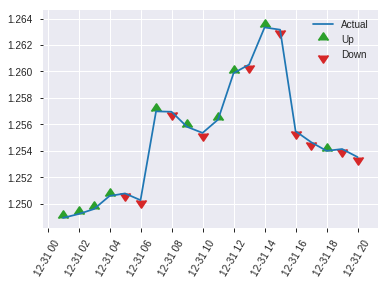


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.20620481560637005
RMSE: 0.4540978040096319
LogLoss: 0.5986630237652323
Mean Per-Class Error: 0.3145240947397179
AUC: 0.748350251140113
pr_auc: 0.7324086082134427
Gini: 0.496700502280226
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3187142312526703: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      143  163  0.5327   (163.0/306.0)
1      41   270  0.1318   (41.0/311.0)
Total  184  433  0.3306   (204.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.318714     0.725806  281
max f2                       0.161481     0.847085  368
max f0point5                 0.564604     0.691164  140
max accuracy                 0.453487     0.685575  205
max precision                0.844771     0.941176  13
max recall                   0.109738     1         395
max specificity              0.92186      0.996732  0
max absolute_mcc             0.385595     0.371671  244
max min_per_class_accuracy   0.463918     0.681672  198
max mean_per_class_accuracy  0.453487     0.685476  205

Gains/Lift Table: Avg response rate: 50.41 %, avg score: 45.69 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0113452                   0.877589           1.70051   1.70051            0.857143         0.890343  0.857143                    0.890343            0.0192926       0.0192926                  70.0505    70.0505
    2        0.0210697                   0.852452           1.98392   1.83131            1                0.861115  0.923077                    0.876853            0.0192926       0.0385852                  98.3923    83.1313
    3        0.0307942                   0.830169           1.65327   1.77509            0.833333         0.840868  0.894737                    0.865489            0.0160772       0.0546624                  65.3269    77.5089
    4        0.0405186                   0.80152            1.98392   1.82521            1                0.817422  0.92                        0.853953            0.0192926       0.073955                   98.3923    82.5209
    5        0.0502431                   0.775306           0.991961  1.66394            0.5              0.787101  0.83871                     0.841014            0.0096463       0.0836013                  -0.803859  66.3935
    6        0.100486                    0.714112           1.66394   1.66394            0.83871          0.740312  0.83871                     0.790663            0.0836013       0.167203                   66.3935    66.3935
    7        0.150729                    0.682088           1.53594   1.62127            0.774194         0.697719  0.817204                    0.759681            0.0771704       0.244373                   53.594     62.127
    8        0.200972                    0.645634           1.21595   1.51994            0.612903         0.664445  0.766129                    0.735872            0.0610932       0.305466                   21.5953    51.9941
    9        0.299838                    0.580375           1.5286    1.52279            0.770492         0.61321   0.767568                    0.695427            0.151125        0.456592                   52.8596    52.2795
    10       0.400324                    0.528109           1.02396   1.39758            0.516129         0.554594  0.704453                    0.660076            0.102894        0.559486                   2.39602    39.7581
    11       0.50081                     0.462754           1.21595   1.36114            0.612903         0.494958  0.686084                    0.626946            0.122186        0.681672                   21.5953    36.1138
    12       0.599676                    0.389224           0.943176  1.29223            0.47541          0.428207  0.651351                    0.594181            0.0932476       0.77492                    -5.68236   29.2231
    13       0.700162                    0.320563           0.895965  1.23536            0.451613         0.353059  0.622685                    0.559575            0.0900322       0.864952                   -10.4035   23.5359
    14       0.799028                    0.254468           0.552897  1.15092            0.278689         0.289842  0.580122                    0.5262              0.0546624       0.919614                   -44.7103   15.0917
    15       0.899514                    0.185078           0.543979  1.08311            0.274194         0.219221  0.545946                    0.491907            0.0546624       0.974277                   -45.6021   8.31146
    16       1                           0.0926716          0.25599   1                  0.129032         0.143531  0.504052                    0

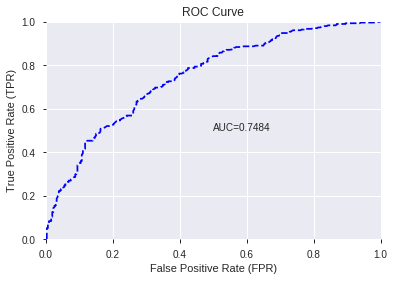

This function is available for GLM models only


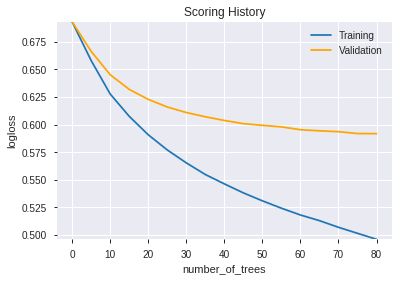

--2019-08-24 17:49:03--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.166.91
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.166.91|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.indexOf(String.java:1578)
	at java.base/java.lang.String.indexOf(String.java:1535)
	at java.base/java.lang.String.split(String.java:2274)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.j

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190824_174700_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190824_174700_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_9a5d',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

In [19]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190824_175000_model_6  0.746322  0.592629              0.338845  0.451929  0.204240
1  DeepLearning_grid_1_AutoML_20190824_175000_model_5  0.739834  0.605781              0.315680  0.457303  0.209126
2  DeepLearning_grid_1_AutoML_20190824_175000_model_9  0.739440  0.606729              0.357003  0.458471  0.210195
3  DeepLearning_grid_1_AutoML_20190824_175000_model_4  0.738841  0.654797              0.325274  0.469373  0.220311
4  DeepLearning_grid_1_AutoML_20190824_175000_model_8  0.736797  0.638280              0.335419  0.467128  0.218208
5  DeepLearning_grid_1_AutoML_20190824_175000_model_7  0.727960  0.803538              0.372129  0.509526  0.259617
6  DeepLearning_grid_1_AutoML_20190824_175000_model_3  0.727776  0.740306              0.356740  0.472614  0.223364
7               DeepLearning_1_AutoML_20190824_175000  0.721497  0.682615              0.360297  0.482425  0.232733
8  DeepLearning_grid_1_AutoML_20190824_175000_model_1  0.700676  1.049792              0.356346  0.504892  0.254916
9  DeepLearning_grid_1_AutoML_20190824_175000_model_2  0.647831  0.936050              0.434246  0.528079  0.278868

variable  relative_importance  scaled_importance  percentage
0                   BOP             1.000000           1.000000    0.050969
1    CDLCLOSINGMARUBOZU             0.719882           0.719882    0.036692
2          CDLSHORTLINE             0.593456           0.593456    0.030248
3                   DIV             0.490765           0.490765    0.025014
4          STOCHF_fastk             0.440793           0.440793    0.022467
5                   SUB             0.439087           0.439087    0.022380
6                TRANGE             0.428186           0.428186    0.021824
7             CDLTAKURI             0.424431           0.424431    0.021633
8                  hour             0.416976           0.416976    0.021253
9             CORREL_30             0.413049           0.413049    0.021053
10            CDLHAMMER             0.402804           0.402804    0.020531
11       STOCHRSI_fastk             0.400859           0.400859    0.020432
12               ULTOSC             0.392937           0.392937    0.020028
13     is_quarter_start             0.391477           0.391477    0.019953
14              quarter             0.389267           0.389267    0.019841
15   CDLIDENTICAL3CROWS             0.389100           0.389100    0.019832
16                  day             0.387403           0.387403    0.019746
17         aroondown_12             0.378111           0.378111    0.019272
18       CDLMORNINGSTAR             0.375176           0.375176    0.019122
19           aroonup_20             0.374842           0.374842    0.019105
20    CDLSTALLEDPATTERN             0.373197           0.373197    0.019022
21                CCI_8             0.373071           0.373071    0.019015
22            CORREL_24             0.371132           0.371132    0.018916
23               Volume             0.370926           0.370926    0.018906
24         HT_TRENDMODE             0.365234           0.365234    0.018616
25    CDLGRAVESTONEDOJI             0.362869           0.362869    0.018495
26               SAREXT             0.361657           0.361657    0.018433
27            aroonup_8             0.357359           0.357359    0.018214
28         aroondown_24             0.355138           0.355138    0.018101
29   CDLMORNINGDOJISTAR             0.354273           0.354273    0.018057
30           aroonup_12             0.353952           0.353952    0.018041
31            CDLONNECK             0.353399           0.353399    0.018012
32                   AD             0.352715           0.352715    0.017978
33   CDLEVENINGDOJISTAR             0.352565           0.352565    0.017970
34  CDLGAPSIDESIDEWHITE             0.352420           0.352420    0.017963
35          CDLPIERCING             0.349991           0.349991    0.017839
36         CDLTHRUSTING             0.349515           0.349515    0.017815
37    CDLDARKCLOUDCOVER             0.348909           0.348909    0.017784
38          aroondown_8             0.344556           0.344556    0.017562
39            CDLINNECK             0.341543           0.341543    0.017408
40         aroondown_30             0.338771           0.338771    0.017267
41      CDLHOMINGPIGEON             0.337726           0.337726    0.017214
42    CDLINVERTEDHAMMER             0.333679           0.333679    0.017007
43          HT_DCPERIOD             0.332442           0.332442    0.016944
44           aroonup_14             0.323306           0.323306    0.016479
45  CDLRISEFALL3METHODS             0.320736           0.320736    0.016348
46      CDLUNIQUE3RIVER             0.319621           0.319621    0.016291
47         is_month_end             0.315969           0.315969    0.016105
48        CDLHIKKAKEMOD             0.313849           0.313849    0.015997
49      CDLADVANCEBLOCK             0.290521           0.290521    0.014808

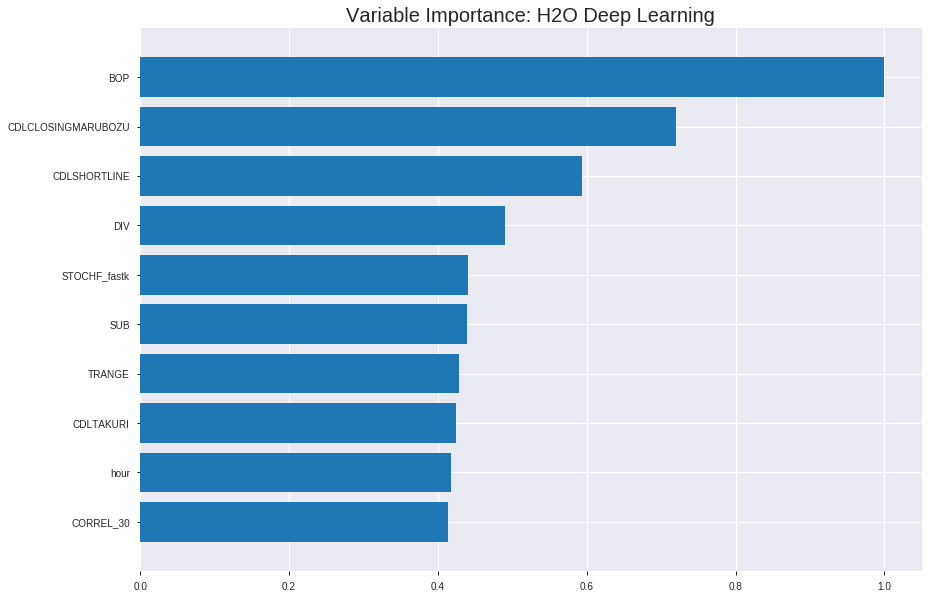

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190824_175000_model_6


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.19935398562451587
RMSE: 0.44649074528428456
LogLoss: 0.5813313237639981
Mean Per-Class Error: 0.2995420646765099
AUC: 0.7712786706865482
pr_auc: 0.7686620076537294
Gini: 0.5425573413730964
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4596661563454036: 


0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      1003  1170  0.5384   (1170.0/2173.0)
1      274   1866  0.128    (274.0/2140.0)
Total  1277  3036  0.3348   (1444.0/4313.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.459666     0.72102   251
max f2                       0.286639     0.841463  324
max f0point5                 0.651298     0.706393  153
max accuracy                 0.57311      0.700672  191
max precision                0.991631     1         0
max recall                   0.12351      1         381
max specificity              0.991631     1         0
max absolute_mcc             0.603025     0.402222  176
max min_per_class_accuracy   0.552804     0.696729  200
max mean_per_class_accuracy  0.57311      0.700458  191

Gains/Lift Table: Avg response rate: 49.62 %, avg score: 56.49 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102017                   0.97536            2.01542   2.01542            1                0.982322  1                           0.982322            0.0205607       0.0205607                  101.542   101.542
    2        0.0201716                   0.962624           1.96855   1.99225            0.976744         0.968856  0.988506                    0.975666            0.0196262       0.0401869                  96.855    99.2255
    3        0.0301414                   0.951143           1.87481   1.95341            0.930233         0.956838  0.969231                    0.969438            0.0186916       0.0588785                  87.481    95.3408
    4        0.0401113                   0.93929            1.82794   1.92222            0.906977         0.945526  0.953757                    0.963495            0.0182243       0.0771028                  82.794    92.2222
    5        0.0500812                   0.929165           1.82794   1.90345            0.906977         0.934191  0.944444                    0.957661            0.0182243       0.0953271                  82.794    90.3453
    6        0.100162                    0.868399           1.69818   1.80082            0.842593         0.896224  0.893519                    0.926943            0.0850467       0.180374                   69.8178   80.0816
    7        0.150012                    0.820154           1.64046   1.74753            0.813953         0.843611  0.867079                    0.899251            0.0817757       0.26215                    64.0459   74.7528
    8        0.200093                    0.778453           1.44625   1.67212            0.717593         0.79979   0.829664                    0.874357            0.0724299       0.334579                   44.6251   67.2122
    9        0.300023                    0.697482           1.41687   1.5871             0.703016         0.738863  0.787481                    0.829228            0.141589        0.476168                   41.6873   58.7105
    10       0.399954                    0.623987           1.18774   1.48732            0.589327         0.661197  0.737971                    0.787244            0.118692        0.59486                    18.7742   48.7322
    11       0.500116                    0.548878           1.04503   1.39874            0.518519         0.5856    0.694019                    0.746859            0.104673        0.699533                   4.50329   39.8741
    12       0.600046                    0.510783           0.855735  1.30831            0.424594         0.527332  0.64915                     0.7103              0.085514        0.785047                   -14.4265  30.831
    13       0.699977                    0.461599           0.832355  1.24036            0.412993         0.48924   0.615436                    0.678741            0.0831776       0.868224                   -16.7645  24.0362
    14       0.799907                    0.364515           0.668689  1.16894            0.331787         0.41713   0.58                        0.646058            0.0668224       0.935047                   -33.1311  16.8944
    15       0.899838                    0.24626            0.392797  1.08275            0.194896         0.306783  0.537233                    0.608381            0.0392523       0.974299                   -60.7203  8.27498
    16       1                           0.0509414          0.256593  1                  0.127315         0.17432   0.496174                    0.564904          



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2072859901853707
RMSE: 0.4552867120676494
LogLoss: 0.6000591236920731
Mean Per-Class Error: 0.3164400168669619
AUC: 0.7408193653805608
pr_auc: 0.7372308046953098
Gini: 0.4816387307611216
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4362344396118816: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      292  328  0.529    (328.0/620.0)
1      102  510  0.1667   (102.0/612.0)
Total  394  838  0.349    (430.0/1232.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.436234     0.703448  243
max f2                       0.159285     0.840022  366
max f0point5                 0.563874     0.693789  165
max accuracy                 0.563874     0.684253  165
max precision                0.988395     1         0
max recall                   0.0662462    1         398
max specificity              0.988395     1         0
max absolute_mcc             0.563874     0.37598   165
max min_per_class_accuracy   0.519952     0.677419  192
max mean_per_class_accuracy  0.563874     0.68356   165

Gains/Lift Table: Avg response rate: 49.68 %, avg score: 51.52 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105519                   0.959131           1.85822   1.85822            0.923077         0.972361  0.923077                    0.972361            0.0196078       0.0196078                  85.822    85.822
    2        0.0202922                   0.935876           2.01307   1.93255            1                0.945082  0.96                        0.959267            0.0196078       0.0392157                  101.307   93.2549
    3        0.0300325                   0.918022           2.01307   1.95866            1                0.930112  0.972973                    0.949811            0.0196078       0.0588235                  101.307   95.8665
    4        0.0405844                   0.905982           2.01307   1.97281            1                0.911721  0.98                        0.939908            0.0212418       0.0800654                  101.307   97.281
    5        0.0503247                   0.895002           1.84532   1.94813            0.916667         0.89855   0.967742                    0.931903            0.0179739       0.0980392                  84.5316   94.8134
    6        0.100649                    0.793129           1.39616   1.67215            0.693548         0.839521  0.830645                    0.885712            0.0702614       0.168301                   39.6163   67.2148
    7        0.150162                    0.740129           1.55106   1.63222            0.770492         0.766126  0.810811                    0.846281            0.0767974       0.245098                   55.1055   63.222
    8        0.200487                    0.691046           1.52604   1.60557            0.758065         0.71807   0.797571                    0.814098            0.0767974       0.321895                   52.6038   60.5567
    9        0.300325                    0.615133           1.35841   1.52341            0.674797         0.650813  0.756757                    0.759817            0.135621        0.457516                   35.8414   52.3406
    10       0.400162                    0.556315           1.26022   1.45774            0.626016         0.583578  0.724138                    0.715846            0.125817        0.583333                   26.0216   45.7742
    11       0.5                         0.519539           0.96562   1.35948            0.479675         0.532882  0.675325                    0.679313            0.0964052       0.679739                   -3.43801  35.9477
    12       0.599838                    0.48014            0.851055  1.27485            0.422764         0.503993  0.633288                    0.650133            0.0849673       0.764706                   -14.8945  27.4855
    13       0.699675                    0.412723           0.785589  1.20504            0.390244         0.452675  0.598608                    0.621957            0.0784314       0.843137                   -21.4411  20.5041
    14       0.799513                    0.325083           0.654658  1.13631            0.325203         0.372677  0.564467                    0.590829            0.0653595       0.908497                   -34.5342  13.6313
    15       0.899351                    0.216847           0.540092  1.07013            0.268293         0.275121  0.531588                    0.555782            0.0539216       0.962418                   -45.9908  7.01258
    16       1                           0.0598084          0.373392  1                  0.185484         0.152133  0.496753                    0.515155            


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 17:57:06  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-24 17:57:08  4 min  3.483 sec  964 obs/sec       0.564109  1             2433       0.560223         1.10471             -0.255472      0.731845        0.698368           1.55737          0.376072                         0.564338           1.11904               -0.273963        0.71143           0.697374             1.85822            0.393669
    2019-08-24 17:57:24  4 min 19.300 sec  2463 obs/sec      9.61094   17            41452      0.446491         0.581331            0.202537       0.771279        0.768662           2.01542          0.334802                         0.455287           0.600059              0.170821         0.740819          0.737231             1.85822            0.349026
    2019-08-24 17:57:39  4 min 34.601 sec  2856 obs/sec      20.2812   36            87473      0.438203         0.564527            0.231867       0.780267        0.777485           1.96962          0.320195                         0.464481           0.621678              0.136993         0.734639          0.729276             2.01307            0.343344
    2019-08-24 17:57:55  4 min 50.043 sec  3056 obs/sec      31.5704   56            136163     0.433889         0.554971            0.246919       0.788409        0.78844            2.01542          0.302574                         0.46099            0.612624              0.149918         0.73086           0.727676             1.85822            0.340097
    2019-08-24 17:58:10  5 min  5.578 sec  3196 obs/sec      43.4231   77            187284     0.428003         0.543376            0.26721        0.801209        0.797599           2.01542          0.281475                         0.466269           0.628949              0.130337         0.7259            0.723296             1.70337            0.382305
    2019-08-24 17:58:25  5 min 20.751 sec  3299 obs/sec      55.2567   98            238322     0.421545         0.529405            0.289159       0.814324        0.810315           2.01542          0.277997                         0.464602           0.624678              0.136542         0.729459          0.718877             1.70337            0.349838
    2019-08-24 17:58:41  5 min 36.307 sec  3383 obs/sec      67.6738   120           291877     0.42068          0.529827            0.29207        0.817806        0.806758           2.01542          0.266172                         0.465117           0.631272              0.134628         0.722108          0.715434             1.70337            0.383117
    2019-08-24 17:58:43  5 min 37.852 sec  3382 obs/sec      67.6738   120           291877     0.446491         0.581331            0.202537       0.771279        0.768662           2.01542          0.334802                         0.455287           0.600059              0.170821         0.740819          0.737231             1.85822            0.349026

Variable Importances: 


variable             relative_importance    scaled_importance    percentage
-------------------  ---------------------  -------------------  --------------------
BOP                  1.0                    1.0                  0.05096933444122031
CDLCLOSINGMARUBOZU   0.7198820114135742     0.7198820114135742   0.03669190699795684
CDLSHORTLINE         0.5934558510780334     0.5934558510780334   0.03024804974969532
DIV                  0.4907652735710144     0.4907652735710144   0.02501397936077801
STOCHF_fastk         0.440792977809906      0.440792977809906    0.0224669247053345
---                  ---                    ---                  ---
CDLRISEFALL3METHODS  0.32073602080345154    0.32073602080345154  0.016347701511677314
CDLUNIQUE3RIVER      0.31962069869041443    0.31962069869041443  0.016290854285888237
is_month_end         0.31596899032592773    0.31596899032592773  0.016104729140976912
CDLHIKKAKEMOD        0.3138490319252014     0.3138490319252014   0.01599667627224882
CDLADVANCEBLOCK      0.2905212938785553     0.2905212938785553   0.014807676989992134


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6871961102106969)

('F1', 0.723404255319149)

('auc', 0.7463222159174495)

('logloss', 0.5926289288535016)

('mean_per_class_error', 0.3133366958787802)

('rmse', 0.45192875835664853)

('mse', 0.204239602629782)

deeplearning prediction progress: |███████████████████████████████████████| 100%


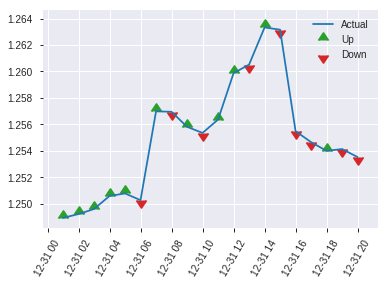


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.204239602629782
RMSE: 0.45192875835664853
LogLoss: 0.5926289288535016
Mean Per-Class Error: 0.3133366958787802
AUC: 0.7463222159174495
pr_auc: 0.7422456831429728
Gini: 0.49264443183489903
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3655461998762683: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      137  169  0.5523   (169.0/306.0)
1      39   272  0.1254   (39.0/311.0)
Total  176  441  0.3371   (208.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.365546     0.723404  277
max f2                       0.152212     0.844761  373
max f0point5                 0.531865     0.693324  179
max accuracy                 0.486048     0.687196  217
max precision                0.994061     1         0
max recall                   0.113359     1         389
max specificity              0.994061     1         0
max absolute_mcc             0.486048     0.376739  217
max min_per_class_accuracy   0.509702     0.679739  199
max mean_per_class_accuracy  0.486048     0.686663  217

Gains/Lift Table: Avg response rate: 50.41 %, avg score: 50.34 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.959319           1.98392   1.98392            1                0.973479  1                           0.973479            0.022508        0.022508                   98.3923   98.3923
    2        0.0210697                   0.947228           1.98392   1.98392            1                0.953136  1                           0.96409             0.0192926       0.0418006                  98.3923   98.3923
    3        0.0307942                   0.931923           1.65327   1.87951            0.833333         0.937977  0.947368                    0.955844            0.0160772       0.0578778                  65.3269   87.9506
    4        0.0405186                   0.922387           1.98392   1.90457            1                0.92781   0.96                        0.949116            0.0192926       0.0771704                  98.3923   90.4566
    5        0.0502431                   0.910263           1.65327   1.85593            0.833333         0.917091  0.935484                    0.942917            0.0160772       0.0932476                  65.3269   85.5928
    6        0.100486                    0.793392           1.59994   1.72793            0.806452         0.850036  0.870968                    0.896477            0.0803859       0.173633                   59.9938   72.7933
    7        0.150729                    0.740277           1.47194   1.6426             0.741935         0.766154  0.827957                    0.853036            0.073955        0.247588                   47.1943   64.2603
    8        0.200972                    0.702342           1.21595   1.53594            0.612903         0.718599  0.774194                    0.819427            0.0610932       0.308682                   21.5953   53.594
    9        0.299838                    0.618642           1.36598   1.4799             0.688525         0.656323  0.745946                    0.765646            0.135048        0.44373                    36.598    47.9899
    10       0.400324                    0.546854           1.24795   1.42168            0.629032         0.579412  0.716599                    0.718899            0.125402        0.569132                   24.7951   42.1677
    11       0.50081                     0.510025           1.08796   1.35472            0.548387         0.525919  0.682848                    0.680178            0.109325        0.678457                   8.79577   35.4718
    12       0.599676                    0.464446           0.9757    1.29223            0.491803         0.489694  0.651351                    0.648774            0.096463        0.77492                    -2.43002  29.2231
    13       0.700162                    0.376591           0.799969  1.22158            0.403226         0.419974  0.615741                    0.615937            0.0803859       0.855305                   -20.0031  22.1582
    14       0.799028                    0.290737           0.715513  1.15897            0.360656         0.337849  0.584178                    0.581529            0.0707395       0.926045                   -28.4487  15.8965
    15       0.899514                    0.194839           0.479981  1.08311            0.241935         0.247147  0.545946                    0.544174            0.0482315       0.974277                   -52.0019  8.31146
    16       1                           0.0390757          0.25599   1                  0.129032         0.138774  0.504052                    0.503437          

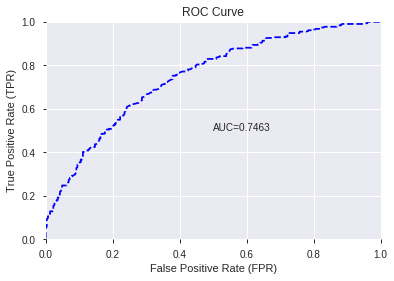

This function is available for GLM models only


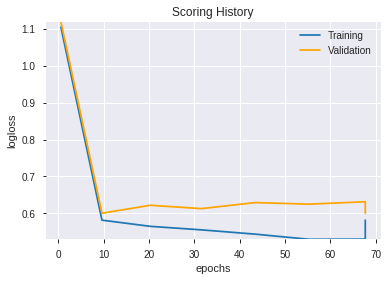

--2019-08-24 18:09:43--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.20.8
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.20.8|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190824_175000_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190824_175000_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_9a5d',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'CDLCLOSINGMARUBOZU',
 'CDLSHORTLINE',
 'DIV',
 'STOCHF_fastk',
 'SUB',
 'TRANGE',
 'CDLTAKURI',
 'hour',
 'CORREL_30',
 'CDLHAMMER',
 'STOCHRSI_fastk',
 'ULTOSC',
 'is_quarter_start',
 'quarter',
 'CDLIDENTICAL3CROWS',
 'day',
 'aroondown_12',
 'CDLMORNINGSTAR',
 'aroonup_20',
 'CDLSTALLEDPATTERN',
 'CCI_8',
 'CORREL_24',
 'Volume',
 'HT_TRENDMODE',
 'CDLGRAVESTONEDOJI',
 'SAREXT',
 'aroonup_8',
 'aroondown_24',
 'CDLMORNINGDOJISTAR',
 'aroonup_12',
 'CDLONNECK',
 'AD',
 'CDLEVENINGDOJISTAR',
 'CDLGAPSIDESIDEWHITE',
 'CDLPIERCING',
 'CDLTHRUSTING',
 'CDLDARKCLOUDCOVER',
 'aroondown_8',
 'CDLINNECK',
 'aroondown_30',
 'CDLHOMINGPIGEON',
 'CDLINVERTEDHAMMER',
 'HT_DCPERIOD',
 'aroonup_14',
 'CDLRISEFALL3METHODS',
 'CDLUNIQUE3RIVER',
 'is_month_end',
 'CDLHIKKAKEMOD',
 'CDLADVANCEBLOCK']

In [20]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190824_181040_model_1  0.737469  0.615263              0.355421  0.461414  0.212903

variable  relative_importance  scaled_importance  percentage
0                   BOP             0.416078           1.000000    0.156055
1    CDLCLOSINGMARUBOZU             0.192194           0.461919    0.072085
2          STOCHF_fastk             0.135585           0.325864    0.050853
3             CDLHAMMER             0.112161           0.269568    0.042067
4        STOCHRSI_fastk             0.098492           0.236716    0.036941
5                   SUB             0.094365           0.226797    0.035393
6                   DIV             0.093072           0.223689    0.034908
7                TRANGE             0.091654           0.220281    0.034376
8             CDLTAKURI             0.091613           0.220181    0.034360
9          CDLSHORTLINE             0.089493           0.215087    0.033565
10                CCI_8             0.083611           0.200951    0.031359
11               ULTOSC             0.080394           0.193218    0.030153
12              quarter             0.070889           0.170373    0.026588
13    CDLGRAVESTONEDOJI             0.070087           0.168447    0.026287
14       CDLMORNINGSTAR             0.064222           0.154350    0.024087
15           aroonup_20             0.058143           0.139739    0.021807
16               Volume             0.048316           0.116121    0.018121
17                  day             0.046763           0.112390    0.017539
18            CDLONNECK             0.045795           0.110063    0.017176
19                 hour             0.044620           0.107240    0.016735
20               SAREXT             0.042998           0.103340    0.016127
21           aroonup_12             0.042448           0.102020    0.015921
22   CDLIDENTICAL3CROWS             0.042214           0.101456    0.015833
23    CDLSTALLEDPATTERN             0.040114           0.096409    0.015045
24         aroondown_24             0.038312           0.092078    0.014369
25            aroonup_8             0.032508           0.078129    0.012192
26    CDLINVERTEDHAMMER             0.031278           0.075175    0.011731
27    CDLDARKCLOUDCOVER             0.030954           0.074394    0.011609
28            CORREL_24             0.029394           0.070645    0.011024
29         aroondown_12             0.028566           0.068655    0.010714
30  CDLGAPSIDESIDEWHITE             0.021604           0.051924    0.008103
31          aroondown_8             0.021326           0.051254    0.007998
32        CDLHIKKAKEMOD             0.020081           0.048262    0.007532
33           aroonup_14             0.019428           0.046692    0.007287
34      CDLADVANCEBLOCK             0.019065           0.045822    0.007151
35            CORREL_30             0.017548           0.042175    0.006582
36      CDLHOMINGPIGEON             0.017100           0.041097    0.006413
37      CDLUNIQUE3RIVER             0.016709           0.040158    0.006267
38  CDLRISEFALL3METHODS             0.014929           0.035880    0.005599
39                   AD             0.014020           0.033695    0.005258
40         CDLTHRUSTING             0.013707           0.032943    0.005141
41   CDLEVENINGDOJISTAR             0.013052           0.031369    0.004895
42            CDLINNECK             0.011700           0.028120    0.004388
43         is_month_end             0.011691           0.028098    0.004385
44         HT_TRENDMODE             0.011330           0.027230    0.004249
45         aroondown_30             0.009808           0.023573    0.003679
46          HT_DCPERIOD             0.009377           0.022536    0.003517
47   CDLMORNINGDOJISTAR             0.009275           0.022291    0.003479
48          CDLPIERCING             0.006684           0.016064    0.002507
49     is_quarter_start             0.001468           0.003527    0.000550

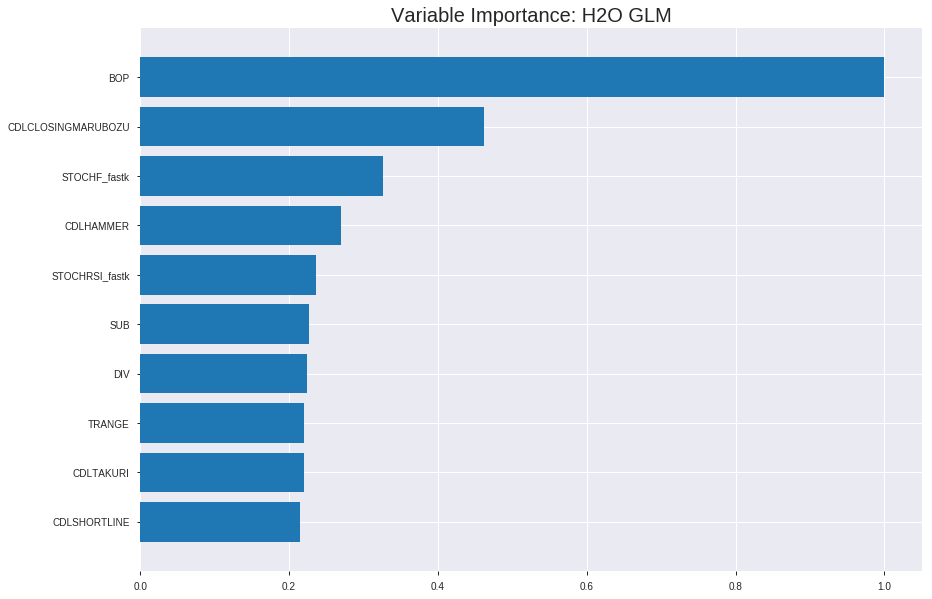

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190824_181040_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.20180171851644632
RMSE: 0.44922346167185695
LogLoss: 0.5900169914523389
Null degrees of freedom: 4312
Residual degrees of freedom: 4262
Null deviance: 5978.835084581811
Residual deviance: 5089.486568267876
AIC: 5191.486568267876
AUC: 0.7596868535252096
pr_auc: 0.7527962542692362
Gini: 0.5193737070504192
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3890811794549461: 


0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      1015  1158  0.5329   (1158.0/2173.0)
1      297   1843  0.1388   (297.0/2140.0)
Total  1312  3001  0.3374   (1455.0/4313.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.389081     0.716981  259
max f2                       0.244152     0.836269  337
max f0point5                 0.540531     0.700041  171
max accuracy                 0.510384     0.696963  189
max precision                0.908603     1         0
max recall                   0.088586     1         393
max specificity              0.908603     1         0
max absolute_mcc             0.510384     0.393863  189
max min_per_class_accuracy   0.506604     0.69486   191
max mean_per_class_accuracy  0.510384     0.696897  189

Gains/Lift Table: Avg response rate: 49.62 %, avg score: 49.62 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102017                   0.832983           1.87801   1.87801            0.931818         0.856517  0.931818                    0.856517            0.0191589       0.0191589                  87.8006   87.8006
    2        0.0201716                   0.81302            1.87481   1.87643            0.930233         0.823464  0.931034                    0.84018             0.0186916       0.0378505                  87.481    87.6426
    3        0.0301414                   0.7966             1.92168   1.89139            0.953488         0.80409   0.938462                    0.828243            0.0191589       0.0570093                  92.168    89.1395
    4        0.0401113                   0.785648           1.7342    1.85232            0.860465         0.791013  0.919075                    0.818989            0.0172897       0.0742991                  73.4199   85.2323
    5        0.0500812                   0.771701           1.78107   1.83814            0.883721         0.778379  0.912037                    0.810905            0.017757        0.0920561                  78.1069   83.8138
    6        0.100162                    0.726469           1.70751   1.77282            0.847222         0.746738  0.87963                     0.778821            0.085514        0.17757                    70.7509   77.2824
    7        0.150012                    0.691215           1.61234   1.71949            0.8              0.707928  0.853168                    0.755263            0.0803738       0.257944                   61.2336   71.9493
    8        0.200093                    0.663017           1.45558   1.65344            0.722222         0.677792  0.820394                    0.735873            0.0728972       0.330841                   45.5582   65.3439
    9        0.300023                    0.610833           1.32335   1.54349            0.656613         0.637101  0.765842                    0.702974            0.132243        0.463084                   32.335    54.3494
    10       0.399954                    0.561751           1.2345    1.46629            0.612529         0.587112  0.727536                    0.674025            0.123364        0.586449                   23.4504   46.6291
    11       0.500116                    0.504401           1.11501   1.39594            0.553241         0.533654  0.692629                    0.645912            0.111682        0.698131                   11.5013   39.5938
    12       0.600046                    0.44445            0.837031  1.30286            0.415313         0.474373  0.646445                    0.617344            0.0836449       0.781776                   -16.2969  30.2859
    13       0.699977                    0.38581            0.804298  1.23168            0.399072         0.415783  0.61113                     0.588569            0.0803738       0.86215                    -19.5702  23.1683
    14       0.799907                    0.331092           0.621928  1.15551            0.308585         0.358535  0.573333                    0.559831            0.0621495       0.924299                   -37.8072  15.5508
    15       0.899838                    0.255583           0.462939  1.0786             0.229698         0.295746  0.535171                    0.530504            0.0462617       0.970561                   -53.7061  7.85953
    16       1                           0.0444519          0.293915  1                  0.145833         0.187768  0.496174                    0.496174         



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.21152646582321497
RMSE: 0.4599200646016816
LogLoss: 0.6108289605505255
Null degrees of freedom: 1231
Residual degrees of freedom: 1181
Null deviance: 1707.8643560108549
Residual deviance: 1505.0825587964948
AIC: 1607.0825587964948
AUC: 0.7359701138519924
pr_auc: 0.7218297132108871
Gini: 0.4719402277039848
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3447926738740435: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      301  319  0.5145   (319.0/620.0)
1      100  512  0.1634   (100.0/612.0)
Total  401  831  0.3401   (419.0/1232.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.344793     0.709633  265
max f2                       0.181179     0.837029  360
max f0point5                 0.51005      0.68127   163
max accuracy                 0.453416     0.678571  194
max precision                0.80119      0.952381  13
max recall                   0.123549     1         382
max specificity              0.867758     0.998387  0
max absolute_mcc             0.453416     0.357431  194
max min_per_class_accuracy   0.440124     0.674194  203
max mean_per_class_accuracy  0.453416     0.678379  194

Gains/Lift Table: Avg response rate: 49.68 %, avg score: 44.55 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105519                   0.806466           1.85822   1.85822            0.923077         0.828613  0.923077                    0.828613            0.0196078       0.0196078                  85.822    85.822
    2        0.0202922                   0.790956           1.84532   1.85203            0.916667         0.801266  0.92                        0.815487            0.0179739       0.0375817                  84.5316   85.2026
    3        0.0300325                   0.773956           1.84532   1.84985            0.916667         0.781676  0.918919                    0.804521            0.0179739       0.0555556                  84.5316   84.985
    4        0.0405844                   0.756993           1.70337   1.81176            0.846154         0.765934  0.9                         0.794488            0.0179739       0.0735294                  70.3369   81.1765
    5        0.0503247                   0.741641           1.67756   1.78579            0.833333         0.747581  0.887097                    0.78541             0.0163399       0.0898693                  67.756    78.579
    6        0.100649                    0.677374           1.52604   1.65591            0.758065         0.703035  0.822581                    0.744222            0.0767974       0.166667                   52.6038   65.5914
    7        0.150162                    0.644216           1.65006   1.65398            0.819672         0.660181  0.821622                    0.716512            0.0816993       0.248366                   65.0059   65.3983
    8        0.200487                    0.61147            1.26629   1.55667            0.629032         0.625853  0.773279                    0.693755            0.0637255       0.312092                   26.6287   55.6667
    9        0.300325                    0.549562           1.40751   1.50708            0.699187         0.579388  0.748649                    0.655736            0.140523        0.452614                   40.7514   50.7084
    10       0.400162                    0.49661            1.21112   1.43324            0.601626         0.523111  0.711968                    0.622647            0.120915        0.573529                   21.1116   43.3242
    11       0.5                         0.439011           1.03109   1.35294            0.512195         0.464616  0.672078                    0.591092            0.102941        0.676471                   3.10856   35.2941
    12       0.599838                    0.384211           0.916521  1.2803             0.455285         0.411919  0.635995                    0.56127             0.0915033       0.767974                   -8.34795  28.0303
    13       0.699675                    0.334611           0.785589  1.20971            0.390244         0.358879  0.600928                    0.532391            0.0784314       0.846405                   -21.4411  20.9711
    14       0.799513                    0.288381           0.605558  1.13427            0.300813         0.311508  0.563452                    0.504808            0.0604575       0.906863                   -39.4442  13.4269
    15       0.899351                    0.221876           0.605558  1.07558            0.300813         0.256135  0.534296                    0.477203            0.0604575       0.96732                    -39.4442  7.55763
    16       1                           0.0333974          0.324689  1                  0.16129          0.162277  0.496753                    0.445506            


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-24 18:10:41  0.000 sec   2            20        47            1.37432           1.37455
    2019-08-24 18:10:41  0.025 sec   4            12        48            1.36774           1.36812
    2019-08-24 18:10:41  0.061 sec   6            7.6       49            1.35808           1.35875
    2019-08-24 18:10:41  0.117 sec   8            4.7       50            1.3445            1.34568
    2019-08-24 18:10:41  0.150 sec   10           2.9       51            1.32659           1.3287
    2019-08-24 18:10:41  0.181 sec   12           1.8       51            1.3047            1.3084
    2019-08-24 18:10:41  0.207 sec   14           1.1       51            1.28018           1.28646
    2019-08-24 18:10:41  0.226 sec   16           0.7       51            1.25509           1.26527
    2019-08-24 18:10:41  0.242 sec   18           0.44      51            1.2314            1.24711
    2019-08-24 18:10:41  0.257 sec   20           0.27      51            1.21062           1.23358
    2019-08-24 18:10:41  0.273 sec   22           0.17      51            1.19345           1.22522
    2019-08-24 18:10:41  0.288 sec   24           0.1       51            1.18003           1.22166
    2019-08-24 18:10:41  0.305 sec   26           0.065     51            1.17011           1.22191
    2019-08-24 18:10:41  0.320 sec   28           0.04      51            1.16323           1.22479
    2019-08-24 18:10:41  0.341 sec   30           0.025     51            1.15881           1.22914
    2019-08-24 18:10:41  0.357 sec   32           0.016     51            1.15617           1.23399
    2019-08-24 18:10:41  0.375 sec   34           0.0096    51            1.15472           1.23867

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6823338735818476)

('F1', 0.7205128205128205)

('auc', 0.7374692642330244)

('logloss', 0.6152627363845873)

('mean_per_class_error', 0.3170039720068092)

('rmse', 0.46141424759489863)

('mse', 0.21290310788356642)

glm prediction progress: |████████████████████████████████████████████████| 100%


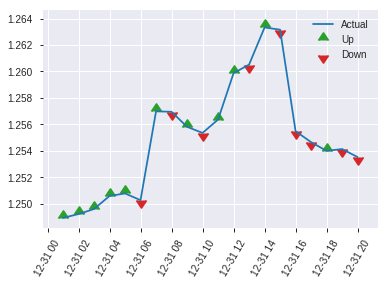


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.21290310788356642
RMSE: 0.46141424759489863
LogLoss: 0.6152627363845873
Null degrees of freedom: 616
Residual degrees of freedom: 566
Null deviance: 855.4562567606156
Residual deviance: 759.2342166985807
AIC: 861.2342166985807
AUC: 0.7374692642330244
pr_auc: 0.7166108500694065
Gini: 0.4749385284660488
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2994060863946193: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      118  188  0.6144   (188.0/306.0)
1      30   281  0.0965   (30.0/311.0)
Total  148  469  0.3533   (218.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.299406     0.720513  296
max f2                       0.207725     0.842603  349
max f0point5                 0.483092     0.694135  169
max accuracy                 0.483092     0.682334  169
max precision                0.726539     0.888889  29
max recall                   0.0793344    1         397
max specificity              0.907835     0.996732  0
max absolute_mcc             0.483092     0.370784  169
max min_per_class_accuracy   0.434834     0.66881   200
max mean_per_class_accuracy  0.483092     0.682996  169

Gains/Lift Table: Avg response rate: 50.41 %, avg score: 44.18 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0113452                   0.814403           1.41709   1.41709            0.714286         0.843229  0.714286                    0.843229            0.0160772       0.0160772                  41.7088    41.7088
    2        0.0210697                   0.776393           1.65327   1.52609            0.833333         0.795419  0.769231                    0.821163            0.0160772       0.0321543                  65.3269    52.6094
    3        0.0307942                   0.76787            1.98392   1.67067            1                0.771074  0.842105                    0.805345            0.0192926       0.0514469                  98.3923    67.0672
    4        0.0405186                   0.754194           1.98392   1.74585            1                0.762929  0.88                        0.795165            0.0192926       0.0707395                  98.3923    74.5852
    5        0.0502431                   0.738649           1.65327   1.72793            0.833333         0.74808   0.870968                    0.786052            0.0160772       0.0868167                  65.3269    72.7933
    6        0.100486                    0.691005           1.59994   1.66394            0.806452         0.711834  0.83871                     0.748943            0.0803859       0.167203                   59.9938    66.3935
    7        0.150729                    0.639661           1.27995   1.53594            0.645161         0.658591  0.774194                    0.718826            0.0643087       0.231511                   27.995     53.594
    8        0.200972                    0.609833           1.47194   1.51994            0.741935         0.623741  0.766129                    0.695054            0.073955        0.305466                   47.1943    51.9941
    9        0.299838                    0.547298           1.49607   1.51207            0.754098         0.579473  0.762162                    0.656944            0.14791         0.453376                   49.6073    51.2071
    10       0.400324                    0.498539           1.15196   1.42168            0.580645         0.524769  0.716599                    0.623766            0.115756        0.569132                   15.1955    42.1677
    11       0.50081                     0.434258           0.991961  1.33546            0.5              0.465657  0.673139                    0.592042            0.0996785       0.66881                    -0.803859  33.5456
    12       0.599676                    0.38205            0.9757    1.27614            0.491803         0.407329  0.643243                    0.56159             0.096463        0.765273                   -2.43002   27.6145
    13       0.700162                    0.324819           0.863966  1.21699            0.435484         0.351504  0.613426                    0.531438            0.0868167       0.85209                    -13.6034   21.699
    14       0.799028                    0.283521           0.715513  1.15494            0.360656         0.304121  0.58215                     0.503312            0.0707395       0.92283                    -28.4487   15.4941
    15       0.899514                    0.206209           0.51198   1.08311            0.258065         0.251492  0.545946                    0.475181            0.0514469       0.974277                   -48.802    8.31146
    16       1                           0.0269691          0.25599   1                  0.129032         0.143081  0.504052                    0.

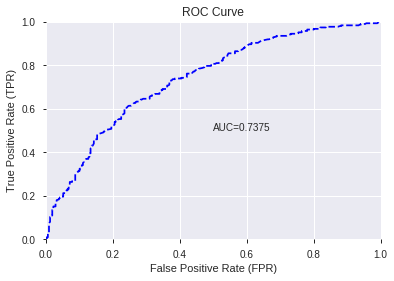

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


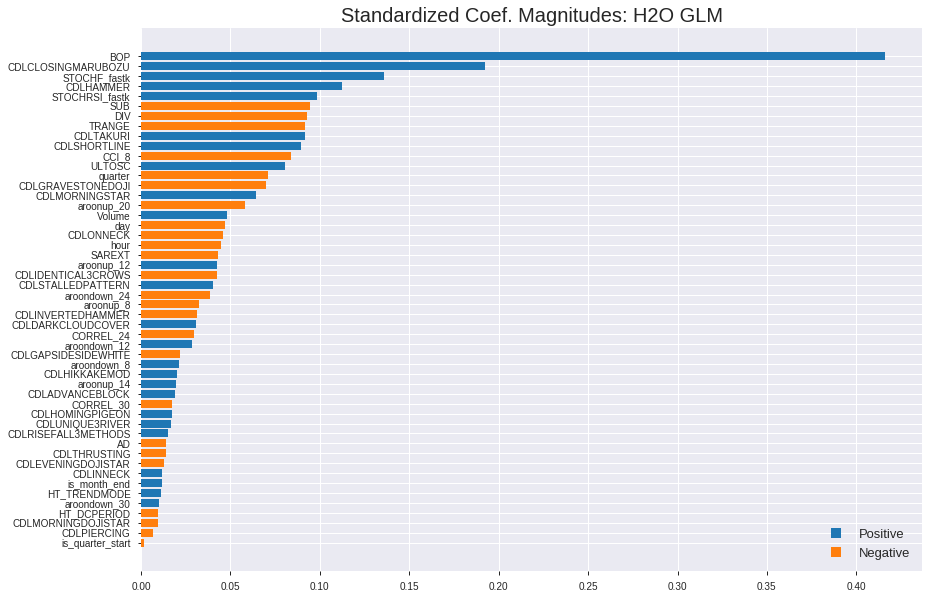

'log_likelihood'
--2019-08-24 18:10:51--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.2.4
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.2.4|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190824_181040_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190824_181040_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_9a5d',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['BOP',
 'CDLCLOSINGMARUBOZU',
 'STOCHF_fastk',
 'CDLHAMMER',
 'STOCHRSI_fastk',
 'SUB',
 'DIV',
 'TRANGE',
 'CDLTAKURI',
 'CDLSHORTLINE',
 'CCI_8',
 'ULTOSC',
 'quarter',
 'CDLGRAVESTONEDOJI',
 'CDLMORNINGSTAR',
 'aroonup_20',
 'Volume',
 'day',
 'CDLONNECK',
 'hour',
 'SAREXT',
 'aroonup_12',
 'CDLIDENTICAL3CROWS',
 'CDLSTALLEDPATTERN',
 'aroondown_24',
 'aroonup_8',
 'CDLINVERTEDHAMMER',
 'CDLDARKCLOUDCOVER',
 'CORREL_24',
 'aroondown_12',
 'CDLGAPSIDESIDEWHITE',
 'aroondown_8',
 'CDLHIKKAKEMOD',
 'aroonup_14',
 'CDLADVANCEBLOCK',
 'CORREL_30',
 'CDLHOMINGPIGEON',
 'CDLUNIQUE3RIVER',
 'CDLRISEFALL3METHODS',
 'AD',
 'CDLTHRUSTING',
 'CDLEVENINGDOJISTAR',
 'CDLINNECK',
 'is_month_end',
 'HT_TRENDMODE',
 'aroondown_30',
 'HT_DCPERIOD',
 'CDLMORNINGDOJISTAR',
 'CDLPIERCING',
 'is_quarter_start']

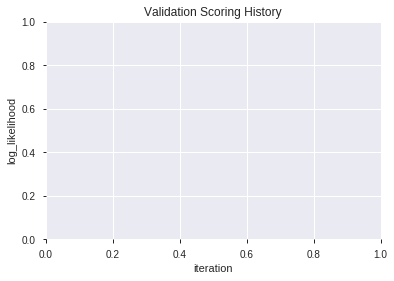

In [21]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_3_AutoML_20190824_181148  0.756541  0.588393              0.308986  0.449387  0.201948
1  XGBoost_grid_1_AutoML_20190824_181148_model_3  0.756131  0.586491              0.309013  0.449146  0.201732
2  XGBoost_grid_1_AutoML_20190824_181148_model_6  0.754876  0.589182              0.317524  0.450355  0.202819
3  XGBoost_grid_1_AutoML_20190824_181148_model_1  0.752716  0.591171              0.305876  0.450986  0.203388
4  XGBoost_grid_1_AutoML_20190824_181148_model_2  0.751650  0.591521              0.339002  0.451301  0.203673
5  XGBoost_grid_1_AutoML_20190824_181148_model_7  0.750814  0.600186              0.301079  0.455112  0.207127
6               XGBoost_1_AutoML_20190824_181148  0.749238  0.600557              0.307405  0.455128  0.207141
7  XGBoost_grid_1_AutoML_20190824_181148_model_5  0.746417  0.609779              0.332046  0.458371  0.210104
8               XGBoost_2_AutoML_20190824_181148  0.745876  0.600309              0.320740  0.455349  0.207343
9  XGBoost_grid_1_AutoML_20190824_181148_model_4  0.745413  0.599279              0.338976  0.454870  0.206907

variable  relative_importance  scaled_importance  percentage
0                  BOP          4753.770508           1.000000    0.316334
1         STOCHF_fastk          1057.338135           0.222421    0.070359
2       STOCHRSI_fastk          1030.604370           0.216797    0.068580
3                  DIV           731.251465           0.153826    0.048660
4                CCI_8           722.412415           0.151966    0.048072
5                 hour           677.335571           0.142484    0.045073
6   CDLCLOSINGMARUBOZU           664.803223           0.139848    0.044239
7               ULTOSC           482.714630           0.101544    0.032122
8                  SUB           461.089294           0.096994    0.030683
9               Volume           441.211060           0.092813    0.029360
10              TRANGE           409.913788           0.086229    0.027277
11                  AD           320.314667           0.067381    0.021315
12              SAREXT           280.920959           0.059094    0.018694
13           CDLHAMMER           280.601013           0.059027    0.018672
14                 day           273.945862           0.057627    0.018229
15          aroonup_20           261.523956           0.055014    0.017403
16           CORREL_30           233.085571           0.049032    0.015510
17           CORREL_24           197.509918           0.041548    0.013143
18        CDLSHORTLINE           194.161438           0.040844    0.012920
19        aroondown_24           192.921204           0.040583    0.012838
20        aroondown_30           190.487091           0.040071    0.012676
21         HT_DCPERIOD           187.133698           0.039365    0.012453
22           aroonup_8           161.441696           0.033961    0.010743
23           CDLTAKURI           145.473007           0.030602    0.009680
24        aroondown_12           138.176270           0.029067    0.009195
25          aroonup_14           131.404373           0.027642    0.008744
26             quarter           110.392342           0.023222    0.007346
27   CDLGRAVESTONEDOJI            90.799919           0.019101    0.006042
28         aroondown_8            89.594902           0.018847    0.005962
29          aroonup_12            69.838791           0.014691    0.004647
30        HT_TRENDMODE            41.463818           0.008722    0.002759
31        is_month_end             4.042474           0.000850    0.000269

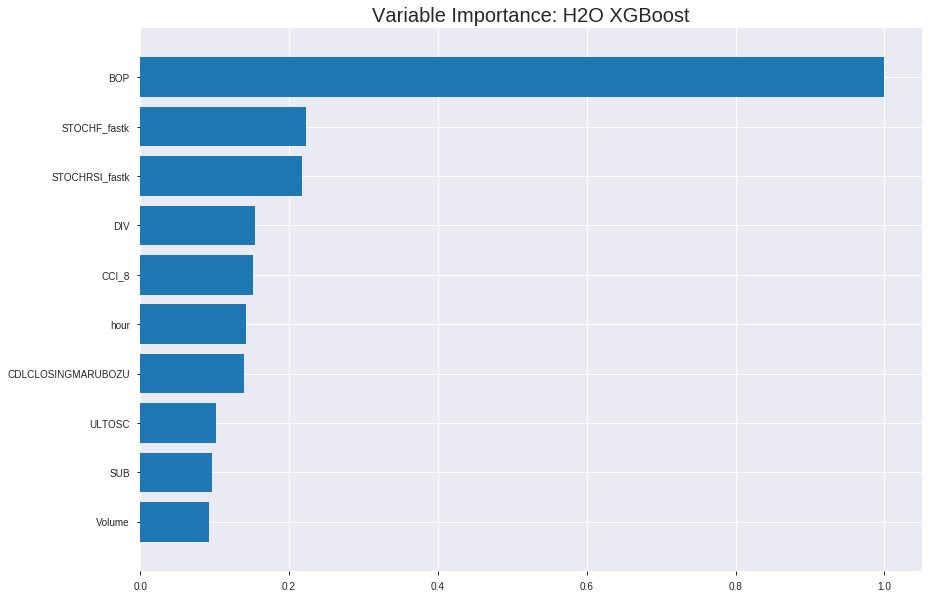

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_3_AutoML_20190824_181148


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.16600551787984483
RMSE: 0.40743774724471077
LogLoss: 0.5054584056499394
Mean Per-Class Error: 0.2350145799553569
AUC: 0.8511694070388067
pr_auc: 0.853353794055249
Gini: 0.7023388140776134
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4216267168521881: 


0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      1374  799   0.3677   (799.0/2173.0)
1      284   1856  0.1327   (284.0/2140.0)
Total  1658  2655  0.2511   (1083.0/4313.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.421627     0.77414   242
max f2                       0.276063     0.86469   313
max f0point5                 0.586856     0.778689  157
max accuracy                 0.518566     0.765129  195
max precision                0.965915     1         0
max recall                   0.138503     1         375
max specificity              0.965915     1         0
max absolute_mcc             0.518566     0.530412  195
max min_per_class_accuracy   0.505742     0.760239  201
max mean_per_class_accuracy  0.518566     0.764985  195

Gains/Lift Table: Avg response rate: 49.62 %, avg score: 49.63 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102017                   0.942937           2.01542    2.01542            1                0.953658  1                           0.953658            0.0205607       0.0205607                  101.542   101.542
    2        0.0201716                   0.914061           2.01542    2.01542            1                0.928069  1                           0.94101             0.0200935       0.0406542                  101.542   101.542
    3        0.0301414                   0.885795           2.01542    2.01542            1                0.900999  1                           0.927776            0.0200935       0.0607477                  101.542   101.542
    4        0.0401113                   0.863249           2.01542    2.01542            1                0.873939  1                           0.914395            0.0200935       0.0808411                  101.542   101.542
    5        0.0500812                   0.841733           2.01542    2.01542            1                0.852826  1                           0.902138            0.0200935       0.100935                   101.542   101.542
    6        0.100162                    0.771816           1.95944    1.98743            0.972222         0.801211  0.986111                    0.851674            0.0981308       0.199065                   95.9437   98.7429
    7        0.150012                    0.731126           1.79044    1.92197            0.888372         0.750428  0.953632                    0.81803             0.0892523       0.288318                   79.0443   92.197
    8        0.200093                    0.696867           1.7355     1.8753             0.861111         0.712919  0.930475                    0.791722            0.0869159       0.375234                   73.5501   87.5299
    9        0.300023                    0.637329           1.50572    1.7522             0.7471           0.669124  0.869397                    0.750888            0.150467        0.525701                   50.572    75.2201
    10       0.399954                    0.568695           1.29529    1.63804            0.642691         0.602616  0.812754                    0.713841            0.129439        0.65514                    29.5293   63.804
    11       0.500116                    0.503817           1.06836    1.52395            0.530093         0.536262  0.756143                    0.678276            0.107009        0.76215                    6.83595   52.3946
    12       0.600046                    0.432782           0.902497   1.42045            0.447796         0.466792  0.704791                    0.643056            0.0901869       0.852336                   -9.75031  42.0451
    13       0.699977                    0.364343           0.715451   1.3198             0.354988         0.397564  0.654853                    0.608009            0.0714953       0.923832                   -28.4549  31.9803
    14       0.799907                    0.281202           0.462939   1.21276            0.229698         0.325662  0.601739                    0.572736            0.0462617       0.970093                   -53.7061  21.2757
    15       0.899838                    0.191988           0.24316    1.10508            0.12065          0.235079  0.548312                    0.535238            0.0242991       0.994393                   -75.684   10.508
    16       1                           0.0602424          0.0559839  1                  0.0277778        0.146089  0.496174                    0.



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.19931156332697567
RMSE: 0.44644323639962974
LogLoss: 0.5807895835876068
Mean Per-Class Error: 0.29527725068522037
AUC: 0.7598619017499473
pr_auc: 0.7536536572918017
Gini: 0.5197238034998946
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.35203638672828674: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      311  309  0.4984   (309.0/620.0)
1      92   520  0.1503   (92.0/612.0)
Total  403  829  0.3255   (401.0/1232.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.352036     0.721721  262
max f2                       0.174913     0.843154  352
max f0point5                 0.480487     0.700132  196
max accuracy                 0.460097     0.704545  207
max precision                0.962099     1         0
max recall                   0.120919     1         380
max specificity              0.962099     1         0
max absolute_mcc             0.460097     0.40999   207
max min_per_class_accuracy   0.476743     0.697712  198
max mean_per_class_accuracy  0.460097     0.704723  207

Gains/Lift Table: Avg response rate: 49.68 %, avg score: 46.99 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105519                   0.935665           2.01307   2.01307            1                0.951348  1                           0.951348            0.0212418       0.0212418                  101.307   101.307
    2        0.0202922                   0.900938           1.84532   1.93255            0.916667         0.920048  0.96                        0.936324            0.0179739       0.0392157                  84.5316   93.2549
    3        0.0300325                   0.868656           1.84532   1.90426            0.916667         0.882676  0.945946                    0.918924            0.0179739       0.0571895                  84.5316   90.4257
    4        0.0405844                   0.842232           2.01307   1.93255            1                0.855822  0.96                        0.902518            0.0212418       0.0784314                  101.307   93.2549
    5        0.0503247                   0.82063            2.01307   1.94813            1                0.830922  0.967742                    0.888661            0.0196078       0.0980392                  101.307   94.8134
    6        0.100649                    0.73424            1.65591   1.80202            0.822581         0.765876  0.895161                    0.827268            0.0833333       0.181373                   65.5914   80.2024
    7        0.150162                    0.703875           1.61706   1.74104            0.803279         0.718512  0.864865                    0.791408            0.0800654       0.261438                   61.7058   74.1035
    8        0.200487                    0.663821           1.29876   1.63002            0.645161         0.683291  0.809717                    0.764269            0.0653595       0.326797                   29.8756   63.0018
    9        0.300325                    0.60146            1.22748   1.4962             0.609756         0.631961  0.743243                    0.720286            0.122549        0.449346                   22.7483   49.6202
    10       0.400162                    0.541808           1.26022   1.43733            0.626016         0.569713  0.713996                    0.682719            0.125817        0.575163                   26.0216   43.7325
    11       0.5                         0.474792           1.24385   1.39869            0.617886         0.50858   0.694805                    0.647948            0.124183        0.699346                   24.3849   39.8693
    12       0.599838                    0.408258           0.818322  1.3021             0.406504         0.442203  0.64682                     0.613703            0.0816993       0.781046                   -18.1678  30.2095
    13       0.699675                    0.334049           0.851055  1.23774            0.422764         0.370405  0.614849                    0.578987            0.0849673       0.866013                   -14.8945  23.7736
    14       0.799513                    0.256213           0.638291  1.16288            0.317073         0.294763  0.577665                    0.543495            0.0637255       0.929739                   -36.1709  16.2881
    15       0.899351                    0.181653           0.45826   1.08466            0.227642         0.218008  0.538809                    0.507362            0.0457516       0.97549                    -54.174   8.46606
    16       1                           0.0745197          0.243517  1                  0.120968         0.134896  0.496753                    0.469874         


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 18:11:54  0.003 sec   0                  0.5              0.693147            0.5             0                  1                0.503826                         0.5                0.693147              0.5               0                    1                  0.503247
    2019-08-24 18:11:54  0.083 sec   5                  0.479864         0.653463            0.782524        0.76               2.01542          0.309993                         0.482956           0.659447              0.743009          0.715749             1.85822            0.338474
    2019-08-24 18:11:54  0.139 sec   10                 0.465844         0.626051            0.790708        0.782586           2.01542          0.299096                         0.472221           0.63823               0.746032          0.724371             1.85822            0.362825
    2019-08-24 18:11:54  0.205 sec   15                 0.455544         0.605633            0.79779         0.791955           2.01542          0.300487                         0.465352           0.624249              0.746007          0.728226             1.85822            0.340909
    2019-08-24 18:11:54  0.273 sec   20                 0.447106         0.588542            0.801844        0.800834           2.01542          0.299791                         0.459992           0.613036              0.747238          0.735422             1.85822            0.342532
    2019-08-24 18:11:54  0.344 sec   25                 0.440466         0.574851            0.807206        0.80742            2.01542          0.294227                         0.456334           0.605018              0.748657          0.738529             1.85822            0.339286
    2019-08-24 18:11:54  0.414 sec   30                 0.435045         0.563449            0.812603        0.813742           2.01542          0.297473                         0.45346            0.598516              0.751361          0.742647             2.01307            0.343344
    2019-08-24 18:11:55  0.485 sec   35                 0.431046         0.554758            0.815328        0.816963           2.01542          0.290749                         0.451559           0.594061              0.752216          0.744969             1.85822            0.348214
    2019-08-24 18:11:55  0.559 sec   40                 0.427204         0.546446            0.820012        0.822846           2.01542          0.288662                         0.450191           0.590607              0.753674          0.747383             1.85822            0.349026
    2019-08-24 18:11:55  0.634 sec   45                 0.423906         0.539443            0.825119        0.828424           2.01542          0.277765                         0.448777           0.58742               0.75667           0.75145              2.01307            0.347403
    2019-08-24 18:11:55  0.710 sec   50                 0.420712         0.532705            0.829966        0.83316            2.01542          0.276374                         0.448331           0.586011              0.75679           0.752206             2.01307            0.342532
    2019-08-24 18:11:55  0.791 sec   55                 0.417503         0.526007            0.834828        0.838336           2.01542          0.268491                         0.447965           0.584879              0.756963          0

Variable Importances: 


variable           relative_importance    scaled_importance      percentage
-----------------  ---------------------  ---------------------  ---------------------
BOP                4753.7705078125        1.0                    0.31633434581719355
STOCHF_fastk       1057.338134765625      0.22242094628420983    0.07035938453885666
STOCHRSI_fastk     1030.6043701171875     0.21679724934627345    0.0685804160469204
DIV                731.25146484375        0.15382557143681794    0.04866031151042178
CCI_8              722.4124145507812      0.1519661947003006     0.04807212678684786
---                ---                    ---                    ---
CDLGRAVESTONEDOJI  90.79991912841797      0.019100610553074545   0.006042179144015819
aroondown_8        89.59490203857422      0.018847123960092534   0.005961992628451426
aroonup_12         69.83879089355469      0.014691241568935514   0.004647344290951576
HT_TRENDMODE       41.46381759643555      0.008722301072021162   0.00275916340363842
is_month_end       4.042473793029785      0.0008503720965045017  0.0002690019008489469


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.700162074554295)

('F1', 0.7285714285714286)

('auc', 0.7565412016896791)

('logloss', 0.588392565268724)

('mean_per_class_error', 0.30058003908959086)

('rmse', 0.4493865824525408)

('mse', 0.20194830048837425)

xgboost prediction progress: |████████████████████████████████████████████| 100%


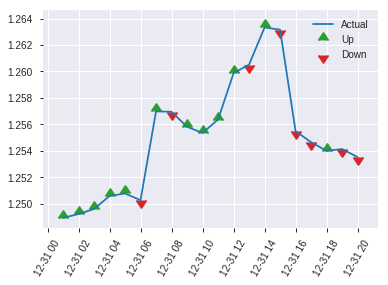


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.20194830048837425
RMSE: 0.4493865824525408
LogLoss: 0.588392565268724
Mean Per-Class Error: 0.30058003908959086
AUC: 0.7565412016896791
pr_auc: 0.7455686878788074
Gini: 0.5130824033793582
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3814869523048401: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      172  134  0.4379   (134.0/306.0)
1      56   255  0.1801   (56.0/311.0)
Total  228  389  0.3079   (190.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.381487     0.728571  252
max f2                       0.157102     0.850472  358
max f0point5                 0.492918     0.695682  192
max accuracy                 0.408897     0.700162  237
max precision                0.962295     1         0
max recall                   0.0932143    1         390
max specificity              0.962295     1         0
max absolute_mcc             0.408897     0.40594   237
max min_per_class_accuracy   0.473202     0.678457  201
max mean_per_class_accuracy  0.408897     0.69942   237

Gains/Lift Table: Avg response rate: 50.41 %, avg score: 46.79 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.930094           1.70051   1.70051            0.857143         0.945755  0.857143                    0.945755            0.0192926       0.0192926                  70.0505   70.0505
    2        0.0210697                   0.90584            1.65327   1.6787             0.833333         0.917321  0.846154                    0.932632            0.0160772       0.0353698                  65.3269   67.8704
    3        0.0307942                   0.887702           1.65327   1.67067            0.833333         0.896882  0.842105                    0.921342            0.0160772       0.0514469                  65.3269   67.0672
    4        0.0405186                   0.867085           1.98392   1.74585            1                0.87749   0.88                        0.910818            0.0192926       0.0707395                  98.3923   74.5852
    5        0.0502431                   0.841636           1.98392   1.79193            1                0.856448  0.903226                    0.900295            0.0192926       0.0900322                  98.3923   79.193
    6        0.100486                    0.752369           1.85593   1.82393            0.935484         0.783824  0.919355                    0.842059            0.0932476       0.18328                    85.5928   82.3929
    7        0.150729                    0.711604           1.34395   1.66394            0.677419         0.730425  0.83871                     0.804848            0.0675241       0.250804                   34.3948   66.3935
    8        0.200972                    0.679077           1.47194   1.61594            0.741935         0.695691  0.814516                    0.777559            0.073955        0.324759                   47.1943   61.5937
    9        0.299838                    0.606375           1.20336   1.4799             0.606557         0.642705  0.745946                    0.733093            0.118971        0.44373                    20.3363   47.9899
    10       0.400324                    0.542843           1.27995   1.42971            0.645161         0.572087  0.720648                    0.692679            0.128617        0.572347                   27.995    42.971
    11       0.50081                     0.466451           1.05596   1.35472            0.532258         0.503706  0.682848                    0.654762            0.106109        0.678457                   5.59589   35.4718
    12       0.599676                    0.404892           1.17084   1.3244             0.590164         0.434684  0.667568                    0.618479            0.115756        0.794212                   17.084    32.4403
    13       0.700162                    0.335478           0.639975  1.22617            0.322581         0.366398  0.618056                    0.5823              0.0643087       0.858521                   -36.0025  22.6175
    14       0.799028                    0.232984           0.650467  1.15494            0.327869         0.28962   0.58215                     0.546086            0.0643087       0.92283                    -34.9533  15.4941
    15       0.899514                    0.156642           0.607976  1.09384            0.306452         0.193993  0.551351                    0.506753            0.0610932       0.983923                   -39.2024  9.38385
    16       1                           0.0587807          0.159994  1                  0.0806452        0.120417  0.504052                    0.467932           

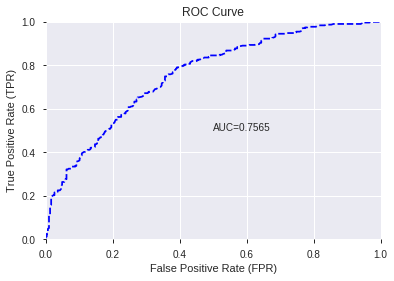

This function is available for GLM models only


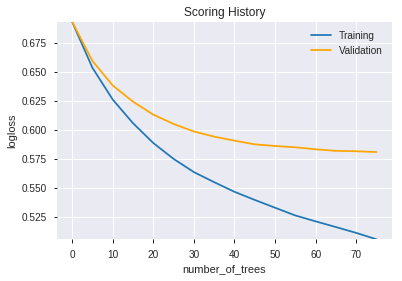

--2019-08-24 18:12:24--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.107.148
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.107.148|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_3_AutoML_20190824_181148',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_3_AutoML_20190824_181148',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_9a5d',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_66_sid_9a5d',
   'type

['BOP',
 'STOCHF_fastk',
 'STOCHRSI_fastk',
 'DIV',
 'CCI_8',
 'hour',
 'CDLCLOSINGMARUBOZU',
 'ULTOSC',
 'SUB',
 'Volume',
 'TRANGE',
 'AD',
 'SAREXT',
 'CDLHAMMER',
 'day',
 'aroonup_20',
 'CORREL_30',
 'CORREL_24',
 'CDLSHORTLINE',
 'aroondown_24',
 'aroondown_30',
 'HT_DCPERIOD',
 'aroonup_8',
 'CDLTAKURI',
 'aroondown_12',
 'aroonup_14',
 'quarter',
 'CDLGRAVESTONEDOJI',
 'aroondown_8',
 'aroonup_12',
 'HT_TRENDMODE',
 'is_month_end']

In [22]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [24]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [25]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [26]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [28]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [29]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [30]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [32]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [33]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [34]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [36]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [37]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [38]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [40]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [41]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [42]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [44]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [45]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [46]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [47]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [ 12 899 935] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:721: RuntimeWarning: invalid value encountered in less
  return (self.pvalues_ < self.alpha / len(self.pvalues_))


72

['BOP',
 'CCI_8',
 'CMO_8',
 'MINUS_DM_8',
 'MOM_8',
 'ROC_8',
 'ROCP_8',
 'ROCR_8',
 'ROCR100_8',
 'RSI_8',
 'WILLR_8',
 'CCI_12',
 'CMO_12',
 'MINUS_DM_12',
 'MOM_12',
 'ROC_12',
 'ROCP_12',
 'ROCR_12',
 'ROCR100_12',
 'RSI_12',
 'WILLR_12',
 'CCI_14',
 'CMO_14',
 'MOM_14',
 'ROC_14',
 'ROCP_14',
 'ROCR_14',
 'ROCR100_14',
 'RSI_14',
 'WILLR_14',
 'CCI_20',
 'CMO_20',
 'MOM_20',
 'ROC_20',
 'ROCP_20',
 'ROCR_20',
 'ROCR100_20',
 'RSI_20',
 'WILLR_20',
 'CCI_24',
 'CMO_24',
 'RSI_24',
 'WILLR_24',
 'CCI_30',
 'CMO_30',
 'RSI_30',
 'WILLR_30',
 'STOCH_slowk',
 'STOCHF_fastk',
 'STOCHF_fastd',
 'STOCHRSI_fastk',
 'STOCHRSI_fastd',
 'ULTOSC',
 'ADOSC',
 'ATR_8',
 'NATR_8',
 'ATR_12',
 'NATR_12',
 'NATR_14',
 'TRANGE',
 'CDLBELTHOLD',
 'CDLCLOSINGMARUBOZU',
 'CDLDRAGONFLYDOJI',
 'CDLENGULFING',
 'CDLHAMMER',
 'CDLHANGINGMAN',
 'CDLLONGLINE',
 'CDLMARUBOZU',
 'CDLSHORTLINE',
 'CDLTAKURI',
 'DIV',
 'SUB']

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190824_181323_model_4  0.748618  0.620122              0.345381  0.457673  0.209465
1  DeepLearning_grid_1_AutoML_20190824_181323_model_3  0.748382  0.655107              0.312517  0.460197  0.211781
2  DeepLearning_grid_1_AutoML_20190824_181323_model_2  0.740348  0.626778              0.322058  0.461152  0.212661
3  DeepLearning_grid_1_AutoML_20190824_181323_model_8  0.737848  0.611637              0.353393  0.458089  0.209846
4  DeepLearning_grid_1_AutoML_20190824_181323_model_9  0.737606  0.602168              0.326960  0.455815  0.207767
5  DeepLearning_grid_1_AutoML_20190824_181323_model_5  0.732830  0.634112              0.336738  0.461954  0.213401
6  DeepLearning_grid_1_AutoML_20190824_181323_model_6  0.727686  0.616002              0.338424  0.461071  0.212586
7               DeepLearning_1_AutoML_20190824_181323  0.726026  0.625634              0.343615  0.462960  0.214332
8  DeepLearning_grid_1_AutoML_20190824_181323_model_1  0.721103  0.802781              0.374950  0.493781  0.243819
9  DeepLearning_grid_1_AutoML_20190824_181323_model_7  0.717509  0.678732              0.380246  0.474085  0.224757

variable  relative_importance  scaled_importance  percentage
0   CDLCLOSINGMARUBOZU             1.000000           1.000000    0.023850
1          CDLMARUBOZU             0.876915           0.876915    0.020915
2            CDLHAMMER             0.876403           0.876403    0.020903
3            CDLTAKURI             0.873899           0.873899    0.020843
4     CDLDRAGONFLYDOJI             0.870346           0.870346    0.020758
..                 ...                  ...                ...         ...
67              RSI_24             0.513939           0.513939    0.012258
68      STOCHRSI_fastd             0.511395           0.511395    0.012197
69              CMO_24             0.511389           0.511389    0.012197
70         CDLBELTHOLD             0.495526           0.495526    0.011818
71        CDLENGULFING             0.488715           0.488715    0.011656

[72 rows x 4 columns]

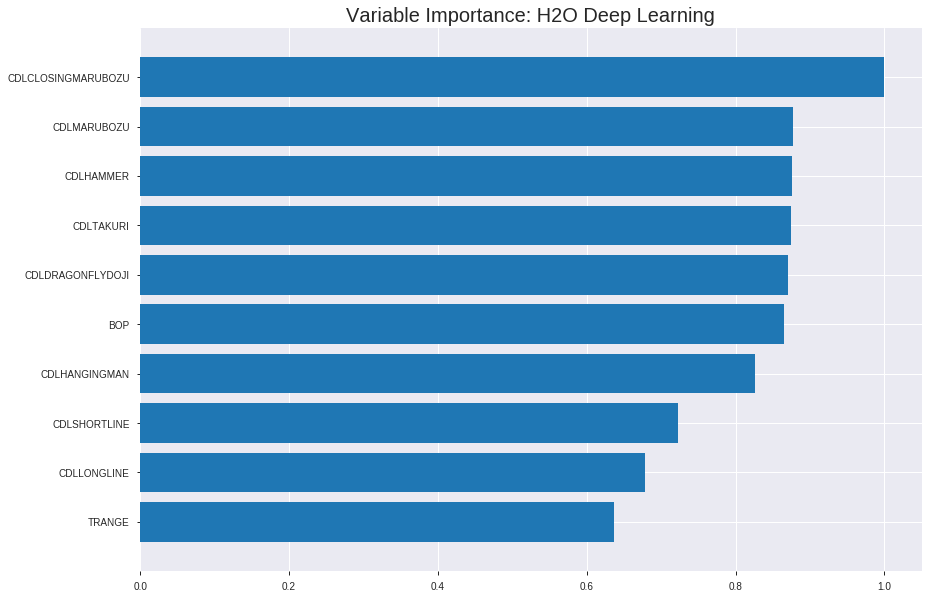

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190824_181323_model_4


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.19059102736985709
RMSE: 0.4365673228379067
LogLoss: 0.5674929259120045
Mean Per-Class Error: 0.27814856071325655
AUC: 0.7869000821466512
pr_auc: 0.7763834596497631
Gini: 0.5738001642933024
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37119530262311345: 


0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      1262  911   0.4192   (911.0/2173.0)
1      354   1786  0.1654   (354.0/2140.0)
Total  1616  2697  0.2933   (1265.0/4313.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.371195     0.738474  247
max f2                       0.136895     0.839867  349
max f0point5                 0.628881     0.722247  146
max accuracy                 0.455956     0.72154   210
max precision                0.998316     1         0
max recall                   0.010995     1         397
max specificity              0.998316     1         0
max absolute_mcc             0.455956     0.445051  210
max min_per_class_accuracy   0.504676     0.718362  192
max mean_per_class_accuracy  0.455956     0.721851  210

Gains/Lift Table: Avg response rate: 49.62 %, avg score: 51.32 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102017                   0.992418           2.01542   2.01542            1                0.995499   1                           0.995499            0.0205607       0.0205607                  101.542   101.542
    2        0.0201716                   0.980055           1.92168   1.96909            0.953488         0.986601   0.977011                    0.991101            0.0191589       0.0397196                  92.168    96.9089
    3        0.0301414                   0.971317           1.96855   1.96891            0.976744         0.975905   0.976923                    0.986075            0.0196262       0.0593458                  96.855    96.8911
    4        0.0401113                   0.960979           1.96855   1.96882            0.976744         0.966175   0.976879                    0.981129            0.0196262       0.078972                   96.855    96.8821
    5        0.0500812                   0.950824           1.7342    1.92211            0.860465         0.956198   0.953704                    0.976166            0.0172897       0.0962617                  73.4199   92.2114
    6        0.100162                    0.911082           1.69818   1.81015            0.842593         0.930812   0.898148                    0.953489            0.0850467       0.181308                   69.8178   81.0146
    7        0.150012                    0.871316           1.55609   1.72572            0.772093         0.891306   0.85626                     0.932825            0.0775701       0.258879                   55.6092   72.5723
    8        0.200093                    0.832393           1.58621   1.6908             0.787037         0.850817   0.838934                    0.9123              0.0794393       0.338318                   58.6211   69.0805
    9        0.300023                    0.735739           1.37479   1.58555            0.682135         0.784166   0.786708                    0.869621            0.137383        0.475701                   37.4788   58.5547
    10       0.399954                    0.621448           1.33738   1.52354            0.663573         0.678009   0.755942                    0.821746            0.133645        0.609346                   33.7379   52.3541
    11       0.500116                    0.502515           1.11501   1.44172            0.553241         0.556749   0.715345                    0.768673            0.111682        0.721028                   11.5013   44.1722
    12       0.600046                    0.394175           0.916525  1.35426            0.454756         0.443991   0.671947                    0.714601            0.0915888       0.812617                   -8.34746  35.4257
    13       0.699977                    0.304731           0.701422  1.26106            0.348028         0.347271   0.625704                    0.66216             0.0700935       0.88271                    -29.8578  26.1056
    14       0.799907                    0.221725           0.589195  1.17712            0.292343         0.26358    0.584058                    0.612367            0.0588785       0.941589                   -41.0805  17.7122
    15       0.899838                    0.118311           0.32733   1.08275            0.162413         0.170105   0.537233                    0.563252            0.0327103       0.974299                   -67.267   8.27498
    16       1                           0.00215827         0.256593  1                  0.127315         0.0636674  0.496174                   



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.21230707884882064
RMSE: 0.46076792298164665
LogLoss: 0.6246581060078616
Mean Per-Class Error: 0.3174889310562935
AUC: 0.7413306451612903
pr_auc: 0.7289920238403181
Gini: 0.48266129032258065
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.29127222365373046: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      268  352  0.5677   (352.0/620.0)
1      77   535  0.1258   (77.0/612.0)
Total  345  887  0.3482   (429.0/1232.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.291272     0.713809  288
max f2                       0.042051     0.836314  384
max f0point5                 0.651602     0.683594  137
max accuracy                 0.382953     0.681818  249
max precision                0.9993       1         0
max recall                   0.0229914    1         392
max specificity              0.9993       1         0
max absolute_mcc             0.381423     0.373425  250
max min_per_class_accuracy   0.481147     0.666667  204
max mean_per_class_accuracy  0.381423     0.682511  250

Gains/Lift Table: Avg response rate: 49.68 %, avg score: 49.86 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0105519                   0.993918           2.01307   2.01307            1                0.996445   1                           0.996445            0.0212418       0.0212418                  101.307    101.307
    2        0.0202922                   0.984761           1.67756   1.85203            0.833333         0.989915   0.92                        0.993311            0.0163399       0.0375817                  67.756     85.2026
    3        0.0300325                   0.965317           1.84532   1.84985            0.916667         0.979652   0.918919                    0.988881            0.0179739       0.0555556                  84.5316    84.985
    4        0.0405844                   0.952935           1.70337   1.81176            0.846154         0.959232   0.9                         0.981172            0.0179739       0.0735294                  70.3369    81.1765
    5        0.0503247                   0.940603           2.01307   1.85073            1                0.947672   0.919355                    0.974688            0.0196078       0.0931373                  101.307    85.0727
    6        0.100649                    0.892032           1.52604   1.68838            0.758065         0.914313   0.83871                     0.944501            0.0767974       0.169935                   52.6038    68.8383
    7        0.150162                    0.847509           1.48505   1.62134            0.737705         0.870123   0.805405                    0.919976            0.0735294       0.243464                   48.5053    62.1339
    8        0.200487                    0.80951            1.49357   1.58927            0.741935         0.825252   0.789474                    0.896199            0.0751634       0.318627                   49.3569    58.9267
    9        0.300325                    0.705717           1.39115   1.52341            0.691057         0.762447   0.756757                    0.851736            0.138889        0.457516                   39.1147    52.3406
    10       0.400162                    0.587442           1.11292   1.42099            0.552846         0.645566   0.705882                    0.800298            0.111111        0.568627                   11.2918    42.0992
    11       0.5                         0.472049           0.998353  1.3366             0.495935         0.527508   0.663961                    0.745828            0.0996732       0.668301                   -0.164727  33.6601
    12       0.599838                    0.386742           1.12928   1.3021             0.560976         0.426273   0.64682                     0.692641            0.112745        0.781046                   12.9284    30.2095
    13       0.699675                    0.305561           0.68739   1.21438            0.341463         0.346885   0.603248                    0.643305            0.0686275       0.849673                   -31.261    21.4382
    14       0.799513                    0.213676           0.720123  1.15266            0.357724         0.26526    0.572589                    0.596097            0.0718954       0.921569                   -27.9877   15.2662
    15       0.899351                    0.112641           0.441894  1.07376            0.219512         0.162935   0.533394                    0.548012            0.0441176       0.965686                   -55.8106   7.37595
    16       1                           0.00476673         0.340923  1                  0.169355         0.0567989  0.496753   


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 18:16:45  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-24 18:16:52  8.292 sec         355 obs/sec       0.546256  1             2356       0.598609         1.99185             -0.433415      0.691762        0.671542           1.69479          0.401808                         0.622341           2.42802               -0.549298        0.669729          0.657334             1.70337            0.434253
    2019-08-24 18:17:11  27.542 sec        478 obs/sec       2.69186   5             11610      0.597869         1.45441             -0.429872      0.743634        0.735936           1.96962          0.362393                         0.617587           1.66354               -0.525717        0.717468          0.713125             2.01307            0.343344
    2019-08-24 18:17:28  44.250 sec        590 obs/sec       5.3777    10            23194      0.46436          0.682112            0.13743        0.753707        0.714442           1.69479          0.325064                         0.490203           0.744206              0.0387643        0.719452          0.694432             2.01307            0.375812
    2019-08-24 18:17:45  1 min  1.640 sec  722 obs/sec       9.22119   17            39771      0.457324         0.62028             0.16337        0.757189        0.747743           2.01542          0.338975                         0.486277           0.709607              0.0540996        0.715881          0.711836             1.85822            0.361201
    2019-08-24 18:18:02  1 min 18.350 sec  867 obs/sec       14.1029   26            60826      0.436567         0.567493            0.237591       0.7869          0.776383           2.01542          0.293299                         0.460768           0.624658              0.150736         0.741331          0.728992             2.01307            0.348214
    2019-08-24 18:18:19  1 min 35.680 sec  983 obs/sec       19.5548   36            84340      0.428038         0.545781            0.267091       0.800499        0.792208           2.01542          0.285648                         0.465047           0.635148              0.13489          0.729736          0.721078             1.85822            0.354708
    2019-08-24 18:18:36  1 min 52.951 sec  1064 obs/sec      25.0301   46            107955     0.418832         0.523099            0.298278       0.815639        0.807331           2.01542          0.287271                         0.467977           0.640801              0.123953         0.724283          0.709411             1.85822            0.387987
    2019-08-24 18:18:54  2 min 10.212 sec  1122 obs/sec      30.4493   56            131328     0.408898         0.503263            0.331171       0.834929        0.824423           2.01542          0.258057                         0.467986           0.644068              0.12392          0.727216          0.713978             1.85822            0.346591
    2019-08-24 18:19:11

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
CDLCLOSINGMARUBOZU  1.0                    1.0                  0.023850402952537524
CDLMARUBOZU         0.8769152164459229     0.8769152164459229   0.020914781267446923
CDLHAMMER           0.8764025568962097     0.8764025568962097   0.0209025541306088
CDLTAKURI           0.8738994598388672     0.8738994598388672   0.020842854257161866
CDLDRAGONFLYDOJI    0.8703455924987793     0.8703455924987793   0.02075809308906091
---                 ---                    ---                  ---
RSI_24              0.513939380645752      0.513939380645752    0.01225766132157875
STOCHRSI_fastd      0.5113945007324219     0.5113945007324219   0.012196964910180009
CMO_24              0.5113893151283264     0.5113893151283264   0.012196841231432779
CDLBELTHOLD         0.49552616477012634    0.49552616477012634  0.011818498703293018
CDLENGULFING        0.48871496319770813    0.48871496319770813  0.011656048801199886


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6920583468395461)

('F1', 0.7195767195767195)

('auc', 0.7486182039804131)

('logloss', 0.6201217556776336)

('mean_per_class_error', 0.30769917827795634)

('rmse', 0.4576730717001239)

('mse', 0.20946464055942673)

deeplearning prediction progress: |███████████████████████████████████████| 100%


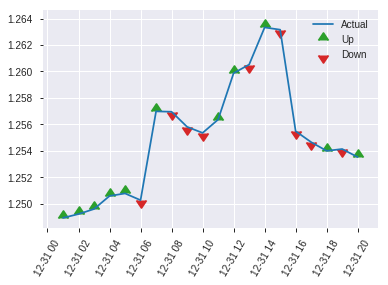


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.20946464055942673
RMSE: 0.4576730717001239
LogLoss: 0.6201217556776336
Mean Per-Class Error: 0.30769917827795634
AUC: 0.7486182039804131
pr_auc: 0.7343676767517137
Gini: 0.49723640796082624
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.27308208377274423: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      133  173  0.5654   (173.0/306.0)
1      39   272  0.1254   (39.0/311.0)
Total  172  445  0.3436   (212.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.273082     0.719577  295
max f2                       0.0545477    0.849835  373
max f0point5                 0.537372     0.701374  183
max accuracy                 0.495788     0.692058  200
max precision                0.998323     1         0
max recall                   0.0229515    1         391
max specificity              0.998323     1         0
max absolute_mcc             0.537372     0.385286  183
max min_per_class_accuracy   0.462212     0.679739  211
max mean_per_class_accuracy  0.495788     0.692301  200

Gains/Lift Table: Avg response rate: 50.41 %, avg score: 48.67 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.993753           1.70051   1.70051            0.857143         0.995561  0.857143                    0.995561            0.0192926       0.0192926                  70.0505   70.0505
    2        0.0210697                   0.989704           1.65327   1.6787             0.833333         0.991074  0.846154                    0.99349             0.0160772       0.0353698                  65.3269   67.8704
    3        0.0307942                   0.977621           1.65327   1.67067            0.833333         0.98387   0.842105                    0.990452            0.0160772       0.0514469                  65.3269   67.0672
    4        0.0405186                   0.960185           1.98392   1.74585            1                0.969091  0.88                        0.985326            0.0192926       0.0707395                  98.3923   74.5852
    5        0.0502431                   0.938322           1.98392   1.79193            1                0.949608  0.903226                    0.978413            0.0192926       0.0900322                  98.3923   79.193
    6        0.100486                    0.891126           1.53594   1.66394            0.774194         0.913529  0.83871                     0.945971            0.0771704       0.167203                   53.594    66.3935
    7        0.150729                    0.851112           1.72793   1.68527            0.870968         0.866738  0.849462                    0.91956             0.0868167       0.254019                   72.7933   68.5268
    8        0.200972                    0.801283           1.15196   1.55194            0.580645         0.820743  0.782258                    0.894856            0.0578778       0.311897                   15.1955   55.194
    9        0.299838                    0.69363            1.43103   1.51207            0.721311         0.745868  0.762162                    0.84573             0.141479        0.453376                   43.1026   51.2071
    10       0.400324                    0.568657           1.24795   1.44577            0.629032         0.633446  0.728745                    0.792444            0.125402        0.578778                   24.7951   44.5774
    11       0.50081                     0.462462           1.02396   1.36114            0.516129         0.515582  0.686084                    0.736892            0.102894        0.681672                   2.39602   36.1138
    12       0.599676                    0.379234           0.87813   1.28151            0.442623         0.420816  0.645946                    0.684783            0.0868167       0.768489                   -12.187   28.1507
    13       0.700162                    0.285128           0.831968  1.21699            0.419355         0.336368  0.613426                    0.634779            0.0836013       0.85209                    -16.8032  21.699
    14       0.799028                    0.196253           0.617943  1.14287            0.311475         0.241495  0.576065                    0.586117            0.0610932       0.913183                   -38.2057  14.2868
    15       0.899514                    0.084199           0.607976  1.08311            0.306452         0.140856  0.545946                    0.536376            0.0610932       0.974277                   -39.2024  8.31146
    16       1                           0.000648133        0.25599   1                  0.129032         0.041824  0.504052                    0.48668             

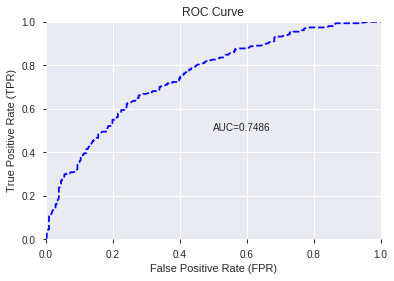

This function is available for GLM models only


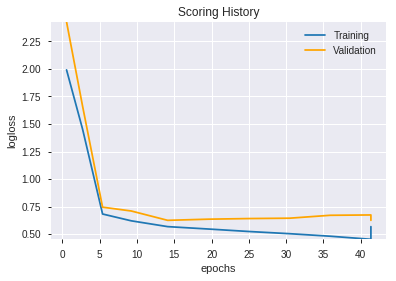

--2019-08-24 18:36:45--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.96.59
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.96.59|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190824_181323_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190824_181323_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_9a5d',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLCLOSINGMARUBOZU',
 'CDLMARUBOZU',
 'CDLHAMMER',
 'CDLTAKURI',
 'CDLDRAGONFLYDOJI',
 'BOP',
 'CDLHANGINGMAN',
 'CDLSHORTLINE',
 'CDLLONGLINE',
 'TRANGE',
 'SUB',
 'STOCHF_fastk',
 'DIV',
 'ULTOSC',
 'MINUS_DM_12',
 'WILLR_12',
 'WILLR_8',
 'CCI_12',
 'ROCR100_20',
 'RSI_14',
 'CCI_8',
 'ROCP_14',
 'CCI_30',
 'WILLR_24',
 'RSI_12',
 'ADOSC',
 'MINUS_DM_8',
 'STOCH_slowk',
 'ROCR_14',
 'MOM_12',
 'NATR_12',
 'STOCHF_fastd',
 'NATR_8',
 'ROCP_8',
 'MOM_8',
 'ROCR100_12',
 'ROCR100_8',
 'WILLR_30',
 'CCI_14',
 'CCI_24',
 'CMO_8',
 'WILLR_14',
 'WILLR_20',
 'ROC_14',
 'RSI_8',
 'CMO_12',
 'ROCR_8',
 'CCI_20',
 'ROCR_20',
 'ROC_20',
 'STOCHRSI_fastk',
 'CMO_14',
 'ROCR100_14',
 'MOM_20',
 'ATR_12',
 'ROC_12',
 'ATR_8',
 'MOM_14',
 'ROCR_12',
 'ROCP_20',
 'ROCP_12',
 'CMO_30',
 'RSI_20',
 'CMO_20',
 'RSI_30',
 'ROC_8',
 'NATR_14',
 'RSI_24',
 'STOCHRSI_fastd',
 'CMO_24',
 'CDLBELTHOLD',
 'CDLENGULFING']

In [48]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190824_183742_model_1  0.742224  0.597051              0.333706  0.453783  0.205919

variable  relative_importance  scaled_importance  percentage
0                  BOP             0.482892           1.000000    0.135880
1         STOCHF_fastk             0.180871           0.374557    0.050895
2   CDLCLOSINGMARUBOZU             0.166950           0.345730    0.046978
3                CCI_8             0.137028           0.283765    0.038558
4         STOCHF_fastd             0.128893           0.266918    0.036269
..                 ...                  ...                ...         ...
67              RSI_24             0.003127           0.006475    0.000880
68              CMO_24             0.002968           0.006147    0.000835
69      STOCHRSI_fastd             0.002529           0.005236    0.000712
70              CMO_20             0.000865           0.001792    0.000243
71              RSI_20             0.000401           0.000831    0.000113

[72 rows x 4 columns]

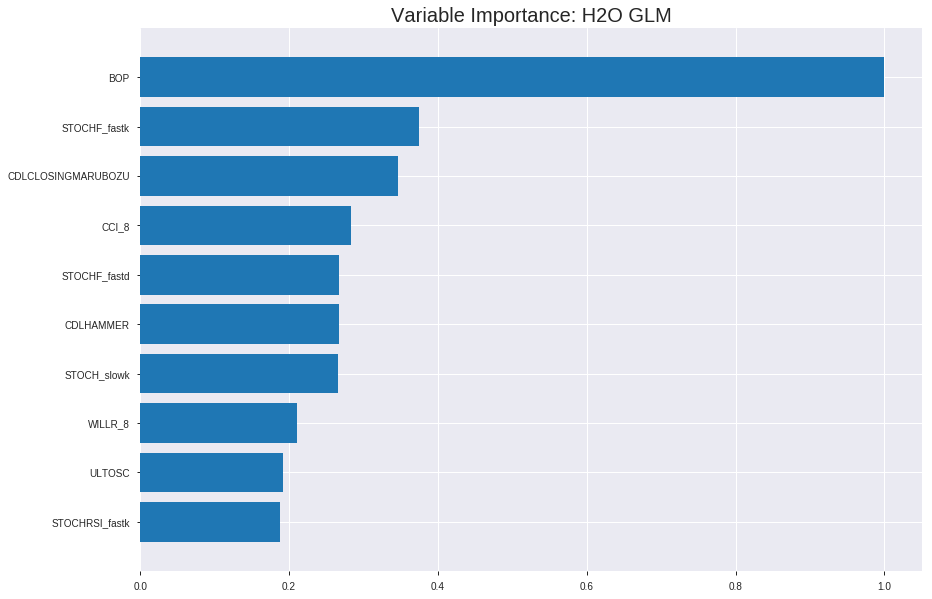

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190824_183742_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.2003342076413569
RMSE: 0.4475870950344267
LogLoss: 0.5864679441741215
Null degrees of freedom: 4312
Residual degrees of freedom: 4240
Null deviance: 5978.835084581811
Residual deviance: 5058.872486445973
AIC: 5204.872486445973
AUC: 0.7591315034557505
pr_auc: 0.7465148895313409
Gini: 0.5182630069115011
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3810886540788129: 


0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      1033  1140  0.5246   (1140.0/2173.0)
1      306   1834  0.143    (306.0/2140.0)
Total  1339  2974  0.3353   (1446.0/4313.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.381089     0.717247  257
max f2                       0.245523     0.835971  325
max f0point5                 0.577632     0.696685  151
max accuracy                 0.507798     0.695803  188
max precision                0.920419     1         0
max recall                   0.0665525    1         394
max specificity              0.920419     1         0
max absolute_mcc             0.507798     0.391656  188
max min_per_class_accuracy   0.509811     0.694393  187
max mean_per_class_accuracy  0.507798     0.695832  188

Gains/Lift Table: Avg response rate: 49.62 %, avg score: 49.62 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102017                   0.870141           1.92381   1.92381            0.954545         0.886736  0.954545                    0.886736            0.0196262       0.0196262                  92.3811   92.3811
    2        0.0201716                   0.854709           1.82794   1.87643            0.906977         0.861819  0.931034                    0.874421            0.0182243       0.0378505                  82.794    87.6426
    3        0.0301414                   0.836137           1.78107   1.84488            0.883721         0.8453    0.915385                    0.864789            0.017757        0.0556075                  78.1069   84.4885
    4        0.0401113                   0.816471           1.7342    1.81737            0.860465         0.825     0.901734                    0.854899            0.0172897       0.0728972                  73.4199   81.7373
    5        0.0500812                   0.803697           1.68733   1.79148            0.837209         0.809394  0.888889                    0.84584             0.0168224       0.0897196                  68.7329   79.1485
    6        0.100162                    0.752683           1.68885   1.74017            0.837963         0.773487  0.863426                    0.809663            0.0845794       0.174299                   68.8848   74.0166
    7        0.150012                    0.723575           1.46235   1.64785            0.725581         0.737123  0.81762                     0.785558            0.0728972       0.247196                   46.2352   64.7848
    8        0.200093                    0.691724           1.45558   1.59973            0.722222         0.706543  0.793743                    0.765781            0.0728972       0.320093                   45.5582   59.9725
    9        0.300023                    0.633211           1.42155   1.54038            0.705336         0.661899  0.764297                    0.731181            0.142056        0.46215                    42.155    54.0379
    10       0.399954                    0.571708           1.26724   1.47213            0.62877          0.602761  0.730435                    0.699094            0.126636        0.588785                   26.7237   47.2133
    11       0.500116                    0.507818           1.08236   1.39407            0.537037         0.539007  0.691701                    0.667032            0.108411        0.697196                   8.23555   39.4069
    12       0.600046                    0.439002           0.925878  1.3161             0.459397         0.472493  0.653014                    0.634634            0.0925234       0.78972                    -7.41223  31.6098
    13       0.699977                    0.371792           0.738832  1.23369            0.366589         0.405027  0.612123                    0.601855            0.0738318       0.863551                   -26.1168  23.3686
    14       0.799907                    0.302437           0.69207   1.16602            0.343387         0.337721  0.578551                    0.568857            0.0691589       0.93271                    -30.793   16.6023
    15       0.899838                    0.210943           0.369416  1.07756            0.183295         0.263361  0.534656                    0.534931            0.0369159       0.969626                   -63.0584  7.75567
    16       1                           0.0401844          0.303246  1                  0.150463         0.147995  0.496174                    0.496174         



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.20678037167041363
RMSE: 0.45473109820025903
LogLoss: 0.6003750855925166
Null degrees of freedom: 1231
Residual degrees of freedom: 1159
Null deviance: 1707.8643560108549
Residual deviance: 1479.324210899961
AIC: 1625.324210899961
AUC: 0.7398495150748472
pr_auc: 0.7186250573219962
Gini: 0.4796990301496944
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4270456634908376: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      350  270  0.4355   (270.0/620.0)
1      125  487  0.2042   (125.0/612.0)
Total  475  757  0.3206   (395.0/1232.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.427046     0.711468  230
max f2                       0.150258     0.837696  374
max f0point5                 0.502214     0.685271  187
max accuracy                 0.502214     0.686688  187
max precision                0.909865     1         0
max recall                   0.110314     1         388
max specificity              0.909865     1         0
max absolute_mcc             0.486        0.373734  197
max min_per_class_accuracy   0.496677     0.683871  190
max mean_per_class_accuracy  0.486        0.686791  197

Gains/Lift Table: Avg response rate: 49.68 %, avg score: 49.05 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105519                   0.877167           1.85822   1.85822            0.923077         0.893182  0.923077                    0.893182            0.0196078       0.0196078                  85.822    85.822
    2        0.0202922                   0.857538           1.84532   1.85203            0.916667         0.866021  0.92                        0.880145            0.0179739       0.0375817                  84.5316   85.2026
    3        0.0300325                   0.839371           1.67756   1.79544            0.833333         0.850005  0.891892                    0.87037             0.0163399       0.0539216                  67.756    79.5443
    4        0.0405844                   0.824799           1.70337   1.7715             0.846154         0.833243  0.88                        0.860717            0.0179739       0.0718954                  70.3369   77.1503
    5        0.0503247                   0.801459           1.67756   1.75332            0.833333         0.811976  0.870968                    0.851283            0.0163399       0.0882353                  67.756    75.3321
    6        0.100649                    0.74983            1.49357   1.62345            0.741935         0.770875  0.806452                    0.811079            0.0751634       0.163399                   49.3569   62.3445
    7        0.150162                    0.711173           1.41905   1.55605            0.704918         0.728482  0.772973                    0.783844            0.0702614       0.23366                    41.9051   55.605
    8        0.200487                    0.674867           1.39616   1.51592            0.693548         0.690973  0.753036                    0.760532            0.0702614       0.303922                   39.6163   51.5916
    9        0.300325                    0.625231           1.45661   1.4962             0.723577         0.649719  0.743243                    0.723694            0.145425        0.449346                   45.6613   49.6202
    10       0.400162                    0.552707           1.22748   1.42916            0.609756         0.590189  0.709939                    0.690386            0.122549        0.571895                   22.7483   42.9159
    11       0.5                         0.495362           1.12928   1.36928            0.560976         0.524674  0.680195                    0.657297            0.112745        0.684641                   12.9284   36.9281
    12       0.599838                    0.433607           0.96562   1.3021             0.479675         0.46291   0.64682                     0.624943            0.0964052       0.781046                   -3.43801  30.2095
    13       0.699675                    0.36746            0.703757  1.21672            0.349593         0.402121  0.604408                    0.593148            0.0702614       0.851307                   -29.6243  21.6717
    14       0.799513                    0.303493           0.621925  1.14244            0.308943         0.336586  0.567513                    0.561111            0.0620915       0.913399                   -37.8075  14.2444
    15       0.899351                    0.214588           0.572825  1.07921            0.284553         0.263593  0.536101                    0.528083            0.0571895       0.970588                   -42.7175  7.921
    16       1                           0.045177           0.29222   1                  0.145161         0.154377  0.496753                    0.49047             0


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-24 18:37:42  0.000 sec   2            20        73            1.36518           1.36305
    2019-08-24 18:37:42  0.026 sec   4            12        73            1.35639           1.35375
    2019-08-24 18:37:42  0.053 sec   6            7.6       73            1.34497           1.3419
    2019-08-24 18:37:42  0.079 sec   8            4.7       73            1.33045           1.32708
    2019-08-24 18:37:42  0.105 sec   10           2.9       73            1.31261           1.3092
    2019-08-24 18:37:42  0.130 sec   12           1.8       73            1.29184           1.28883
    2019-08-24 18:37:42  0.154 sec   14           1.1       73            1.26941           1.26757
    2019-08-24 18:37:43  0.179 sec   16           0.7       73            1.24722           1.24754
    2019-08-24 18:37:43  0.203 sec   18           0.44      73            1.22699           1.23049
    2019-08-24 18:37:43  0.228 sec   20           0.27      73            1.20996           1.21754
    2019-08-24 18:37:43  0.256 sec   22           0.17      73            1.19646           1.20879
    2019-08-24 18:37:43  0.281 sec   24           0.1       73            1.1862            1.20373
    2019-08-24 18:37:43  0.305 sec   26           0.065     73            1.17858           1.20134
    2019-08-24 18:37:43  0.340 sec   28           0.04      73            1.17294           1.20075
    2019-08-24 18:37:43  0.365 sec   30           0.025     73            1.16877           1.20127
    2019-08-24 18:37:43  0.392 sec   32           0.016     73            1.16567           1.20242
    2019-08-24 18:37:43  0.418 sec   34           0.0096    73            1.16335           1.20391
    2019-08-24 18:37:43  0.470 sec   36           0.006     73            1.16159           1.20555
    2019-08-24 18:37:43  0.507 sec   38           0.0037    73            1.16031           1.20707

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6790923824959482)

('F1', 0.7195622435020519)

('auc', 0.7422241136540361)

('logloss', 0.5970509827132324)

('mean_per_class_error', 0.3203244856356262)

('rmse', 0.4537828915077631)

('mse', 0.20591891262514625)

glm prediction progress: |████████████████████████████████████████████████| 100%


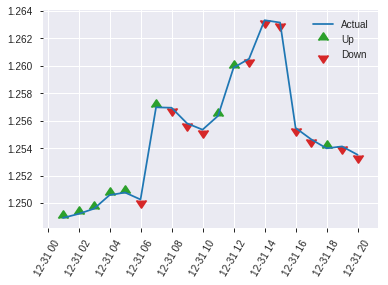


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.20591891262514625
RMSE: 0.4537828915077631
LogLoss: 0.5970509827132324
Null degrees of freedom: 616
Residual degrees of freedom: 544
Null deviance: 855.4562567606156
Residual deviance: 736.7609126681288
AIC: 882.7609126681288
AUC: 0.7422241136540361
pr_auc: 0.7351377523802437
Gini: 0.48444822730807213
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.35763122191286933: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      149  157  0.5131   (157.0/306.0)
1      48   263  0.1543   (48.0/311.0)
Total  197  420  0.3323   (205.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.357631     0.719562  259
max f2                       0.170085     0.847598  354
max f0point5                 0.556692     0.692368  149
max accuracy                 0.528874     0.679092  163
max precision                0.900583     1         0
max recall                   0.0900649    1         390
max specificity              0.900583     1         0
max absolute_mcc             0.556692     0.365888  149
max min_per_class_accuracy   0.482541     0.675241  190
max mean_per_class_accuracy  0.528874     0.679676  163

Gains/Lift Table: Avg response rate: 50.41 %, avg score: 47.51 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.862977           1.98392   1.98392            1                0.87883   1                           0.87883             0.022508        0.022508                   98.3923   98.3923
    2        0.0210697                   0.834381           1.65327   1.83131            0.833333         0.85537   0.923077                    0.868002            0.0160772       0.0385852                  65.3269   83.1313
    3        0.0307942                   0.821036           1.98392   1.87951            1                0.825002  0.947368                    0.854423            0.0192926       0.0578778                  98.3923   87.9506
    4        0.0405186                   0.80316            1.98392   1.90457            1                0.815827  0.96                        0.84516             0.0192926       0.0771704                  98.3923   90.4566
    5        0.0502431                   0.78667            1.65327   1.85593            0.833333         0.795942  0.935484                    0.835634            0.0160772       0.0932476                  65.3269   85.5928
    6        0.100486                    0.743611           1.47194   1.66394            0.741935         0.767239  0.83871                     0.801437            0.073955        0.167203                   47.1943   66.3935
    7        0.150729                    0.706227           1.53594   1.62127            0.774194         0.72428   0.817204                    0.775718            0.0771704       0.244373                   53.594    62.127
    8        0.200972                    0.667757           1.40795   1.56794            0.709677         0.690071  0.790323                    0.754306            0.0707395       0.315113                   40.7945   56.7939
    9        0.299838                    0.607353           1.26841   1.46918            0.639344         0.633686  0.740541                    0.714534            0.125402        0.440514                   26.841    46.9175
    10       0.400324                    0.552738           1.31195   1.42971            0.66129          0.58007   0.720648                    0.680782            0.131833        0.572347                   31.1949   42.971
    11       0.50081                     0.482541           1.02396   1.3483             0.516129         0.515929  0.679612                    0.647705            0.102894        0.675241                   2.39602   34.8297
    12       0.599676                    0.413497           0.87813   1.27078            0.442623         0.443978  0.640541                    0.614117            0.0868167       0.762058                   -12.187   27.0783
    13       0.700162                    0.343939           0.927964  1.22158            0.467742         0.378482  0.615741                    0.580299            0.0932476       0.855305                   -7.20361  22.1582
    14       0.799028                    0.286355           0.68299   1.15494            0.344262         0.317883  0.58215                     0.54783             0.0675241       0.92283                    -31.701   15.4941
    15       0.899514                    0.19372            0.543979  1.08669            0.274194         0.244238  0.547748                    0.513915            0.0546624       0.977492                   -45.6021  8.66893
    16       1                           0.015762           0.223991  1                  0.112903         0.127612  0.504052                    0.475097           

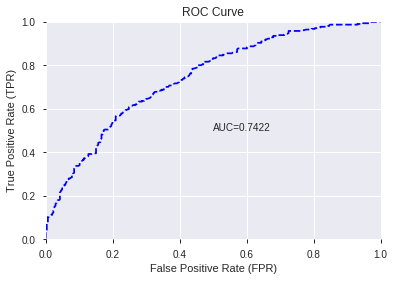

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


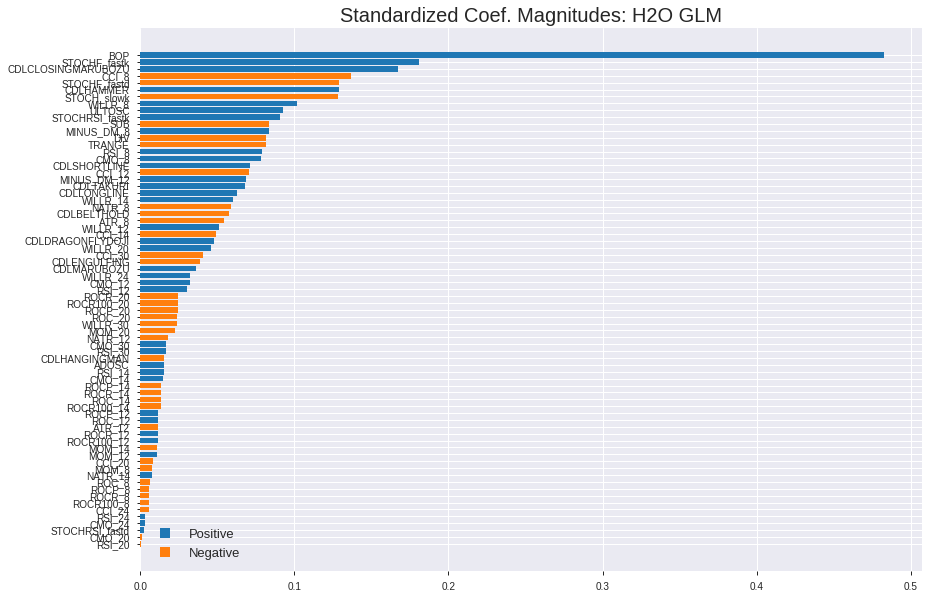

'log_likelihood'
--2019-08-24 18:37:53--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.81.152
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.81.152|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190824_183742_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190824_183742_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_9a5d',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['BOP',
 'STOCHF_fastk',
 'CDLCLOSINGMARUBOZU',
 'CCI_8',
 'STOCHF_fastd',
 'CDLHAMMER',
 'STOCH_slowk',
 'WILLR_8',
 'ULTOSC',
 'STOCHRSI_fastk',
 'SUB',
 'MINUS_DM_8',
 'DIV',
 'TRANGE',
 'RSI_8',
 'CMO_8',
 'CDLSHORTLINE',
 'CCI_12',
 'MINUS_DM_12',
 'CDLTAKURI',
 'CDLLONGLINE',
 'WILLR_14',
 'NATR_8',
 'CDLBELTHOLD',
 'ATR_8',
 'WILLR_12',
 'CCI_14',
 'CDLDRAGONFLYDOJI',
 'WILLR_20',
 'CCI_30',
 'CDLENGULFING',
 'CDLMARUBOZU',
 'WILLR_24',
 'CMO_12',
 'RSI_12',
 'ROCR_20',
 'ROCR100_20',
 'ROCP_20',
 'ROC_20',
 'WILLR_30',
 'MOM_20',
 'NATR_12',
 'CMO_30',
 'RSI_30',
 'CDLHANGINGMAN',
 'ADOSC',
 'RSI_14',
 'CMO_14',
 'ROCP_14',
 'ROCR_14',
 'ROC_14',
 'ROCR100_14',
 'ROCP_12',
 'ROC_12',
 'ATR_12',
 'ROCR_12',
 'ROCR100_12',
 'MOM_14',
 'MOM_12',
 'CCI_20',
 'MOM_8',
 'NATR_14',
 'ROC_8',
 'ROCP_8',
 'ROCR_8',
 'ROCR100_8',
 'CCI_24',
 'RSI_24',
 'CMO_24',
 'STOCHRSI_fastd',
 'CMO_20',
 'RSI_20']

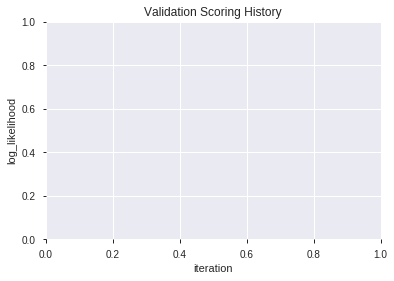

In [49]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190824_183850_model_6  0.746054  0.595778              0.340452  0.452828  0.205053
1               XGBoost_3_AutoML_20190824_183850  0.743369  0.598910              0.333995  0.453822  0.205954
2               XGBoost_2_AutoML_20190824_183850  0.742518  0.601633              0.345670  0.455437  0.207423
3  XGBoost_grid_1_AutoML_20190824_183850_model_5  0.742045  0.608249              0.368703  0.457085  0.208927
4               XGBoost_1_AutoML_20190824_183850  0.741168  0.599250              0.312281  0.454554  0.206619
5  XGBoost_grid_1_AutoML_20190824_183850_model_3  0.740506  0.600256              0.330596  0.454547  0.206613
6  XGBoost_grid_1_AutoML_20190824_183850_model_2  0.739382  0.601157              0.340479  0.455290  0.207289
7  XGBoost_grid_1_AutoML_20190824_183850_model_7  0.738730  0.604914              0.335656  0.456300  0.208209
8  XGBoost_grid_1_AutoML_20190824_183850_model_1  0.738489  0.605236              0.348780  0.455971  0.207909
9  XGBoost_grid_1_AutoML_20190824_183850_model_4  0.734711  0.605409              0.338687  0.457240  0.209069

variable  relative_importance  scaled_importance  percentage
0            BOP          4591.138672           1.000000    0.291727
1   STOCHF_fastk           818.678772           0.178317    0.052020
2          CCI_8           590.711182           0.128663    0.037535
3         TRANGE           485.869659           0.105828    0.030873
4          ADOSC           469.126099           0.102181    0.029809
..           ...                  ...                ...         ...
62        ROCR_8             8.545242           0.001861    0.000543
63       ROCR_14             7.501518           0.001634    0.000477
64       ROCR_20             6.999186           0.001524    0.000445
65        RSI_24             4.554783           0.000992    0.000289
66   CDLMARUBOZU             3.327716           0.000725    0.000211

[67 rows x 4 columns]

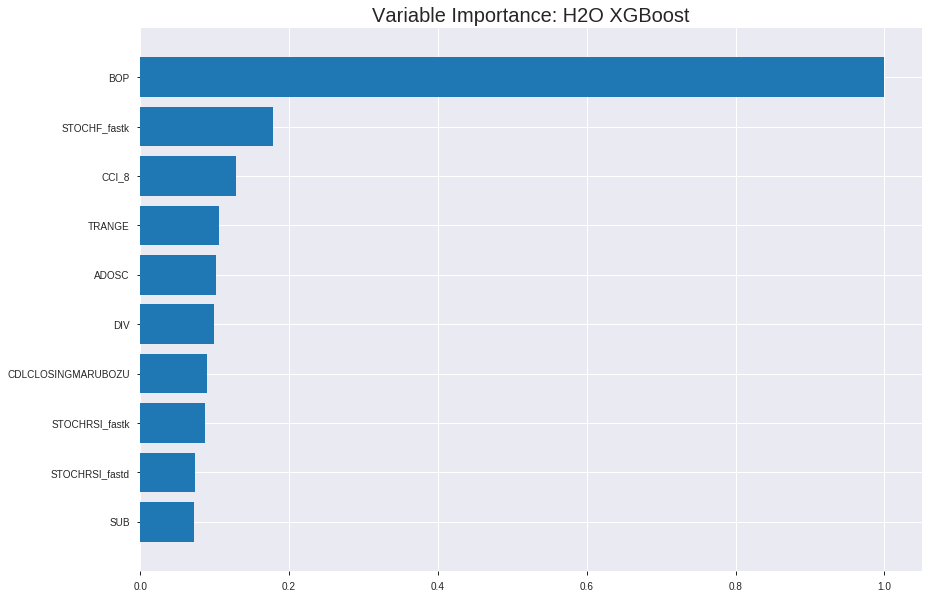

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190824_183850_model_6


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.1681467815281764
RMSE: 0.41005704667543075
LogLoss: 0.510655451013639
Mean Per-Class Error: 0.24234520087221678
AUC: 0.8462803910352629
pr_auc: 0.8483317613975419
Gini: 0.6925607820705257
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4194142089949714: 


0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      1339  834   0.3838   (834.0/2173.0)
1      280   1860  0.1308   (280.0/2140.0)
Total  1619  2694  0.2583   (1114.0/4313.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.419414     0.769549  245
max f2                       0.29372      0.86429   306
max f0point5                 0.603745     0.775714  150
max accuracy                 0.488249     0.757477  211
max precision                0.952915     1         0
max recall                   0.142508     1         375
max specificity              0.952915     1         0
max absolute_mcc             0.488249     0.515759  211
max min_per_class_accuracy   0.503696     0.755177  202
max mean_per_class_accuracy  0.488249     0.757655  211

Gains/Lift Table: Avg response rate: 49.62 %, avg score: 49.54 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102017                   0.93291            2.01542    2.01542            1                0.940795  1                           0.940795            0.0205607       0.0205607                  101.542   101.542
    2        0.0201716                   0.912598           2.01542    2.01542            1                0.922678  1                           0.93184             0.0200935       0.0406542                  101.542   101.542
    3        0.0301414                   0.885859           2.01542    2.01542            1                0.900161  1                           0.921362            0.0200935       0.0607477                  101.542   101.542
    4        0.0401113                   0.856645           2.01542    2.01542            1                0.87173   1                           0.909025            0.0200935       0.0808411                  101.542   101.542
    5        0.0500812                   0.836743           2.01542    2.01542            1                0.845961  1                           0.896471            0.0200935       0.100935                   101.542   101.542
    6        0.100162                    0.765039           1.93144    1.97343            0.958333         0.794801  0.979167                    0.845636            0.096729        0.197664                   93.1445   97.3433
    7        0.150012                    0.727033           1.79982    1.91574            0.893023         0.745595  0.950541                    0.812392            0.0897196       0.287383                   79.9817   91.574
    8        0.200093                    0.6971             1.64219    1.84727            0.814815         0.710762  0.91657                     0.786955            0.082243        0.369626                   64.2195   84.7274
    9        0.300023                    0.633116           1.5291     1.7413             0.758701         0.664816  0.863988                    0.746274            0.152804        0.52243                    52.9101   74.1298
    10       0.399954                    0.569208           1.29062    1.62869            0.640371         0.601042  0.808116                    0.709987            0.128972        0.651402                   29.0617   62.8693
    11       0.500116                    0.502334           1.0497     1.51273            0.520833         0.535445  0.75058                     0.67503             0.10514         0.756542                   4.96982   51.2733
    12       0.600046                    0.434522           0.893145   1.40955            0.443155         0.468109  0.699382                    0.64057             0.0892523       0.845794                   -10.6855  40.9548
    13       0.699977                    0.362481           0.729479   1.31246            0.361949         0.399746  0.651209                    0.606189            0.0728972       0.918692                   -27.0521  31.246
    14       0.799907                    0.278269           0.5097     1.21217            0.2529           0.322808  0.601449                    0.570787            0.0509346       0.969626                   -49.03    21.2173
    15       0.899838                    0.19457            0.247836   1.10508            0.12297          0.237834  0.548312                    0.533811            0.0247664       0.994393                   -75.2164  10.508
    16       1                           0.0730748          0.0559839  1                  0.0277778        0.15007   0.496174                    0.



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.20365749431569713
RMSE: 0.4512842721785207
LogLoss: 0.5920889087363209
Mean Per-Class Error: 0.31442125237191654
AUC: 0.747894265232975
pr_auc: 0.7407641725470959
Gini: 0.49578853046594995
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40391565561294557: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      343  277  0.4468   (277.0/620.0)
1      116  496  0.1895   (116.0/612.0)
Total  459  773  0.319    (393.0/1232.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.403916     0.716245  251
max f2                       0.185496     0.839151  360
max f0point5                 0.545614     0.688737  173
max accuracy                 0.450021     0.685065  225
max precision                0.958503     1         0
max recall                   0.102964     1         394
max specificity              0.958503     1         0
max absolute_mcc             0.408519     0.378065  249
max min_per_class_accuracy   0.487358     0.681373  205
max mean_per_class_accuracy  0.435419     0.685579  234

Gains/Lift Table: Avg response rate: 49.68 %, avg score: 48.22 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105519                   0.916465           2.01307   2.01307            1                0.933337  1                           0.933337            0.0212418       0.0212418                  101.307   101.307
    2        0.0202922                   0.901426           1.84532   1.93255            0.916667         0.908841  0.96                        0.921579            0.0179739       0.0392157                  84.5316   93.2549
    3        0.0300325                   0.879516           1.84532   1.90426            0.916667         0.892492  0.945946                    0.912145            0.0179739       0.0571895                  84.5316   90.4257
    4        0.0405844                   0.853489           1.54852   1.81176            0.769231         0.865727  0.9                         0.900077            0.0163399       0.0735294                  54.8517   81.1765
    5        0.0503247                   0.812824           2.01307   1.85073            1                0.831466  0.919355                    0.886797            0.0196078       0.0931373                  101.307   85.0727
    6        0.100649                    0.747937           1.65591   1.75332            0.822581         0.774652  0.870968                    0.830725            0.0833333       0.176471                   65.5914   75.3321
    7        0.150162                    0.704891           1.55106   1.68663            0.770492         0.726377  0.837838                    0.796318            0.0767974       0.253268                   55.1055   68.6628
    8        0.200487                    0.672995           1.36369   1.60557            0.677419         0.688217  0.797571                    0.769184            0.0686275       0.321895                   36.3694   60.5567
    9        0.300325                    0.610471           1.32568   1.51252            0.658537         0.639445  0.751351                    0.726054            0.132353        0.454248                   32.5681   51.2524
    10       0.400162                    0.549345           1.26022   1.44958            0.626016         0.580215  0.720081                    0.689668            0.125817        0.580065                   26.0216   44.9575
    11       0.5                         0.48492            1.01472   1.36275            0.504065         0.51521   0.676948                    0.654833            0.101307        0.681373                   1.47192   36.2745
    12       0.599838                    0.421781           0.981986  1.29937            0.487805         0.452331  0.645467                    0.621128            0.0980392       0.779412                   -1.80137  29.9371
    13       0.699675                    0.351418           0.801955  1.22839            0.398374         0.387993  0.610209                    0.587862            0.0800654       0.859477                   -19.8045  22.8394
    14       0.799513                    0.279958           0.654658  1.15675            0.325203         0.317473  0.574619                    0.554098            0.0653595       0.924837                   -34.5342  15.675
    15       0.899351                    0.196075           0.490993  1.08284            0.243902         0.239437  0.537906                    0.519167            0.0490196       0.973856                   -50.9007  8.28437
    16       1                           0.0805111          0.259751  1                  0.129032         0.152107  0.496753                    0.482223          


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 18:39:11  13.337 sec  0                  0.5              0.693147            0.5             0                  1                0.503826                         0.5                0.693147              0.5               0                    1                  0.503247
    2019-08-24 18:39:12  13.435 sec  5                  0.478389         0.650605            0.785722        0.775031           2.01542          0.307906                         0.483375           0.660263              0.73252           0.706187             1.72549            0.359578
    2019-08-24 18:39:12  13.497 sec  10                 0.46361          0.62172             0.793154        0.786763           2.01542          0.30211                          0.472043           0.637879              0.742293          0.723015             1.70337            0.338474
    2019-08-24 18:39:12  13.567 sec  15                 0.452704         0.599964            0.797965        0.793926           2.01542          0.303037                         0.464593           0.622771              0.744141          0.726805             1.85822            0.339286
    2019-08-24 18:39:12  13.646 sec  20                 0.444913         0.584035            0.802861        0.801805           2.01542          0.291908                         0.460059           0.613245              0.746197          0.731528             1.85822            0.340909
    2019-08-24 18:39:12  13.717 sec  25                 0.438811         0.57128             0.808158        0.808937           2.01542          0.293067                         0.457363           0.607259              0.745388          0.730228             1.85822            0.344156
    2019-08-24 18:39:12  13.795 sec  30                 0.43404          0.56112             0.812624        0.813193           2.01542          0.292836                         0.455328           0.602634              0.746334          0.732721             1.85822            0.343344
    2019-08-24 18:39:12  13.873 sec  35                 0.429637         0.551838            0.818022        0.818814           2.01542          0.283793                         0.454128           0.599806              0.746298          0.732842             1.85822            0.364448
    2019-08-24 18:39:12  13.952 sec  40                 0.425939         0.543973            0.822695        0.825888           2.01542          0.281011                         0.452797           0.596687              0.747885          0.737398             1.85822            0.310065
    2019-08-24 18:39:12  14.033 sec  45                 0.422176         0.536092            0.828368        0.830284           2.01542          0.275678                         0.452036           0.594848              0.74879           0.739136             1.85822            0.310877
    2019-08-24 18:39:12  14.125 sec  50                 0.419543         0.530574            0.83269         0.835984           2.01542          0.274983                         0.451803           0.593967              0.74869           0.740689             2.01307            0.318182
    2019-08-24 18:39:12  14.203 sec  55                 0.417167         0.525471            0.835568        0.838112           2.01542          0.271737                         0.451451           0.5929                0.748686          0

Variable Importances: 


variable      relative_importance    scaled_importance      percentage
------------  ---------------------  ---------------------  ----------------------
BOP           4591.138671875         1.0                    0.2917269297654192
STOCHF_fastk  818.6787719726562      0.17831715190565386    0.05201991524995027
CCI_8         590.711181640625       0.12866332817592313    0.03753455770216261
TRANGE        485.8696594238281      0.10582770291828306    0.03087279085647761
ADOSC         469.1260986328125      0.10218077304147809    0.029808883200447518
---           ---                    ---                    ---
ROCR_8        8.545242309570312      0.0018612468322766812  0.0005429758239156883
ROCR_14       7.5015177726745605     0.0016339122620338921  0.0004766562077092185
ROCR_20       6.999186038970947      0.0015244989400663238  0.0004447373952161845
RSI_24        4.554783344268799      0.0009920814137397089  0.00028941686490762184
CDLMARUBOZU   3.3277158737182617     0.0007248127559517251  0.00021144739994860884


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6871961102106969)

('F1', 0.7217043941411451)

('auc', 0.7460542630771494)

('logloss', 0.595778068577097)

('mean_per_class_error', 0.3130739970157409)

('rmse', 0.4528278685392972)

('mse', 0.205053078525843)

xgboost prediction progress: |████████████████████████████████████████████| 100%


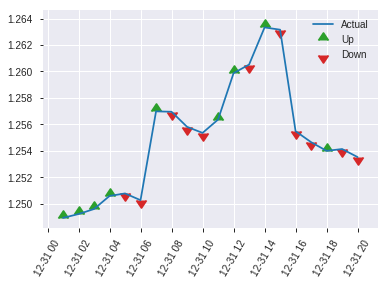


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.205053078525843
RMSE: 0.4528278685392972
LogLoss: 0.595778068577097
Mean Per-Class Error: 0.3130739970157409
AUC: 0.7460542630771494
pr_auc: 0.7331259117705008
Gini: 0.4921085261542988
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3314846456050873: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      137  169  0.5523   (169.0/306.0)
1      40   271  0.1286   (40.0/311.0)
Total  177  440  0.3387   (209.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.331485     0.721704  282
max f2                       0.171217     0.853659  363
max f0point5                 0.591719     0.687225  134
max accuracy                 0.469921     0.687196  210
max precision                0.913358     0.916667  9
max recall                   0.0995522    1         393
max specificity              0.944596     0.996732  0
max absolute_mcc             0.469921     0.374751  210
max min_per_class_accuracy   0.491138     0.673203  196
max mean_per_class_accuracy  0.469921     0.686926  210

Gains/Lift Table: Avg response rate: 50.41 %, avg score: 47.80 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.918953           1.70051   1.70051            0.857143         0.929195  0.857143                    0.929195            0.0192926       0.0192926                  70.0505   70.0505
    2        0.0210697                   0.907619           1.65327   1.6787             0.833333         0.914383  0.846154                    0.922359            0.0160772       0.0353698                  65.3269   67.8704
    3        0.0307942                   0.89199            1.98392   1.77509            1                0.901735  0.894737                    0.915846            0.0192926       0.0546624                  98.3923   77.5089
    4        0.0405186                   0.86988            1.65327   1.74585            0.833333         0.883653  0.88                        0.90812             0.0160772       0.0707395                  65.3269   74.5852
    5        0.0502431                   0.829209           1.65327   1.72793            0.833333         0.849152  0.870968                    0.896707            0.0160772       0.0868167                  65.3269   72.7933
    6        0.100486                    0.751202           1.66394   1.69593            0.83871          0.78736   0.854839                    0.842033            0.0836013       0.170418                   66.3935   69.5934
    7        0.150729                    0.700368           1.47194   1.62127            0.741935         0.725052  0.817204                    0.803039            0.073955        0.244373                   47.1943   62.127
    8        0.200972                    0.672002           1.66394   1.63194            0.83871          0.684431  0.822581                    0.773387            0.0836013       0.327974                   66.3935   63.1937
    9        0.299838                    0.611235           1.30093   1.52279            0.655738         0.64015   0.767568                    0.729455            0.128617        0.456592                   30.0933   52.2795
    10       0.400324                    0.550527           1.05596   1.40561            0.532258         0.580748  0.708502                    0.692128            0.106109        0.562701                   5.59589   40.5613
    11       0.50081                     0.492036           1.08796   1.34188            0.548387         0.523095  0.676375                    0.658212            0.109325        0.672026                   8.79577   34.1877
    12       0.599676                    0.421028           0.9757    1.28151            0.491803         0.457824  0.645946                    0.625175            0.096463        0.768489                   -2.43002  28.1507
    13       0.700162                    0.341561           0.831968  1.21699            0.419355         0.377653  0.613426                    0.589651            0.0836013       0.85209                    -16.8032  21.699
    14       0.799028                    0.255654           0.650467  1.14689            0.327869         0.301198  0.578093                    0.55396             0.0643087       0.916399                   -34.9533  14.6893
    15       0.899514                    0.175006           0.671974  1.09384            0.33871          0.217061  0.551351                    0.516325            0.0675241       0.983923                   -32.8026  9.38385
    16       1                           0.0802346          0.159994  1                  0.0806452        0.134826  0.504052                    0.477989           

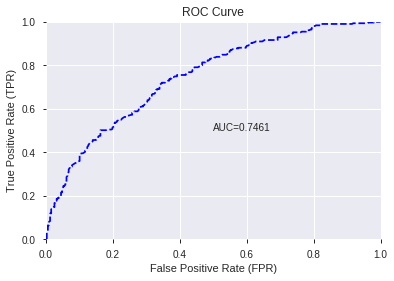

This function is available for GLM models only


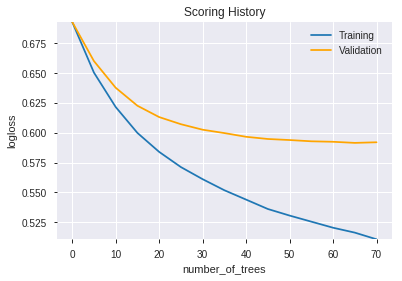

--2019-08-24 18:39:24--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.36.84
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.36.84|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190824_183850_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190824_183850_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_9a5d',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'STOCHF_fastk',
 'CCI_8',
 'TRANGE',
 'ADOSC',
 'DIV',
 'CDLCLOSINGMARUBOZU',
 'STOCHRSI_fastk',
 'STOCHRSI_fastd',
 'SUB',
 'STOCH_slowk',
 'ULTOSC',
 'ATR_8',
 'WILLR_12',
 'CCI_12',
 'WILLR_14',
 'WILLR_24',
 'CMO_8',
 'NATR_8',
 'MOM_20',
 'WILLR_8',
 'MINUS_DM_8',
 'CCI_20',
 'CCI_30',
 'CDLHAMMER',
 'MOM_14',
 'MINUS_DM_12',
 'CMO_30',
 'MOM_8',
 'WILLR_30',
 'NATR_14',
 'WILLR_20',
 'CCI_14',
 'ATR_12',
 'NATR_12',
 'MOM_12',
 'ROC_12',
 'CCI_24',
 'CDLDRAGONFLYDOJI',
 'STOCHF_fastd',
 'ROC_20',
 'ROC_14',
 'CMO_24',
 'CDLTAKURI',
 'CMO_20',
 'CMO_12',
 'ROC_8',
 'CDLENGULFING',
 'CMO_14',
 'RSI_8',
 'ROCP_12',
 'CDLSHORTLINE',
 'RSI_20',
 'RSI_12',
 'ROCP_20',
 'ROCP_8',
 'ROCP_14',
 'RSI_14',
 'RSI_30',
 'CDLBELTHOLD',
 'CDLHANGINGMAN',
 'CDLLONGLINE',
 'ROCR_8',
 'ROCR_14',
 'ROCR_20',
 'RSI_24',
 'CDLMARUBOZU']

In [50]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [51]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

55

['BBANDS_lowerband_12_3_3',
 'MA_30_1',
 'BOP',
 'aroondown_8',
 'aroonup_8',
 'AROONOSC_8',
 'CCI_8',
 'CMO_8',
 'MFI_8',
 'PLUS_DI_8',
 'PLUS_DM_8',
 'ROCP_8',
 'CCI_12',
 'MFI_12',
 'WILLR_12',
 'ADXR_14',
 'aroonup_14',
 'AROONOSC_14',
 'CCI_14',
 'MFI_14',
 'MINUS_DI_14',
 'WILLR_14',
 'PLUS_DM_20',
 'ROC_20',
 'ROCP_20',
 'WILLR_20',
 'aroondown_24',
 'aroonup_24',
 'CMO_24',
 'DX_24',
 'MACDFIX_hist_24',
 'MOM_24',
 'aroondown_30',
 'CCI_30',
 'MFI_30',
 'STOCH_slowd',
 'STOCHF_fastk',
 'STOCHF_fastd',
 'STOCHRSI_fastk',
 'STOCHRSI_fastd',
 'ULTOSC',
 'NATR_8',
 'ATR_12',
 'NATR_14',
 'TRANGE',
 'HT_DCPERIOD',
 'HT_PHASOR_quadrature',
 'CDLCLOSINGMARUBOZU',
 'STDDEV_8',
 'LINEARREG_SLOPE_12',
 'LINEARREG_ANGLE_14',
 'TSF_20',
 'BETA_24',
 'DIV',
 'SUB']

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190824_184522_model_8  0.736087  0.610880              0.350545  0.460672  0.212219
1  DeepLearning_grid_1_AutoML_20190824_184522_model_5  0.731842  0.611831              0.345433  0.461023  0.212543
2  DeepLearning_grid_1_AutoML_20190824_184522_model_3  0.729961  0.698069              0.363433  0.486495  0.236677
3  DeepLearning_grid_1_AutoML_20190824_184522_model_9  0.723993  0.620478              0.361931  0.464308  0.215582
4  DeepLearning_grid_1_AutoML_20190824_184522_model_4  0.721776  0.634468              0.336896  0.467375  0.218439
5  DeepLearning_grid_1_AutoML_20190824_184522_model_6  0.719874  0.617525              0.377162  0.463212  0.214565
6               DeepLearning_1_AutoML_20190824_184522  0.717399  0.623144              0.372102  0.464878  0.216112
7  DeepLearning_grid_1_AutoML_20190824_184522_model_1  0.712607  0.845304              0.398246  0.510784  0.260900
8  DeepLearning_grid_1_AutoML_20190824_184522_model_2  0.710811  0.661929              0.388574  0.475257  0.225869
9  DeepLearning_grid_1_AutoML_20190824_184522_model_7  0.709455  0.683679              0.366701  0.480391  0.230776

variable  relative_importance  scaled_importance  percentage
0                       BOP             1.000000           1.000000    0.051330
1        CDLCLOSINGMARUBOZU             0.771445           0.771445    0.039598
2                       SUB             0.428277           0.428277    0.021983
3                       DIV             0.405058           0.405058    0.020792
4              STOCHF_fastk             0.402849           0.402849    0.020678
5              aroondown_24             0.398175           0.398175    0.020438
6                    TRANGE             0.397011           0.397011    0.020379
7                    ULTOSC             0.392100           0.392100    0.020126
8                aroonup_24             0.376703           0.376703    0.019336
9               HT_DCPERIOD             0.374958           0.374958    0.019247
10                    CCI_8             0.374692           0.374692    0.019233
11             STOCHF_fastd             0.373081           0.373081    0.019150
12               aroonup_14             0.372852           0.372852    0.019138
13                  BETA_24             0.367934           0.367934    0.018886
14                aroonup_8             0.354828           0.354828    0.018213
15              AROONOSC_14             0.353356           0.353356    0.018138
16             aroondown_30             0.349940           0.349940    0.017962
17           STOCHRSI_fastk             0.348637           0.348637    0.017896
18           STOCHRSI_fastd             0.342359           0.342359    0.017573
19                  MA_30_1             0.341263           0.341263    0.017517
20                   ATR_12             0.341049           0.341049    0.017506
21                    DX_24             0.340730           0.340730    0.017490
22                PLUS_DM_8             0.337260           0.337260    0.017312
23                 STDDEV_8             0.335874           0.335874    0.017240
24              MINUS_DI_14             0.335301           0.335301    0.017211
25                   TSF_20             0.334660           0.334660    0.017178
26                 WILLR_14             0.333190           0.333190    0.017103
27                   NATR_8             0.330812           0.330812    0.016981
28                  NATR_14             0.328622           0.328622    0.016868
29                   MFI_14             0.325662           0.325662    0.016716
30  BBANDS_lowerband_12_3_3             0.324478           0.324478    0.016655
31                   MFI_30             0.324134           0.324134    0.016638
32                   MOM_24             0.322739           0.322739    0.016566
33              aroondown_8             0.320998           0.320998    0.016477
34                 WILLR_20             0.320949           0.320949    0.016474
35              STOCH_slowd             0.315680           0.315680    0.016204
36                   ROC_20             0.314106           0.314106    0.016123
37          MACDFIX_hist_24             0.312798           0.312798    0.016056
38                PLUS_DI_8             0.312438           0.312438    0.016037
39               AROONOSC_8             0.311605           0.311605    0.015995
40                   CMO_24             0.310032           0.310032    0.015914
41                  ADXR_14             0.309131           0.309131    0.015868
42                    MFI_8             0.307334           0.307334    0.015775
43                    CMO_8             0.307160           0.307160    0.015766
44                   MFI_12             0.306015           0.306015    0.015708
45                 WILLR_12             0.300998           0.300998    0.015450
46                   CCI_12             0.298888           0.298888    0.015342
47               PLUS_DM_20             0.297935           0.297935    0.015293
48     HT_PHASOR_quadrature             0.297098           0.297098    0.015250
49                 

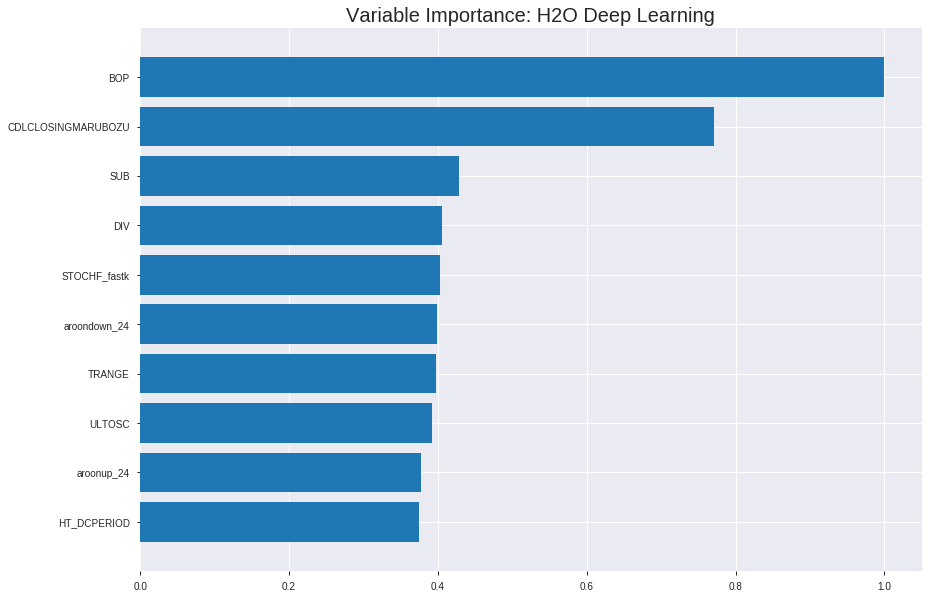

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190824_184522_model_8


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.20275704930431446
RMSE: 0.45028551975864656
LogLoss: 0.5906554853072709
Mean Per-Class Error: 0.3113433342938614
AUC: 0.7577932871993153
pr_auc: 0.749478304653251
Gini: 0.5155865743986305
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4184785626754383: 


0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      964   1209  0.5564   (1209.0/2173.0)
1      258   1882  0.1206   (258.0/2140.0)
Total  1222  3091  0.3401   (1467.0/4313.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.418479     0.719556  258
max f2                       0.343517     0.836706  297
max f0point5                 0.530765     0.692886  182
max accuracy                 0.484358     0.688384  214
max precision                0.961844     1         0
max recall                   0.132774     1         388
max specificity              0.961844     1         0
max absolute_mcc             0.484358     0.378188  214
max min_per_class_accuracy   0.491467     0.681776  209
max mean_per_class_accuracy  0.484358     0.688657  214

Gains/Lift Table: Avg response rate: 49.62 %, avg score: 51.23 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102017                   0.941381           2.01542   2.01542            1                0.947803  1                           0.947803            0.0205607       0.0205607                  101.542   101.542
    2        0.0201716                   0.929918           1.78107   1.89959            0.883721         0.934323  0.942529                    0.941141            0.017757        0.0383178                  78.1069   89.9592
    3        0.0301414                   0.911312           1.92168   1.9069             0.953488         0.920814  0.946154                    0.934417            0.0191589       0.0574766                  92.168    90.6898
    4        0.0401113                   0.88579            1.7342    1.86397            0.860465         0.900469  0.924855                    0.925979            0.0172897       0.0747664                  73.4199   86.3973
    5        0.0500812                   0.848286           1.82794   1.8568             0.906977         0.866129  0.921296                    0.914065            0.0182243       0.0929907                  82.794    85.6799
    6        0.100162                    0.765648           1.60487   1.73084            0.796296         0.799481  0.858796                    0.856773            0.0803738       0.173364                   60.4872   73.0836
    7        0.150012                    0.714964           1.59359   1.68523            0.790698         0.739484  0.836167                    0.817797            0.0794393       0.252804                   59.3588   68.5228
    8        0.200093                    0.671381           1.4929    1.63709            0.740741         0.691211  0.812283                    0.786114            0.0747664       0.32757                    49.2904   63.7091
    9        0.300023                    0.592868           1.31867   1.53103            0.654292         0.631089  0.75966                     0.734479            0.131776        0.459346                   31.8674   53.1034
    10       0.399954                    0.525606           1.24853   1.46045            0.61949          0.554991  0.724638                    0.689633            0.124766        0.584112                   24.8532   46.045
    11       0.500116                    0.490554           0.993714  1.36697            0.493056         0.504346  0.678257                    0.652524            0.0995327       0.683645                   -0.62857  36.6973
    12       0.600046                    0.471391           0.977315  1.30208            0.484919         0.481483  0.646059                    0.624039            0.0976636       0.781308                   -2.26847  30.208
    13       0.699977                    0.428096           0.855735  1.23836            0.424594         0.452186  0.614442                    0.599505            0.085514        0.866822                   -14.4265  23.8359
    14       0.799907                    0.360815           0.668689  1.16719            0.331787         0.396273  0.57913                     0.574116            0.0668224       0.933645                   -33.1311  16.7191
    15       0.899838                    0.273062           0.374092  1.07911            0.185615         0.318849  0.535429                    0.545767            0.0373832       0.971028                   -62.5908  7.91146
    16       1                           0.0522341          0.28925   1                  0.143519         0.212101  0.496174                    0.512347           



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.21014316610150288
RMSE: 0.4584137499044972
LogLoss: 0.6079874794349809
Mean Per-Class Error: 0.31683533628505167
AUC: 0.739347459413873
pr_auc: 0.711578883441532
Gini: 0.47869491882774606
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4213048046449013: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      281  339  0.5468   (339.0/620.0)
1      75   537  0.1225   (75.0/612.0)
Total  356  876  0.336    (414.0/1232.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.421305     0.721774  263
max f2                       0.227203     0.839568  362
max f0point5                 0.497292     0.686872  200
max accuracy                 0.497292     0.683442  200
max precision                0.915248     0.92      12
max recall                   0.178835     1         383
max specificity              0.951102     0.998387  0
max absolute_mcc             0.497292     0.368659  200
max min_per_class_accuracy   0.485642     0.669355  212
max mean_per_class_accuracy  0.492906     0.683165  204

Gains/Lift Table: Avg response rate: 49.68 %, avg score: 49.92 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105519                   0.930816           1.70337   1.70337            0.846154         0.942532  0.846154                    0.942532            0.0179739       0.0179739                  70.3369   70.3369
    2        0.0202922                   0.914195           2.01307   1.85203            1                0.922743  0.92                        0.933033            0.0196078       0.0375817                  101.307   85.2026
    3        0.0300325                   0.897852           1.5098    1.74104            0.75             0.907301  0.864865                    0.924688            0.0147059       0.0522876                  50.9804   74.1035
    4        0.0405844                   0.876318           2.01307   1.81176            1                0.886907  0.9                         0.914865            0.0212418       0.0735294                  101.307   81.1765
    5        0.0503247                   0.82171            1.84532   1.81826            0.916667         0.846863  0.903226                    0.901703            0.0179739       0.0915033                  84.5316   81.8258
    6        0.100649                    0.727183           1.33122   1.57474            0.66129          0.761668  0.782258                    0.831686            0.0669935       0.158497                   33.1225   57.4742
    7        0.150162                    0.674821           1.45205   1.53429            0.721311         0.695901  0.762162                    0.786913            0.0718954       0.230392                   45.2052   53.4287
    8        0.200487                    0.632382           1.4611    1.51592            0.725806         0.650367  0.753036                    0.752639            0.0735294       0.303922                   46.1101   51.5916
    9        0.300325                    0.558909           1.47298   1.50164            0.731707         0.598427  0.745946                    0.701374            0.147059        0.45098                    47.2979   50.1643
    10       0.400162                    0.510399           1.21112   1.42916            0.601626         0.532237  0.709939                    0.659175            0.120915        0.571895                   21.1116   42.9159
    11       0.5                         0.485286           1.01472   1.34641            0.504065         0.495247  0.668831                    0.626443            0.101307        0.673203                   1.47192   34.6405
    12       0.599838                    0.466934           1.01472   1.2912             0.504065         0.477765  0.641407                    0.601697            0.101307        0.77451                    1.47192   29.1199
    13       0.699675                    0.425334           0.916521  1.23774            0.455285         0.449871  0.614849                    0.580033            0.0915033       0.866013                   -8.34795  23.7736
    14       0.799513                    0.364854           0.556459  1.15266            0.276423         0.398528  0.572589                    0.557368            0.0555556       0.921569                   -44.3541  15.2662
    15       0.899351                    0.277071           0.490993  1.07921            0.243902         0.323877  0.536101                    0.531448            0.0490196       0.970588                   -50.9007  7.921
    16       1                           0.0815539          0.29222   1                  0.145161         0.210854  0.496753                    0.49918            


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 18:56:57  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-24 18:56:59  3 min 52.889 sec  587 obs/sec       0.248319  1             1071       0.491233         0.674903            0.0347034      0.694255        0.685279           1.87801          0.398794                         0.495244           0.683077              0.0188932        0.67447           0.654328             1.70337            0.411526
    2019-08-24 18:57:30  4 min 23.700 sec  1180 obs/sec      8.12961   32            35063      0.450286         0.590655            0.188924       0.757793        0.749478           2.01542          0.340134                         0.458414           0.607987              0.159392         0.739347          0.711579             1.70337            0.336039
    2019-08-24 18:58:00  4 min 53.215 sec  1323 obs/sec      17.2546   68            74419      0.446045         0.580119            0.20413        0.773703        0.768109           2.01542          0.329005                         0.461725           0.614467              0.147202         0.736441          0.713606             1.85822            0.316558
    2019-08-24 18:58:30  5 min 23.421 sec  1417 obs/sec      27.4391   108           118345     0.436539         0.560562            0.237689       0.787896        0.774014           2.01542          0.310457                         0.458281           0.610458              0.15988          0.737479          0.716251             1.85822            0.329545
    2019-08-24 18:59:00  5 min 53.353 sec  1472 obs/sec      37.664    148           162445     0.426557         0.537586            0.272155       0.806776        0.799688           2.01542          0.295154                         0.460178           0.612631              0.152911         0.734614          0.719604             2.01307            0.352273
    2019-08-24 18:59:31  6 min 24.325 sec  1515 obs/sec      48.5949   191           209590     0.432825         0.550107            0.250606       0.824083        0.819295           2.01542          0.271505                         0.468443           0.626029              0.122208         0.733933          0.71623              2.01307            0.345779
    2019-08-24 19:00:01  6 min 54.441 sec  1546 obs/sec      59.3272   233           255878     0.419471         0.518579            0.296136       0.838237        0.829937           2.01542          0.257825                         0.465661           0.623934              0.132603         0.732141          0.717183             2.01307            0.326299
    2019-08-24 19:00:04  6 min 57.507 sec  1545 obs/sec      59.3272   233           255878     0.450286         0.590655            0.188924       0.757793        0.749478           2.01542          0.340134                         0.458414           0.607987              0.159392         0.739347          0.711579             1.70337            0.336039

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
BOP                 1.0                    1.0                  0.05132990367692948
CDLCLOSINGMARUBOZU  0.7714447379112244     0.7714447379112244   0.039598184089057256
SUB                 0.4282771944999695     0.4282771944999695   0.021983427140709028
DIV                 0.40505751967430115    0.40505751967430115  0.020791563468497847
STOCHF_fastk        0.4028492867946625     0.4028492867946625   0.020678215087489765
---                 ---                    ---                  ---
LINEARREG_SLOPE_12  0.2882322371006012     0.2882322371006012   0.014794932966959759
ROCP_20             0.28818419575691223    0.28818419575691223  0.014792467009415694
LINEARREG_ANGLE_14  0.2847540080547333     0.2847540080547333   0.01461639580506906
CCI_14              0.2774006724357605     0.2774006724357605   0.014238949796043053
CCI_30              0.26641836762428284    0.26641836762428284  0.013675229147919226


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6904376012965965)

('F1', 0.7240051347881901)

('auc', 0.7360874682134376)

('logloss', 0.6108801652493029)

('mean_per_class_error', 0.3100161822499632)

('rmse', 0.46067221393339436)

('mse', 0.21221888869029504)

deeplearning prediction progress: |███████████████████████████████████████| 100%


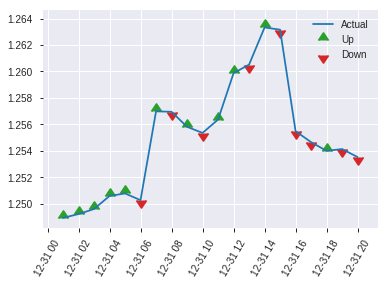


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.21221888869029504
RMSE: 0.46067221393339436
LogLoss: 0.6108801652493029
Mean Per-Class Error: 0.3100161822499632
AUC: 0.7360874682134376
pr_auc: 0.7159891464019029
Gini: 0.47217493642687525
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3833711869744798: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      120  186  0.6078   (186.0/306.0)
1      29   282  0.0932   (29.0/311.0)
Total  149  468  0.3485   (215.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.383371     0.724005  284
max f2                       0.267646     0.852778  350
max f0point5                 0.47265      0.687617  205
max accuracy                 0.464487     0.690438  215
max precision                0.945587     1         0
max recall                   0.126102     1         395
max specificity              0.945587     1         0
max absolute_mcc             0.464487     0.382496  215
max min_per_class_accuracy   0.477367     0.675241  198
max mean_per_class_accuracy  0.464487     0.689984  215

Gains/Lift Table: Avg response rate: 50.41 %, avg score: 47.68 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.928938           1.70051   1.70051            0.857143         0.933102  0.857143                    0.933102            0.0192926       0.0192926                  70.0505   70.0505
    2        0.0210697                   0.910162           1.98392   1.83131            1                0.918304  0.923077                    0.926272            0.0192926       0.0385852                  98.3923   83.1313
    3        0.0307942                   0.886031           1.98392   1.87951            1                0.897659  0.947368                    0.917236            0.0192926       0.0578778                  98.3923   87.9506
    4        0.0405186                   0.835254           1.98392   1.90457            1                0.8627    0.96                        0.904147            0.0192926       0.0771704                  98.3923   90.4566
    5        0.0502431                   0.795265           1.32262   1.79193            0.666667         0.809956  0.903226                    0.885917            0.0128617       0.0900322                  32.2615   79.193
    6        0.100486                    0.683448           1.47194   1.63194            0.741935         0.733331  0.822581                    0.809624            0.073955        0.163987                   47.1943   63.1937
    7        0.150729                    0.629996           1.21595   1.49328            0.612903         0.658003  0.752688                    0.759083            0.0610932       0.22508                    21.5953   49.3275
    8        0.200972                    0.584349           1.47194   1.48794            0.741935         0.603972  0.75                        0.720306            0.073955        0.299035                   47.1943   48.7942
    9        0.299838                    0.520823           1.3985    1.45845            0.704918         0.553768  0.735135                    0.665393            0.138264        0.437299                   39.8503   45.8451
    10       0.400324                    0.490749           1.21595   1.39758            0.612903         0.503275  0.704453                    0.6247              0.122186        0.559486                   21.5953   39.7581
    11       0.50081                     0.477146           1.15196   1.3483             0.580645         0.483762  0.679612                    0.596421            0.115756        0.675241                   15.1955   34.8297
    12       0.599676                    0.451501           0.943176  1.28151            0.47541          0.465034  0.645946                    0.57476             0.0932476       0.768489                   -5.68236  28.1507
    13       0.700162                    0.409164           0.831968  1.21699            0.419355         0.431237  0.613426                    0.554162            0.0836013       0.85209                    -16.8032  21.699
    14       0.799028                    0.347552           0.78056   1.16299            0.393443         0.384751  0.586207                    0.5332              0.0771704       0.92926                    -21.944   16.2989
    15       0.899514                    0.268452           0.543979  1.09384            0.274194         0.30639   0.551351                    0.507863            0.0546624       0.983923                   -45.6021  9.38385
    16       1                           0.0550704          0.159994  1                  0.0806452        0.198303  0.504052                    0.476756           

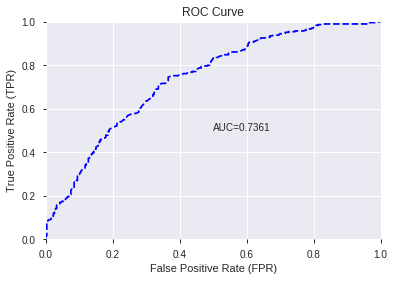

This function is available for GLM models only


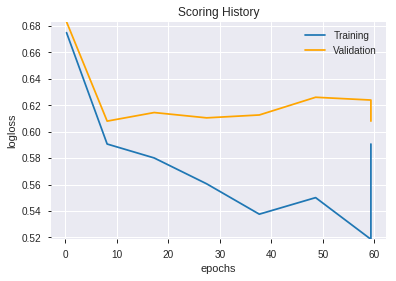

--2019-08-24 19:06:11--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.104.27
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.104.27|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190824_184522_model_8',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190824_184522_model_8',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_9a5d',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'CDLCLOSINGMARUBOZU',
 'SUB',
 'DIV',
 'STOCHF_fastk',
 'aroondown_24',
 'TRANGE',
 'ULTOSC',
 'aroonup_24',
 'HT_DCPERIOD',
 'CCI_8',
 'STOCHF_fastd',
 'aroonup_14',
 'BETA_24',
 'aroonup_8',
 'AROONOSC_14',
 'aroondown_30',
 'STOCHRSI_fastk',
 'STOCHRSI_fastd',
 'MA_30_1',
 'ATR_12',
 'DX_24',
 'PLUS_DM_8',
 'STDDEV_8',
 'MINUS_DI_14',
 'TSF_20',
 'WILLR_14',
 'NATR_8',
 'NATR_14',
 'MFI_14',
 'BBANDS_lowerband_12_3_3',
 'MFI_30',
 'MOM_24',
 'aroondown_8',
 'WILLR_20',
 'STOCH_slowd',
 'ROC_20',
 'MACDFIX_hist_24',
 'PLUS_DI_8',
 'AROONOSC_8',
 'CMO_24',
 'ADXR_14',
 'MFI_8',
 'CMO_8',
 'MFI_12',
 'WILLR_12',
 'CCI_12',
 'PLUS_DM_20',
 'HT_PHASOR_quadrature',
 'ROCP_8',
 'LINEARREG_SLOPE_12',
 'ROCP_20',
 'LINEARREG_ANGLE_14',
 'CCI_14',
 'CCI_30']

In [52]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190824_190708_model_1  0.733765  0.604116              0.363827  0.457507  0.209312

variable  relative_importance  scaled_importance  percentage
0                       BOP             0.558883           1.000000    0.142734
1              STOCHF_fastk             0.203179           0.363545    0.051890
2                     CMO_8             0.191671           0.342953    0.048951
3                     CCI_8             0.176970           0.316649    0.045196
4        CDLCLOSINGMARUBOZU             0.176566           0.315926    0.045093
5                    ULTOSC             0.160935           0.287958    0.041101
6                  STDDEV_8             0.135033           0.241612    0.034486
7               STOCH_slowd             0.127586           0.228288    0.032584
8              STOCHF_fastd             0.120650           0.215877    0.030813
9                       SUB             0.112912           0.202032    0.028837
10                PLUS_DM_8             0.112792           0.201816    0.028806
11                 WILLR_12             0.107065           0.191569    0.027343
12             aroondown_24             0.106659           0.190843    0.027240
13                   TRANGE             0.105936           0.189549    0.027055
14                      DIV             0.099364           0.177791    0.025377
15              MINUS_DI_14             0.096104           0.171958    0.024544
16                PLUS_DI_8             0.083305           0.149057    0.021275
17                 WILLR_14             0.080288           0.143658    0.020505
18                   CCI_12             0.076818           0.137448    0.019618
19                   NATR_8             0.074279           0.132906    0.018970
20                   CMO_24             0.072085           0.128980    0.018410
21                   ROCP_8             0.065204           0.116669    0.016653
22                 WILLR_20             0.063771           0.114105    0.016287
23               aroonup_14             0.061303           0.109689    0.015656
24                  NATR_14             0.058535           0.104735    0.014949
25                   CCI_14             0.052617           0.094147    0.013438
26          MACDFIX_hist_24             0.051449           0.092056    0.013140
27                   MFI_30             0.050759           0.090823    0.012963
28                  BETA_24             0.050715           0.090744    0.012952
29               aroonup_24             0.047206           0.084465    0.012056
30              HT_DCPERIOD             0.046251           0.082756    0.011812
31           STOCHRSI_fastk             0.039571           0.070803    0.010106
32                   CCI_30             0.038077           0.068130    0.009724
33           STOCHRSI_fastd             0.037246           0.066644    0.009512
34                    MFI_8             0.028312           0.050659    0.007231
35              AROONOSC_14             0.027201           0.048671    0.006947
36                  ROCP_20             0.026273           0.047010    0.006710
37                   ROC_20             0.025471           0.045575    0.006505
38                  MA_30_1             0.021916           0.039214    0.005597
39                aroonup_8             0.016126           0.028855    0.004119
40                  ADXR_14             0.015484           0.027705    0.003954
41       LINEARREG_ANGLE_14             0.015047           0.026923    0.003843
42                   MFI_14             0.013996           0.025044    0.003575
43                   MFI_12             0.013799           0.024690    0.003524
44  BBANDS_lowerband_12_3_3             0.011339           0.020288    0.002896
45             aroondown_30             0.010207           0.018263    0.002607
46     HT_PHASOR_quadrature             0.009973           0.017844    0.002547
47                   TSF_20             0.008264           0.014786    0.002110
48              aroondown_8             0.007154           0.012801    0.001827
49               AR

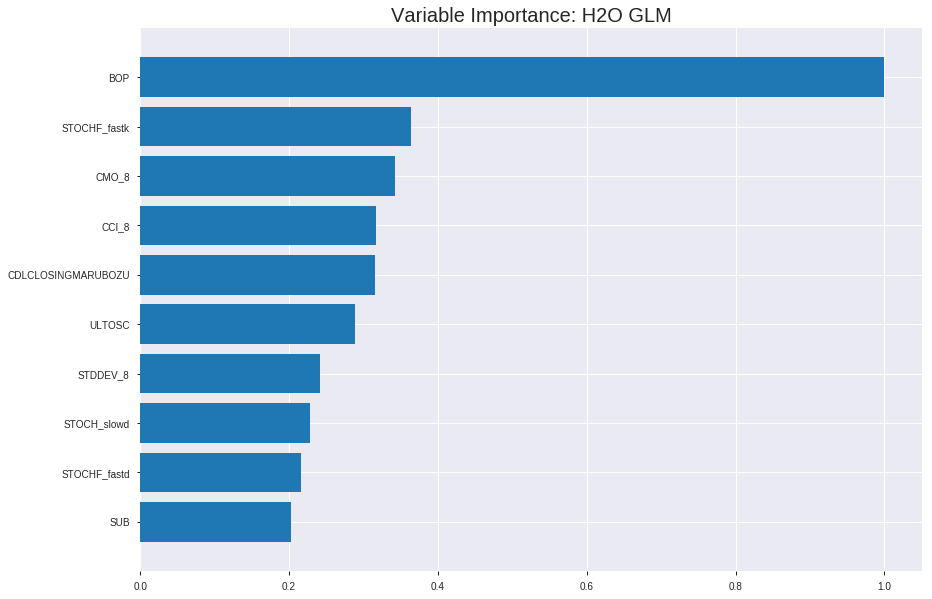

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190824_190708_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.20083834411532706
RMSE: 0.4481499125463789
LogLoss: 0.5870208392699549
Null degrees of freedom: 4312
Residual degrees of freedom: 4257
Null deviance: 5978.835084581811
Residual deviance: 5063.641759542629
AIC: 5175.641759542629
AUC: 0.7574194339192555
pr_auc: 0.7470879356454694
Gini: 0.514838867838511
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.38242432263168574: 


0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      1021  1152  0.5301   (1152.0/2173.0)
1      296   1844  0.1383   (296.0/2140.0)
Total  1317  2996  0.3357   (1448.0/4313.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.382424     0.718069  254
max f2                       0.243817     0.836043  322
max f0point5                 0.576175     0.695807  153
max accuracy                 0.537885     0.689543  173
max precision                0.919448     1         0
max recall                   0.059348     1         391
max specificity              0.919448     1         0
max absolute_mcc             0.564294     0.38125   160
max min_per_class_accuracy   0.516906     0.686916  185
max mean_per_class_accuracy  0.525453     0.68942   180

Gains/Lift Table: Avg response rate: 49.62 %, avg score: 49.62 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102017                   0.875667           2.01542   2.01542            1                0.889103  1                           0.889103            0.0205607       0.0205607                  101.542   101.542
    2        0.0201716                   0.855476           1.82794   1.92276            0.906977         0.865587  0.954023                    0.87748             0.0182243       0.038785                   82.794    92.2758
    3        0.0301414                   0.835322           1.7342    1.86039            0.860465         0.846677  0.923077                    0.867291            0.0172897       0.0560748                  73.4199   86.0388
    4        0.0401113                   0.818356           1.78107   1.84067            0.883721         0.826945  0.913295                    0.857263            0.017757        0.0738318                  78.1069   84.0673
    5        0.0500812                   0.800553           1.59359   1.79148            0.790698         0.807746  0.888889                    0.847405            0.0158879       0.0897196                  59.3588   79.1485
    6        0.100162                    0.754574           1.67019   1.73084            0.828704         0.773961  0.858796                    0.810683            0.0836449       0.173364                   67.0186   73.0836
    7        0.150012                    0.716729           1.56547   1.67588            0.776744         0.734346  0.83153                     0.785316            0.0780374       0.251402                   56.5466   67.5883
    8        0.200093                    0.686814           1.38094   1.60206            0.685185         0.701278  0.794902                    0.764282            0.0691589       0.320561                   38.0936   60.2061
    9        0.300023                    0.633285           1.43558   1.54661            0.712297         0.660014  0.767388                    0.729553            0.143458        0.464019                   43.5578   54.6609
    10       0.399954                    0.573404           1.23918   1.4698             0.614849         0.60303   0.729275                    0.697941            0.123832        0.58785                    23.918    46.9797
    11       0.500116                    0.514419           1.01238   1.37819            0.502315         0.543938  0.68382                     0.667098            0.101402        0.689252                   1.23756   37.8185
    12       0.600046                    0.446435           0.907173  1.29974            0.450116         0.480685  0.6449                      0.636053            0.0906542       0.779907                   -9.28269  29.9744
    13       0.699977                    0.377237           0.837031  1.23369            0.415313         0.412338  0.612123                    0.604115            0.0836449       0.863551                   -16.2969  23.3686
    14       0.799907                    0.302697           0.682718  1.16485            0.338747         0.33863   0.577971                    0.570948            0.0682243       0.931776                   -31.7282  16.4855
    15       0.899838                    0.203049           0.397473  1.07963            0.197216         0.258678  0.535687                    0.536269            0.0397196       0.971495                   -60.2527  7.96339
    16       1                           0.0151908          0.284585  1                  0.141204         0.135968  0.496174                    0.496174         



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.20672267955906592
RMSE: 0.4546676583605501
LogLoss: 0.6005234435143489
Null degrees of freedom: 1231
Residual degrees of freedom: 1176
Null deviance: 1707.8643560108549
Residual deviance: 1479.6897648193558
AIC: 1591.6897648193558
AUC: 0.7399615222433059
pr_auc: 0.7130715328165111
Gini: 0.4799230444866118
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4109648500260394: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      337  283  0.4565   (283.0/620.0)
1      105  507  0.1716   (105.0/612.0)
Total  442  790  0.3149   (388.0/1232.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.410965     0.723252  235
max f2                       0.168468     0.839141  353
max f0point5                 0.489327     0.685433  193
max accuracy                 0.450102     0.690747  214
max precision                0.908989     1         0
max recall                   0.0831878    1         388
max specificity              0.908989     1         0
max absolute_mcc             0.416513     0.388402  232
max min_per_class_accuracy   0.497834     0.681373  188
max mean_per_class_accuracy  0.450102     0.691277  214

Gains/Lift Table: Avg response rate: 49.68 %, avg score: 48.36 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105519                   0.875095           1.70337   1.70337            0.846154         0.887752  0.846154                    0.887752            0.0179739       0.0179739                  70.3369   70.3369
    2        0.0202922                   0.848345           1.67756   1.69098            0.833333         0.860655  0.84                        0.874745            0.0163399       0.0343137                  67.756    69.098
    3        0.0300325                   0.836235           1.84532   1.74104            0.916667         0.842814  0.864865                    0.864389            0.0179739       0.0522876                  84.5316   74.1035
    4        0.0405844                   0.815921           1.70337   1.73124            0.846154         0.823125  0.86                        0.85366             0.0179739       0.0702614                  70.3369   73.1242
    5        0.0503247                   0.795848           2.01307   1.78579            1                0.804807  0.887097                    0.844205            0.0196078       0.0898693                  101.307   78.579
    6        0.100649                    0.730877           1.42863   1.60721            0.709677         0.757152  0.798387                    0.800678            0.0718954       0.161765                   42.8632   60.7211
    7        0.150162                    0.701701           1.25404   1.49076            0.622951         0.715354  0.740541                    0.772544            0.0620915       0.223856                   25.4045   49.0761
    8        0.200487                    0.673664           1.68838   1.54037            0.83871          0.686024  0.765182                    0.750827            0.0849673       0.308824                   68.8383   54.0367
    9        0.300325                    0.617886           1.37478   1.48532            0.682927         0.643944  0.737838                    0.715296            0.137255        0.446078                   37.4781   48.5321
    10       0.400162                    0.553644           1.17838   1.40874            0.585366         0.587189  0.699797                    0.683334            0.117647        0.563725                   17.8384   40.8742
    11       0.5                         0.494899           1.19475   1.36601            0.593496         0.526485  0.678571                    0.652015            0.119281        0.683007                   19.475    36.6013
    12       0.599838                    0.436481           1.01472   1.30754            0.504065         0.465122  0.649526                    0.620908            0.101307        0.784314                   1.47192   30.7543
    13       0.699675                    0.365925           0.801955  1.2354             0.398374         0.40268   0.613689                    0.589769            0.0800654       0.864379                   -19.8045  23.54
    14       0.799513                    0.290283           0.540092  1.14858            0.268293         0.328794  0.570558                    0.55718             0.0539216       0.918301                   -45.9908  14.8575
    15       0.899351                    0.199547           0.523726  1.07921            0.260163         0.246581  0.536101                    0.5227              0.0522876       0.970588                   -47.6274  7.921
    16       1                           0.0306808          0.29222   1                  0.145161         0.134506  0.496753                    0.483629            0.0


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-24 19:07:09  0.000 sec   2            20        56            1.37205           1.3711
    2019-08-24 19:07:09  0.033 sec   4            12        56            1.36496           1.3637
    2019-08-24 19:07:09  0.056 sec   6            7.6       56            1.35514           1.3536
    2019-08-24 19:07:09  0.076 sec   8            4.7       56            1.34209           1.34045
    2019-08-24 19:07:09  0.095 sec   10           2.9       56            1.32555           1.32414
    2019-08-24 19:07:09  0.114 sec   12           1.8       56            1.30577           1.3051
    2019-08-24 19:07:09  0.134 sec   14           1.1       56            1.28375           1.28451
    2019-08-24 19:07:09  0.151 sec   16           0.7       56            1.26111           1.26396
    2019-08-24 19:07:09  0.169 sec   18           0.44      56            1.23957           1.24506
    2019-08-24 19:07:09  0.187 sec   20           0.27      56            1.2206            1.22912
    2019-08-24 19:07:09  0.204 sec   22           0.17      56            1.20505           1.21688
    2019-08-24 19:07:09  0.223 sec   24           0.1       56            1.19314           1.20851
    2019-08-24 19:07:09  0.241 sec   26           0.065     56            1.18449           1.20363
    2019-08-24 19:07:09  0.258 sec   28           0.04      56            1.17838           1.20143
    2019-08-24 19:07:09  0.275 sec   30           0.025     56            1.17404           1.20105
    2019-08-24 19:07:09  0.292 sec   32           0.016     56            1.17088           1.20163
    2019-08-24 19:07:09  0.310 sec   34           0.0096    56            1.16853           1.20271
    2019-08-24 19:07:09  0.333 sec   36           0.006     56            1.16681           1.20402
    2019-08-24 19:07:09  0.350 sec   38           0.0037    56            1.1656            1.2054
    2019-08-24 19:07:09  0.369 sec   40           0.0023    56            1.16477           1.2066

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6790923824959482)

('F1', 0.7222914072229142)

('auc', 0.73376521026417)

('logloss', 0.6041161132886639)

('mean_per_class_error', 0.3214015509740873)

('rmse', 0.4575065795523488)

('mse', 0.20931227033368968)

glm prediction progress: |████████████████████████████████████████████████| 100%


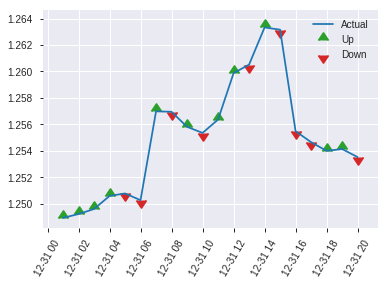


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.20931227033368968
RMSE: 0.4575065795523488
LogLoss: 0.6041161132886639
Null degrees of freedom: 616
Residual degrees of freedom: 561
Null deviance: 855.4562567606156
Residual deviance: 745.4792837982113
AIC: 857.4792837982113
AUC: 0.73376521026417
pr_auc: 0.7231022852553393
Gini: 0.46753042052833993
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.28305401472618297: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      104  202  0.6601   (202.0/306.0)
1      21   290  0.0675   (21.0/311.0)
Total  125  492  0.3614   (223.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.283054     0.722291  301
max f2                       0.186576     0.848637  348
max f0point5                 0.492883     0.677263  178
max accuracy                 0.429176     0.679092  216
max precision                0.883551     1         0
max recall                   0.0793014    1         385
max specificity              0.883551     1         0
max absolute_mcc             0.386137     0.362145  243
max min_per_class_accuracy   0.469879     0.660131  193
max mean_per_class_accuracy  0.429176     0.678598  216

Gains/Lift Table: Avg response rate: 50.41 %, avg score: 46.25 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.852487           1.98392   1.98392            1                0.870043  1                           0.870043            0.022508        0.022508                   98.3923   98.3923
    2        0.0210697                   0.819058           1.65327   1.83131            0.833333         0.832692  0.923077                    0.852804            0.0160772       0.0385852                  65.3269   83.1313
    3        0.0307942                   0.80336            1.98392   1.87951            1                0.812496  0.947368                    0.840075            0.0192926       0.0578778                  98.3923   87.9506
    4        0.0405186                   0.789488           1.65327   1.82521            0.833333         0.794515  0.92                        0.829141            0.0160772       0.073955                   65.3269   82.5209
    5        0.0502431                   0.777886           1.98392   1.85593            1                0.784789  0.935484                    0.820557            0.0192926       0.0932476                  98.3923   85.5928
    6        0.100486                    0.718409           1.40795   1.63194            0.709677         0.747695  0.822581                    0.784126            0.0707395       0.163987                   40.7945   63.1937
    7        0.150729                    0.685256           1.34395   1.53594            0.677419         0.703692  0.774194                    0.757315            0.0675241       0.231511                   34.3948   53.594
    8        0.200972                    0.652003           1.40795   1.50394            0.709677         0.668333  0.758065                    0.735069            0.0707395       0.302251                   40.7945   50.3941
    9        0.299838                    0.593141           1.30093   1.437              0.655738         0.624597  0.724324                    0.698643            0.128617        0.430868                   30.0933   43.7004
    10       0.400324                    0.531793           1.27995   1.39758            0.645161         0.56065   0.704453                    0.664005            0.128617        0.559486                   27.995    39.7581
    11       0.50081                     0.46994            1.02396   1.32262            0.516129         0.499966  0.666667                    0.631091            0.102894        0.662379                   2.39602   32.2615
    12       0.599676                    0.407702           1.10579   1.28687            0.557377         0.436853  0.648649                    0.599068            0.109325        0.771704                   10.5793   28.6869
    13       0.700162                    0.337698           0.735971  1.2078             0.370968         0.375794  0.608796                    0.567024            0.073955        0.845659                   -26.4029  20.7805
    14       0.799028                    0.280883           0.87813   1.16701            0.442623         0.313873  0.588235                    0.535701            0.0868167       0.932476                   -12.187   16.7013
    15       0.899514                    0.181738           0.479981  1.09026            0.241935         0.231007  0.54955                     0.501663            0.0482315       0.980707                   -52.0019  9.02639
    16       1                           0.00890556         0.191993  1                  0.0967742        0.111946  0.504052                    0.462502          

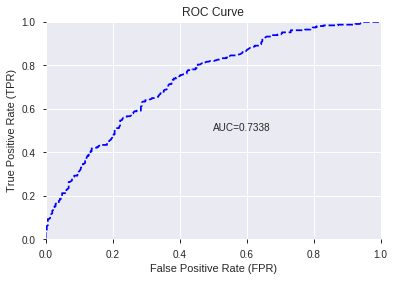

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


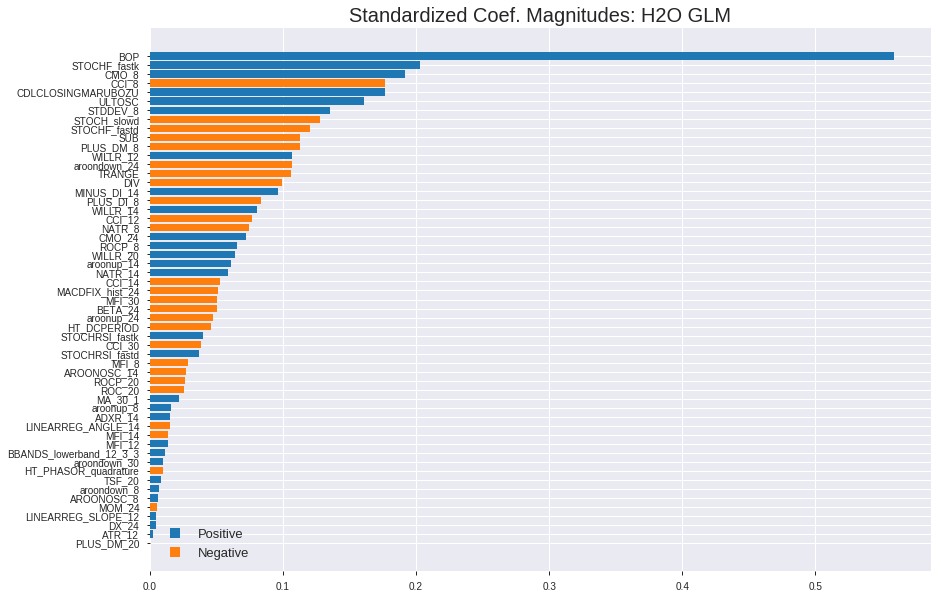

'log_likelihood'
--2019-08-24 19:07:19--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.138.4
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.138.4|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190824_190708_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190824_190708_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_9a5d',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['BOP',
 'STOCHF_fastk',
 'CMO_8',
 'CCI_8',
 'CDLCLOSINGMARUBOZU',
 'ULTOSC',
 'STDDEV_8',
 'STOCH_slowd',
 'STOCHF_fastd',
 'SUB',
 'PLUS_DM_8',
 'WILLR_12',
 'aroondown_24',
 'TRANGE',
 'DIV',
 'MINUS_DI_14',
 'PLUS_DI_8',
 'WILLR_14',
 'CCI_12',
 'NATR_8',
 'CMO_24',
 'ROCP_8',
 'WILLR_20',
 'aroonup_14',
 'NATR_14',
 'CCI_14',
 'MACDFIX_hist_24',
 'MFI_30',
 'BETA_24',
 'aroonup_24',
 'HT_DCPERIOD',
 'STOCHRSI_fastk',
 'CCI_30',
 'STOCHRSI_fastd',
 'MFI_8',
 'AROONOSC_14',
 'ROCP_20',
 'ROC_20',
 'MA_30_1',
 'aroonup_8',
 'ADXR_14',
 'LINEARREG_ANGLE_14',
 'MFI_14',
 'MFI_12',
 'BBANDS_lowerband_12_3_3',
 'aroondown_30',
 'HT_PHASOR_quadrature',
 'TSF_20',
 'aroondown_8',
 'AROONOSC_8',
 'MOM_24',
 'LINEARREG_SLOPE_12',
 'DX_24',
 'ATR_12',
 'PLUS_DM_20']

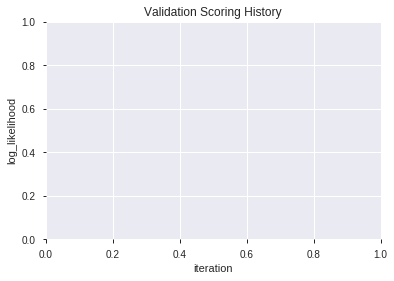

In [53]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190824_190816_model_7  0.732546  0.608701              0.358873  0.458660  0.210369
1  XGBoost_grid_1_AutoML_20190824_190816_model_2  0.732289  0.607314              0.330465  0.458218  0.209963
2               XGBoost_3_AutoML_20190824_190816  0.729294  0.607272              0.338766  0.458572  0.210289
3  XGBoost_grid_1_AutoML_20190824_190816_model_1  0.728075  0.612300              0.356976  0.460236  0.211817
4               XGBoost_2_AutoML_20190824_190816  0.727308  0.612119              0.358794  0.460656  0.212204
5  XGBoost_grid_1_AutoML_20190824_190816_model_6  0.726105  0.613100              0.320477  0.460909  0.212437
6               XGBoost_1_AutoML_20190824_190816  0.725558  0.614540              0.357397  0.461930  0.213379
7  XGBoost_grid_1_AutoML_20190824_190816_model_4  0.724912  0.613810              0.375265  0.461586  0.213062
8  XGBoost_grid_1_AutoML_20190824_190816_model_3  0.723562  0.613220              0.337106  0.461200  0.212706
9  XGBoost_grid_1_AutoML_20190824_190816_model_5  0.713364  0.631208              0.327065  0.469250  0.220195

variable  relative_importance  scaled_importance  percentage
0                       BOP          4018.977295           1.000000    0.163049
1              STOCHF_fastk          1096.344849           0.272792    0.044478
2                     CCI_8           678.778198           0.168893    0.027538
3      HT_PHASOR_quadrature           647.076111           0.161005    0.026252
4            STOCHRSI_fastk           599.129517           0.149075    0.024307
5                    TRANGE           588.101135           0.146331    0.023859
6                       DIV           581.230408           0.144621    0.023580
7               HT_DCPERIOD           572.228699           0.142382    0.023215
8                    ULTOSC           561.498108           0.139712    0.022780
9                 PLUS_DI_8           492.353455           0.122507    0.019975
10             STOCHF_fastd           484.971771           0.120670    0.019675
11              STOCH_slowd           483.059082           0.120195    0.019598
12           STOCHRSI_fastd           452.502472           0.112591    0.018358
13                 WILLR_12           443.042755           0.110238    0.017974
14                  BETA_24           437.726135           0.108915    0.017758
15               PLUS_DM_20           437.109222           0.108761    0.017733
16                   MFI_30           433.906647           0.107964    0.017603
17  BBANDS_lowerband_12_3_3           432.347473           0.107576    0.017540
18                  ADXR_14           423.458649           0.105365    0.017180
19       LINEARREG_ANGLE_14           405.572845           0.100914    0.016454
20                    DX_24           403.228180           0.100331    0.016359
21                   NATR_8           400.731873           0.099710    0.016258
22                   MFI_14           398.857941           0.099244    0.016182
23                    MFI_8           396.535004           0.098666    0.016087
24                 STDDEV_8           395.527893           0.098415    0.016046
25                PLUS_DM_8           390.346771           0.097126    0.015836
26          MACDFIX_hist_24           389.619476           0.096945    0.015807
27       CDLCLOSINGMARUBOZU           386.719025           0.096223    0.015689
28       LINEARREG_SLOPE_12           350.004913           0.087088    0.014200
29                   CCI_12           349.114197           0.086866    0.014163
30                    CMO_8           348.013611           0.086593    0.014119
31                   ATR_12           347.393585           0.086438    0.014094
32                   MFI_12           337.592621           0.084000    0.013696
33                   CCI_14           335.141388           0.083390    0.013597
34                      SUB           330.086212           0.082132    0.013392
35                 WILLR_20           325.310822           0.080944    0.013198
36              MINUS_DI_14           319.616211           0.079527    0.012967
37                 WILLR_14           313.862305           0.078095    0.012733
38                   ROCP_8           311.593292           0.077530    0.012641
39                   MOM_24           300.937927           0.074879    0.012209
40                   TSF_20           296.975952           0.073893    0.012048
41                   CCI_30           296.816833           0.073854    0.012042
42                   ROC_20           279.692352           0.069593    0.011347
43                  NATR_14           279.593628           0.069568    0.011343
44               aroonup_24           267.115967           0.066464    0.010837
45                  MA_30_1           262.232941           0.065249    0.010639
46                   CMO_24           258.354584           0.064284    0.010481
47             aroondown_30           227.456818           0.056596    0.009228
48              AROONOSC_14           215.396729           0.053595    0.008739
49               ar

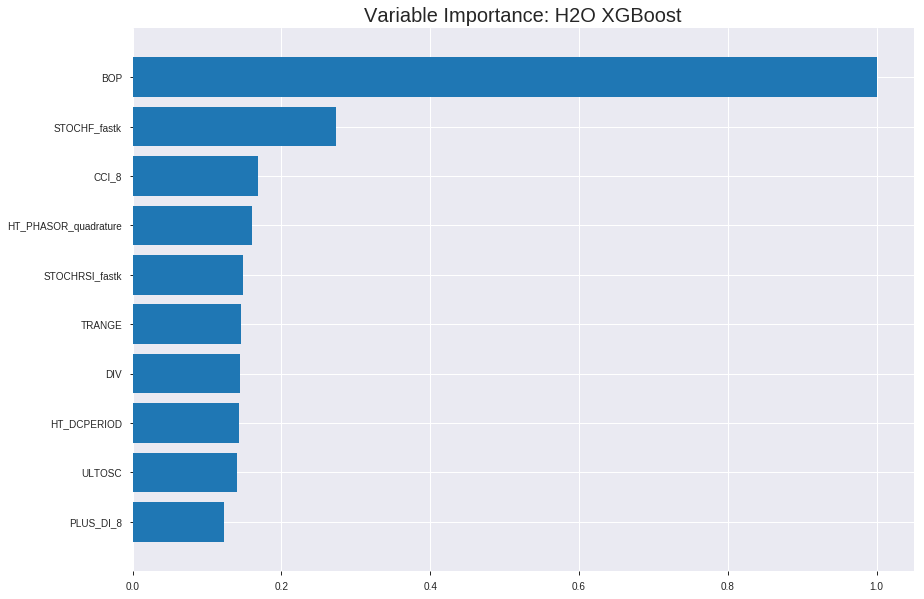

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190824_190816_model_7


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.11583833480750935
RMSE: 0.34035031189571335
LogLoss: 0.39257375352842344
Mean Per-Class Error: 0.11421470382046439
AUC: 0.9559818675245473
pr_auc: 0.9560257418845539
Gini: 0.9119637350490946
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49086304505666095: 


0     1     Error    Rate
-----  ----  ----  -------  --------------
0      1891  282   0.1298   (282.0/2173.0)
1      212   1928  0.0991   (212.0/2140.0)
Total  2103  2210  0.1145   (494.0/4313.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.490863     0.886437  206
max f2                       0.379695     0.919795  252
max f0point5                 0.581357     0.90209   167
max accuracy                 0.492756     0.885694  205
max precision                0.95079      1         0
max recall                   0.204217     1         336
max specificity              0.95079      1         0
max absolute_mcc             0.492756     0.771671  205
max min_per_class_accuracy   0.500378     0.88271   201
max mean_per_class_accuracy  0.492756     0.885785  205

Gains/Lift Table: Avg response rate: 49.62 %, avg score: 49.65 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102017                   0.926612           2.01542    2.01542            1                0.937018  1                           0.937018            0.0205607       0.0205607                  101.542   101.542
    2        0.0201716                   0.913699           2.01542    2.01542            1                0.920654  1                           0.92893             0.0200935       0.0406542                  101.542   101.542
    3        0.0301414                   0.898086           2.01542    2.01542            1                0.904961  1                           0.921002            0.0200935       0.0607477                  101.542   101.542
    4        0.0401113                   0.883665           2.01542    2.01542            1                0.890447  1                           0.913407            0.0200935       0.0808411                  101.542   101.542
    5        0.0500812                   0.871414           2.01542    2.01542            1                0.877597  1                           0.906278            0.0200935       0.100935                   101.542   101.542
    6        0.100162                    0.821257           2.01542    2.01542            1                0.844339  1                           0.875309            0.100935        0.201869                   101.542   101.542
    7        0.150012                    0.782555           1.99667    2.00919            0.990698         0.80032   0.996909                    0.85039             0.0995327       0.301402                   99.6672   100.919
    8        0.200093                    0.747326           1.9781     2.00141            0.981481         0.764328  0.993048                    0.828849            0.0990654       0.400467                   97.8098   100.141
    9        0.300023                    0.672037           1.9406     1.98116            0.962877         0.71043   0.982998                    0.789407            0.193925        0.594393                   94.0602   98.1155
    10       0.399954                    0.594401           1.67874    1.90559            0.832947         0.637353  0.945507                    0.751415            0.167757        0.76215                    67.8738   90.5595
    11       0.500116                    0.49752            1.25497    1.77529            0.622685         0.545389  0.880853                    0.710153            0.125701        0.88785                    25.4973   77.5289
    12       0.600046                    0.407639           0.654661   1.58866            0.324826         0.454854  0.788253                    0.667636            0.0654206       0.953271                   -34.5339  58.8662
    13       0.699977                    0.319204           0.308626   1.40592            0.153132         0.36434   0.697582                    0.624337            0.0308411       0.984112                   -69.1374  40.5921
    14       0.799907                    0.234111           0.130932   1.24664            0.0649652        0.277694  0.618551                    0.581031            0.0130841       0.997196                   -86.9068  24.664
    15       0.899838                    0.158996           0.0280569  1.11131            0.0139211        0.196725  0.551404                    0.538353            0.00280374      1                          -97.1943  11.1312
    16       1                           0.0484532          0          1                  0                0.120947  0.496174                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2089219011632844
RMSE: 0.45707975361339775
LogLoss: 0.604011050270546
Mean Per-Class Error: 0.31744676365169733
AUC: 0.7334809192494203
pr_auc: 0.7282306179676781
Gini: 0.46696183849884054
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3789176195859909: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      327  293  0.4726   (293.0/620.0)
1      108  504  0.1765   (108.0/612.0)
Total  435  797  0.3255   (401.0/1232.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.378918     0.715401  259
max f2                       0.122646     0.834245  388
max f0point5                 0.429887     0.672184  231
max accuracy                 0.401733     0.681818  246
max precision                0.947196     1         0
max recall                   0.102984     1         395
max specificity              0.947196     1         0
max absolute_mcc             0.401733     0.37462   246
max min_per_class_accuracy   0.476355     0.669355  203
max mean_per_class_accuracy  0.401733     0.682553  246

Gains/Lift Table: Avg response rate: 49.68 %, avg score: 48.13 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105519                   0.922039           2.01307   2.01307            1                0.931887  1                           0.931887            0.0212418       0.0212418                  101.307   101.307
    2        0.0202922                   0.901207           1.84532   1.93255            0.916667         0.910956  0.96                        0.92184             0.0179739       0.0392157                  84.5316   93.2549
    3        0.0300325                   0.881265           1.84532   1.90426            0.916667         0.893869  0.945946                    0.912768            0.0179739       0.0571895                  84.5316   90.4257
    4        0.0405844                   0.856032           1.85822   1.89229            0.923077         0.8688    0.94                        0.901336            0.0196078       0.0767974                  85.822    89.2288
    5        0.0503247                   0.835011           1.84532   1.8832             0.916667         0.846037  0.935484                    0.890633            0.0179739       0.0947712                  84.5316   88.3196
    6        0.100649                    0.760318           1.65591   1.76956            0.822581         0.796712  0.879032                    0.843672            0.0833333       0.178105                   65.5914   76.9555
    7        0.150162                    0.727515           1.38605   1.6431             0.688525         0.743204  0.816216                    0.810545            0.0686275       0.246732                   38.605    64.3102
    8        0.200487                    0.694756           1.29876   1.55667            0.645161         0.711318  0.773279                    0.785638            0.0653595       0.312092                   29.8756   55.6667
    9        0.300325                    0.619336           1.21112   1.44179            0.601626         0.656257  0.716216                    0.742627            0.120915        0.433007                   21.1116   44.1795
    10       0.400162                    0.543753           1.17838   1.37608            0.585366         0.57912   0.68357                     0.701833            0.117647        0.550654                   17.8384   37.6076
    11       0.5                         0.475029           1.21112   1.34314            0.601626         0.508422  0.667208                    0.663214            0.120915        0.671569                   21.1116   34.3137
    12       0.599838                    0.413293           1.09655   1.3021             0.544715         0.442917  0.64682                     0.626548            0.109477        0.781046                   9.65514   30.2095
    13       0.699675                    0.337956           0.720123  1.21905            0.357724         0.375412  0.605568                    0.590713            0.0718954       0.852941                   -27.9877  21.9053
    14       0.799513                    0.263744           0.654658  1.14858            0.325203         0.303243  0.570558                    0.554815            0.0653595       0.918301                   -34.5342  14.8575
    15       0.899351                    0.194789           0.425527  1.06831            0.211382         0.228049  0.530686                    0.518541            0.0424837       0.960784                   -57.4473  6.83089
    16       1                           0.081234           0.389627  1                  0.193548         0.149029  0.496753                    0.48135          


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 19:08:38  14.137 sec  0                  0.5              0.693147            0.5             0                  1                0.503826                         0.5                0.693147              0.5               0                    1                  0.503247
    2019-08-24 19:08:38  14.292 sec  5                  0.468338         0.631374            0.854417        0.852145           2.01542          0.241595                         0.482608           0.658715              0.718666          0.698956             2.01307            0.358766
    2019-08-24 19:08:38  14.424 sec  10                 0.445756         0.588472            0.878775        0.878731           2.01542          0.215627                         0.472753           0.639144              0.730478          0.720575             2.01307            0.343344
    2019-08-24 19:08:38  14.565 sec  15                 0.42733          0.553684            0.893465        0.895735           2.01542          0.199165                         0.465413           0.624229              0.737621          0.725723             1.85822            0.337662
    2019-08-24 19:08:38  14.701 sec  20                 0.411744         0.52425             0.90426         0.907367           2.01542          0.183631                         0.461173           0.615112              0.736108          0.723542             2.01307            0.341721
    2019-08-24 19:08:39  14.816 sec  25                 0.400829         0.503378            0.909211        0.912136           2.01542          0.179921                         0.459435           0.611038              0.733704          0.719542             2.01307            0.341721
    2019-08-24 19:08:39  14.956 sec  30                 0.389544         0.482234            0.918811        0.92045            2.01542          0.166705                         0.457579           0.606832              0.735654          0.720959             1.85822            0.359578
    2019-08-24 19:08:39  15.086 sec  35                 0.380433         0.464895            0.924754        0.926403           2.01542          0.155344                         0.456679           0.604369              0.735504          0.721384             2.01307            0.349838
    2019-08-24 19:08:39  15.230 sec  40                 0.371893         0.448882            0.930642        0.931565           2.01542          0.148157                         0.455995           0.602588              0.736564          0.72724              2.01307            0.343344
    2019-08-24 19:08:39  15.351 sec  45                 0.364948         0.436144            0.936461        0.938307           2.01542          0.142592                         0.45588            0.602003              0.736769          0.726367             2.01307            0.343344
    2019-08-24 19:08:39  15.473 sec  50                 0.359116         0.425428            0.941524        0.94193            2.01542          0.133318                         0.456203           0.602307              0.735714          0.726689             2.01307            0.315747
    2019-08-24 19:08:39  15.611 sec  55                 0.351678         0.412286            0.947589        0.948574           2.01542          0.125203                         0.456393           0.60266               0.735235          0

Variable Importances: 


variable              relative_importance    scaled_importance     percentage
--------------------  ---------------------  --------------------  ---------------------
BOP                   4018.977294921875      1.0                   0.1630487932957293
STOCHF_fastk          1096.3448486328125     0.27279199860573594   0.04447840619339552
CCI_8                 678.7781982421875      0.16889326523437906   0.027537843092241058
HT_PHASOR_quadrature  647.0761108398438      0.16100516707507856   0.026251698205968847
STOCHRSI_fastk        599.1295166015625      0.1490751185279361    0.0243065181863978
---                   ---                    ---                   ---
aroondown_24          199.10508728027344     0.04954123217661618   0.008077638124780824
aroonup_8             149.34454345703125     0.03715983756507745   0.00605886667405119
ROCP_20               138.33685302734375     0.03442090931992511   0.0056122877287555105
aroondown_8           99.76642608642578      0.02482383421585494   0.004047496213868385
AROONOSC_8            73.1707763671875       0.018206317427978867  0.0029685180869909607


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6790923824959482)

('F1', 0.7236180904522612)

('auc', 0.7325462875396676)

('logloss', 0.6087009004426693)

('mean_per_class_error', 0.32161171006451883)

('rmse', 0.45866031283501313)

('mse', 0.2103692825699121)

xgboost prediction progress: |████████████████████████████████████████████| 100%


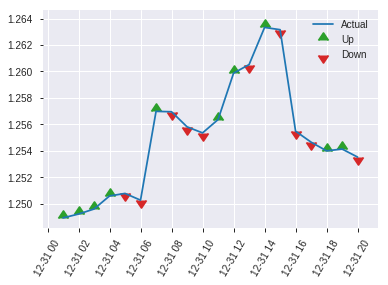


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2103692825699121
RMSE: 0.45866031283501313
LogLoss: 0.6087009004426693
Mean Per-Class Error: 0.32161171006451883
AUC: 0.7325462875396676
pr_auc: 0.7060387311581147
Gini: 0.4650925750793351
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.26785828173160553: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      109  197  0.6438   (197.0/306.0)
1      23   288  0.074    (23.0/311.0)
Total  132  485  0.3566   (220.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.267858     0.723618  312
max f2                       0.179861     0.843104  351
max f0point5                 0.474835     0.678733  200
max accuracy                 0.429773     0.679092  229
max precision                0.942997     1         0
max recall                   0.106937     1         387
max specificity              0.942997     1         0
max absolute_mcc             0.429773     0.362466  229
max min_per_class_accuracy   0.474835     0.675241  200
max mean_per_class_accuracy  0.429773     0.678388  229

Gains/Lift Table: Avg response rate: 50.41 %, avg score: 47.12 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.918449           1.41709   1.41709            0.714286         0.925813  0.714286                    0.925813            0.0160772       0.0160772                  41.7088   41.7088
    2        0.0210697                   0.900235           1.65327   1.52609            0.833333         0.907566  0.769231                    0.917391            0.0160772       0.0321543                  65.3269   52.6094
    3        0.0307942                   0.887224           1.65327   1.56625            0.833333         0.890995  0.789474                    0.909056            0.0160772       0.0482315                  65.3269   56.6255
    4        0.0405186                   0.876501           1.98392   1.6665             1                0.884074  0.84                        0.90306             0.0192926       0.0675241                  98.3923   66.6495
    5        0.0502431                   0.847799           1.98392   1.72793            1                0.864408  0.870968                    0.895579            0.0192926       0.0868167                  98.3923   72.7933
    6        0.100486                    0.746995           1.47194   1.59994            0.741935         0.7908    0.806452                    0.843189            0.073955        0.160772                   47.1943   59.9938
    7        0.150729                    0.712186           1.53594   1.57861            0.774194         0.729602  0.795699                    0.805327            0.0771704       0.237942                   53.594    57.8605
    8        0.200972                    0.662136           1.47194   1.55194            0.741935         0.690069  0.782258                    0.776512            0.073955        0.311897                   47.1943   55.194
    9        0.299838                    0.596919           1.17084   1.42628            0.590164         0.634393  0.718919                    0.729651            0.115756        0.427653                   17.084    42.628
    10       0.400324                    0.529028           1.27995   1.38955            0.645161         0.563685  0.700405                    0.687992            0.128617        0.55627                    27.995    38.9549
    11       0.50081                     0.474668           1.18395   1.3483             0.596774         0.502502  0.679612                    0.650774            0.118971        0.675241                   18.3954   34.8297
    12       0.599676                    0.418249           0.943176  1.28151            0.47541          0.447613  0.645946                    0.61728             0.0932476       0.768489                   -5.68236  28.1507
    13       0.700162                    0.329246           0.799969  1.2124             0.403226         0.377368  0.611111                    0.582848            0.0803859       0.848875                   -20.0031  21.2397
    14       0.799028                    0.24417            0.845606  1.16701            0.42623          0.292042  0.588235                    0.546866            0.0836013       0.932476                   -15.4394  16.7013
    15       0.899514                    0.172838           0.383985  1.07954            0.193548         0.205988  0.544144                    0.508786            0.0385852       0.971061                   -61.6015  7.954
    16       1                           0.0846822          0.287989  1                  0.145161         0.134718  0.504052                    0.471197            0

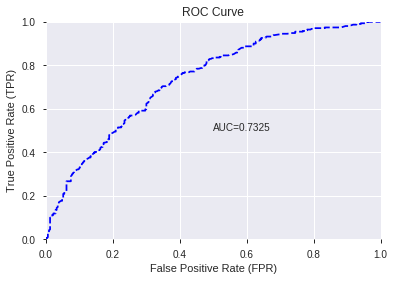

This function is available for GLM models only


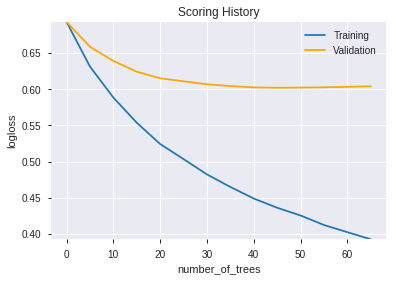

--2019-08-24 19:08:49--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.96.19
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.96.19|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190824_190816_model_7',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190824_190816_model_7',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_9a5d',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_trainin

['BOP',
 'STOCHF_fastk',
 'CCI_8',
 'HT_PHASOR_quadrature',
 'STOCHRSI_fastk',
 'TRANGE',
 'DIV',
 'HT_DCPERIOD',
 'ULTOSC',
 'PLUS_DI_8',
 'STOCHF_fastd',
 'STOCH_slowd',
 'STOCHRSI_fastd',
 'WILLR_12',
 'BETA_24',
 'PLUS_DM_20',
 'MFI_30',
 'BBANDS_lowerband_12_3_3',
 'ADXR_14',
 'LINEARREG_ANGLE_14',
 'DX_24',
 'NATR_8',
 'MFI_14',
 'MFI_8',
 'STDDEV_8',
 'PLUS_DM_8',
 'MACDFIX_hist_24',
 'CDLCLOSINGMARUBOZU',
 'LINEARREG_SLOPE_12',
 'CCI_12',
 'CMO_8',
 'ATR_12',
 'MFI_12',
 'CCI_14',
 'SUB',
 'WILLR_20',
 'MINUS_DI_14',
 'WILLR_14',
 'ROCP_8',
 'MOM_24',
 'TSF_20',
 'CCI_30',
 'ROC_20',
 'NATR_14',
 'aroonup_24',
 'MA_30_1',
 'CMO_24',
 'aroondown_30',
 'AROONOSC_14',
 'aroonup_14',
 'aroondown_24',
 'aroonup_8',
 'ROCP_20',
 'aroondown_8',
 'AROONOSC_8']

In [54]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [55]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.695
GLM             0.682
XGBoost         0.700
dtype: float64

DeepLearning    GLM  XGBoost
All          0.695  0.682    0.686
DLF          0.684  0.682    0.700
Fwe          0.692  0.679    0.687
RFE          0.690  0.679    0.679
XGBF         0.687  0.682    0.700





F1


DeepLearning    0.727
GLM             0.722
XGBoost         0.729
dtype: float64

DeepLearning    GLM  XGBoost
All          0.718  0.716    0.726
DLF          0.727  0.721    0.729
Fwe          0.720  0.720    0.722
RFE          0.724  0.722    0.724
XGBF         0.723  0.721    0.729





auc


DeepLearning    0.749
GLM             0.742
XGBoost         0.757
dtype: float64

DeepLearning    GLM  XGBoost
All          0.734  0.738    0.748
DLF          0.742  0.737    0.757
Fwe          0.749  0.742    0.746
RFE          0.736  0.734    0.733
XGBF         0.746  0.737    0.757





logloss


DeepLearning    0.634
GLM             0.621
XGBoost         0.609
dtype: float64

DeepLearning    GLM  XGBoost
All          0.634  0.621    0.599
DLF          0.600  0.615    0.588
Fwe          0.620  0.597    0.596
RFE          0.611  0.604    0.609
XGBF         0.593  0.615    0.588





mean_per_class_error


DeepLearning    0.316
GLM             0.321
XGBoost         0.322
dtype: float64

DeepLearning    GLM  XGBoost
All          0.305  0.318    0.315
DLF          0.316  0.317    0.301
Fwe          0.308  0.320    0.313
RFE          0.310  0.321    0.322
XGBF         0.313  0.317    0.301





rmse


DeepLearning    0.462
GLM             0.465
XGBoost         0.459
dtype: float64

DeepLearning    GLM  XGBoost
All          0.462  0.465    0.454
DLF          0.455  0.461    0.449
Fwe          0.458  0.454    0.453
RFE          0.461  0.458    0.459
XGBF         0.452  0.461    0.449





mse


DeepLearning    0.213
GLM             0.216
XGBoost         0.210
dtype: float64

DeepLearning    GLM  XGBoost
All          0.213  0.216    0.206
DLF          0.207  0.213    0.202
Fwe          0.209  0.206    0.205
RFE          0.212  0.209    0.210
XGBF         0.204  0.213    0.202

{'F1':       DeepLearning    GLM  XGBoost
 All          0.718    NaN      NaN
 DLF          0.727    NaN      NaN
 DLF            NaN  0.721      NaN
 DLF            NaN    NaN    0.729
 All            NaN  0.716      NaN
 All            NaN    NaN    0.726
 XGBF         0.723    NaN      NaN
 XGBF           NaN  0.721      NaN
 XGBF           NaN    NaN    0.729
 Fwe          0.720    NaN      NaN
 Fwe            NaN  0.720      NaN
 Fwe            NaN    NaN    0.722
 RFE          0.724    NaN      NaN
 RFE            NaN  0.722      NaN
 RFE            NaN    NaN    0.724,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.695    NaN      NaN
 DLF          0.684    NaN      NaN
 DLF            NaN  0.682      NaN
 DLF            NaN    NaN    0.700
 All            NaN  0.682      NaN
 All            NaN    NaN    0.686
 XGBF         0.687    NaN      NaN
 XGBF           NaN  0.682      NaN
 XGBF           NaN    NaN    0.700
 Fwe          0.692    NaN      NaN
 Fwe     